# Match Analysis

# Import Library

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import VerticalPitch, Pitch, create_transparent_cmap, FontManager, arrowhead_marker
from matplotlib.patches import Rectangle, Circle, Polygon
import json
import matplotlib as mpl
import matplotlib.patches as patches
import matplotlib.patheffects as path_effects
import tweepy
import seaborn as sns

C:\Users\hamry\AppData\Local\Temp\ipykernel_10428\459000594.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
pd.set_option('display.max_rows', 1000)
pd.set_option('display.max_columns', 1000)
pd.set_option('display.width', 1000)

NameError: name 'pd' is not defined

# Data

In [3]:
data_detail = 'complete'
data_detail = 'incomplete'

In [4]:
match_date = '05 May 2024'
competition = 'Premier League'
season = '2023-2024'

In [5]:
url = 'shot_stat_liverpool_4_-_2_tottenham_(may_05_2024)'
url = f'D:\\Football\\Data\\shot_stats\\{url}.csv'
understat_df = pd.read_csv(url)

In [6]:
events_data_url = "Events_Data_PSG_VS_Borussia Dortmund_Champions League_2024-05-07"
match_data_url = "Match_Data_PSG_VS_Borussia Dortmund_Champions League_2024-05-07"

In [7]:
with open(f'D:\\Football\\Data\\WhoScored\\{events_data_url}.json') as data_file:
    events_data = json.load(data_file)
events_data = pd.read_json(events_data)

C:\Users\hamry\AppData\Local\Temp\ipykernel_10428\2112882124.py:3: FutureWarning: Passing literal json to 'read_json' is deprecated and will be removed in a future version. To read from a literal string, wrap it in a 'StringIO' object.
  events_data = pd.read_json(events_data)


In [9]:
with open (rf'D:\Football\Data\WhoScored\{match_data_url}.json', 'rb') as fp:
    match_data = json.load(fp)

In [14]:
jerseyNumber = pd.DataFrame({'jerseyNumber': match_data['home']['formations'][0]['jerseyNumbers'] + match_data['away']['formations'][0]['jerseyNumbers'],
                             'playerId': match_data['home']['formations'][0]['playerIds'] + match_data['away']['formations'][0]['playerIds']})
playerIdNameDictionary = match_data['playerIdNameDictionary']
playerdict_df = pd.Series(playerIdNameDictionary).to_frame('playerName')
playerdict_df.index.name = 'playerId'
playerdict_df.index = playerdict_df.index.astype('int64')
jerseyNumber['playerId'] = jerseyNumber['playerId'].astype(object)
jerseyNumber = jerseyNumber.set_index('playerId')
kit_no = pd.merge(jerseyNumber, playerdict_df, on='playerId')

events_data = pd.merge(left=events_data, right=jerseyNumber, on='playerId', how='left')

In [16]:
jerseyNumber

jerseyNumber
playerId              
262515              99
320834               2
395221              25
384887              17
101949               5
440085              35
444679              33
294193               8
395802               9
299513              10
300713               7
65901                1
408962               4
137467              11
94891               15
367780              19
333542              23
299077              26
313542              28
425366              29
302918              37
513663              42
396147              80
336028               1
320436              26
384134              22
111212              23
21541               15
371275               4
346300              10
92051               20
104058              14
141556              19
392646              27
326403               6
367783               8
236544               9
41330               11
312666              17
406701              18
351354              21
129983              25
345363              33
416168              35
492417              38
436425              43

In [10]:
Home_Team = match_data['home']['name']
Away_Team = match_data['away']['name']
Home_Team_ID = match_data['home']['teamId']
Away_Team_ID = match_data['away']['teamId']
Home_Score = int(match_data['score'].split()[0])
Away_Score = int(match_data['score'].split()[2])
Date = match_data['timeStamp'].split(' ')[0].split('-')[2] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[1] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[0]
Competition = match_data['league']
Season = match_data['season']

# Dashboard

## Passing Network

In [11]:
def passing_network(events_data, ax, venue, match_data, TeamId, Team):
    starters_player_ids = []
    for i in range(11):
        starters_player_ids.append(match_data[venue]['formations'][0]['playerIds'][i])
    playerIdNameDictionary = match_data['playerIdNameDictionary']
    starters = {}
    for player_id in starters_player_ids:
        starters[player_id] = playerIdNameDictionary[str(player_id)]
    starters_player_name = []
    for key in starters.keys():
        starters_player_name.append(starters[key])
    
    # Make df with Successfull Passes until the First Substitution
    mask = (events_data.type == 'Pass') & (events_data.teamId == TeamId) & (events_data.outcomeType == 'Successful') & (events_data.throwIn != True)
    team_event = events_data[events_data['teamId'] == TeamId]
    team_event.insert(26, 'passRecipientName', value=team_event['playerName'].shift(-1))
    team_event.insert(27, 'passRecipientId', value=team_event['playerId'].shift(-1))
    team_passes = team_event.loc[mask, ['x', 'y', 'endX', 'endY', 'playerName', 'jerseyNumber', 'passRecipientName']]
    team_passes = team_passes.query(f"playerName == {starters_player_name} & passRecipientName == {starters_player_name}")
    
    scatter_df = pd.DataFrame()

    for i, name in enumerate(team_passes["playerName"].unique()):
        passx = team_passes.loc[team_passes["playerName"] == name]["x"].to_numpy()
        recx = team_passes.loc[team_passes["passRecipientName"] == name]["endX"].to_numpy()
        passy = team_passes.loc[team_passes["playerName"] == name]["y"].to_numpy()
        recy = team_passes.loc[team_passes["passRecipientName"] == name]["endY"].to_numpy()
        
        scatter_df.at[i, "player_name"] = name
        scatter_df.at[i, "jerseyNumber"] = events_data[events_data['playerName'] == name].iloc[0]['jerseyNumber']
        
        # Make sure that x and y location for each circle representing the player is the average of passes and receptions
        scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
        scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
        
        # Calculate the Number of Passes
        scatter_df.at[i, "number_of_passes"] = team_passes.loc[team_passes["playerName"] == name].count().iloc[0]

    # Adjust the size of Circle by Number of Passes
    scatter_df['marker_size'] = (scatter_df['number_of_passes'] / scatter_df['number_of_passes'].max() * 500 + 200)

    # Counting passes between players
    team_passes["pair_key"] = team_passes.apply(lambda x: "_".join(sorted([x["playerName"], x["passRecipientName"]])), axis=1)
    lines_df = team_passes.groupby(["pair_key"]).x.count().reset_index()
    lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)

    # Setting a Treshold of Number Passes
    min_pass_count = 2
    lines_df = lines_df[lines_df['pass_count'] > min_pass_count]


    color = 'white'

    pitch = VerticalPitch(line_color='0.1', pitch_type='opta', corner_arcs=True, goal_type='line',
                        pad_bottom=0, pad_top=0, pad_left=0, pad_right=0)
    pitch.draw(constrained_layout=True, tight_layout=True, ax=ax)

    pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color=color, edgecolors='grey', linewidth=2, alpha=1, ax=ax, zorder = 3)

    for i, row in scatter_df.iterrows():
        pitch.annotate(int(row.jerseyNumber), xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=10, ax=ax, zorder = 4)

    for i, row in lines_df.iterrows():
            link = row['pass_count']
            alpha = link / 20
            if alpha > 1:
                alpha = 1
            player1 = row["pair_key"].split("_")[0]
            player2 = row['pair_key'].split("_")[1]

            # Take the Average Location of Players to Plot Line between Them 
            player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
            player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
            player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
            player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
            num_passes = row["pass_count"]

            # Adjust the line width so that the more passes, the wider the line
            line_width = (num_passes / lines_df['pass_count'].max() * 8)

            #plot lines on the pitch
            pitch.lines(player1_x, player1_y, player2_x, player2_y,
                        alpha=alpha, lw=line_width, zorder=2, color="red", ax = ax)

## Shot Map

### Understat

In [12]:
def shotmap(df, ax):
    pitch = Pitch(pitch_type = 'opta', half = False, goal_type = 'box', goal_alpha = 1, line_color = '0.1', linewidth = 1, corner_arcs=True)
    pitch.draw(constrained_layout=True, tight_layout=True, ax=ax)

    for i in range(len(df)):
        if df.result[i] == 'Goal':
            if df.xG[i] * 300 < 70:
                markersize = 70
            else:
                markersize = df.xG[i] * 300
        else:
            markersize = df.xG[i] * 300

        scatter = pitch.scatter(
            (1 - df.X[i]) * 100 if (df.h_a[i] == 'h') else df.X[i] * 100,
            (1 - df.Y[i]) * 100 if (df.h_a[i] == 'h') else df.Y[i] * 100,
            s = markersize, marker = "o",
            c = 'red' if (df.result[i] == 'Goal' or df.result[i] == 'OwnGoal') else 'white',
            edgecolors = 'blue', zorder = 1 if (df.result[i] == 'Goal' or df.result[i] == 'OwnGoal') else 0, ax = ax
        )
    
    ax.text(x = 3, y = 3, s = f'{Home_Team.upper()} SHOTS', size = 20, c = '0.5', ha='left')
    ax.text(x = 98, y = 3,s = f'{Away_Team.upper()} SHOTS', size = 20, c = '0.5', ha = 'right')

### WhoScored

In [13]:
def whoscored_shotmap(df, ax):
    df = df[(df['type'] == 'Goal') | (df['type'] == 'MissedShots') | (df['type'] == 'SavedShot') | (df['type'] == 'ShotOnPost')].reset_index(drop=True)
    pitch = Pitch(pitch_type = 'opta', half = False, goal_type = 'box', goal_alpha = 1, line_color = '0.1', linewidth = 1, corner_arcs=True)
    pitch.draw(constrained_layout=True, tight_layout=True, ax=ax)

    for i in range(len(df)):
        if df.h_a[i] == 'h':
            ec = 'blue'
            cm = 'red'
        else:
            ec = 'red'
            cm = 'blue'
        pitch.scatter(
            # Coordinates
            (100 - df.x[i]) if (df.h_a[i] == 'h') else df.x[i],
            (100 - df.y[i]) if (df.h_a[i] == 'h') else df.y[i],
            # Size Between 100 and 300
            s = 100,
            # Type of Marker
            marker = 'o',
            # Color Marker
            c = cm if (df.type[i] == 'Goal' or df.type[i] == 'OwnGoal') else 'white',
            # Color Marker Border
            edgecolors = ec, ax = ax,
            zorder = 1 if (df.type[i] == 'Goal' or df.type[i] == 'OwnGoal') else 0
        )
    
    ax.text(x = 3, y = 3, s = f'{Home_Team.upper()} SHOTS', size = 20, c = '0.5', ha='left')
    ax.text(x = 98, y = 3,s = f'{Away_Team.upper()} SHOTS', size = 20, c = '0.5', ha = 'right')

## Player Statistics

In [14]:
def player_statistic(match_data, events_data, venue, ax):
    if venue == 'home':
        h_a = 'h'
    else:
        h_a = 'a'

    team_events = events_data[events_data.h_a == h_a]

    player_statistics = {}
    for i in range(len(match_data['away']['players'])):
        stats = {}
        for player_stats in match_data['away']['players'][i]['stats'].keys():
            stats[player_stats] = sum(match_data['away']['players'][i]['stats'][player_stats].values())
        player_id = match_data['away']['players'][i]['playerId']
        player_statistics[player_id] = stats
    
    ratings = {}
    for player in match_data[venue]['players']:
        if 'isFirstEleven' in list(player.keys()):
            ratings[player['playerId']] = player['stats']['ratings'][list(player['stats']['ratings'].keys())[len(player['stats']['ratings'].keys()) - 1]]
        elif 'subbedInExpandedMinute' in list(player.keys()):
            ratings[player['playerId']] = player['stats']['ratings'][list(player['stats']['ratings'].keys())[len(player['stats']['ratings'].keys()) - 1]]
        else:
            pass
    
    jersey_number = {'jerseyNumber': match_data['home']['formations'][0]['jerseyNumbers'] + match_data['away']['formations'][0]['jerseyNumbers'], 
                 'playerId': match_data['home']['formations'][0]['playerIds'] + match_data['away']['formations'][0]['playerIds']}
    kit_numbers = {}
    for i in range(len(jersey_number['jerseyNumber'])):
        kit_numbers[jersey_number['playerId'][i]] = jersey_number['jerseyNumber'][i]
    playerIdNameDictionary = match_data['playerIdNameDictionary']

    players = []
    for id in list(ratings.keys()):
        player = {}
        player['id'] = id
        player['kit_no'] = kit_numbers[id]
        player['name'] = playerIdNameDictionary[str(id)]
        player['rating'] = ratings[id]
        player['kit_no'] = kit_numbers[id]
        player['goals'] = len(events_data[(events_data.playerId == id) & (events_data.isGoal == True)])
        player['assist'] = len(events_data[(events_data.playerId == id) & (events_data.assist == True)])
        player['pass_attempted'] = len(events_data[(events_data.playerId == id) & (events_data.type == 'Pass')])
        player['pass_completed'] = len(events_data[(events_data.playerId == id) & (events_data.type == 'Pass') & (events_data.outcomeType == 'Successful')])
        player['key_pass'] = len(events_data[(events_data.playerId == id) & ((events_data['keyPassLong'] == True) | (events_data['keyPassShort'] == True) | (events_data['keyPassCross'] == True) | (events_data['keyPassCorner'] == True) | (events_data['keyPassThroughball'] == True) | (events_data['keyPassFreekick'] == True) | (events_data['keyPassThrowin'] == True) | (events_data['keyPassOther'] == True))])
        player['shot_attempted'] = len(events_data[(events_data.playerId == id) & ((events_data['type'] == 'Goal') | (events_data['type'] == 'MissedShots') | (events_data['type'] == 'SavedShot') | (events_data['type'] == 'ShotOnPost'))])
        player['shot_on_target'] = len(events_data[(events_data.playerId == id) & ((events_data['type'] == 'Goal') | (events_data['type'] == 'SavedShot') | (events_data['type'] == 'ShotOnPost'))])
        player['big_chance']= len(events_data[(events_data.playerId == id) & ((events_data.bigChanceMissed == True) | (events_data.bigChanceScored == True))])
        player['yellow_card'] = len(events_data[(events_data.playerId == id) & (events_data.yellowCard == True)])
        player['second_yellow'] = len(events_data[(events_data.playerId == id) & (events_data.secondYellow == True)])
        player['red_card'] = len(events_data[(events_data.playerId == id) & (events_data.redCard == True)])
        player['substituon_on'] = len(events_data[(events_data.playerId == id) & (events_data.type == 'SubstitutionOn')])
        player['substituon_off'] = len(events_data[(events_data.playerId == id) & (events_data.type == 'SubstitutionOff')])
        players.append(player)
    
    
    rows = 16
    cols = 12

    # Title
    x = 0.5
    ax.text(x=x, y=rows, s='No.', va='center', ha='center', size=10, weight='bold')
    x += 1
    ax.text(x=x, y=rows, s='Sub', va='center', ha='left', size=10, weight='bold')
    x += 1
    ax.text(x=x, y=rows, s='Card', va='center', ha='left', size=10, weight='bold')
    x += 1
    ax.text(x=x, y=rows, s='Player Name', va='center', ha='left', size=10, weight='bold')
    x += 5
    ax.text(x=x, y=rows, s='Pass/Comp/Key', va='center', ha='center', size=10, weight='bold')
    x += 2
    ax.text(x=x, y=rows, s='Shot/On/Big', va='center', ha='center', size=10, weight='bold')
    x += 1.7
    ax.text(x=x, y=rows, s='Goal', va='center', ha='center', size=10, weight='bold')
    x += 1
    ax.text(x=x, y=rows, s='Assist', va='center', ha='center', size=10, weight='bold')
    x += 1.2
    ax.text(x=x, y=rows, s='Rating', va='center', ha='center', size=10, weight='bold')

    for row in range(rows):
        try:
            col_num = 0
            player = players[row]

            # Kit No
            x = 0.5
            ax.text(x=x, y=rows - row - 1, s=player['kit_no'], va='center', ha='center', size=10)

            # Subs
            def subs_on(x, y):
                sub_on = patches.FancyArrowPatch((x-0.3, y), (x+0.3, y), lw=3, color='blue', alpha=1, mutation_scale=10)
                ax.add_patch(sub_on)
            
            def subs_off(x, y):
                sub_on = patches.FancyArrowPatch((x+0.3, y), (x-0.3, y), lw=2, color='red', alpha=1, mutation_scale=10)
                ax.add_patch(sub_on)

            x += 1
            if player['substituon_on'] > 0:
                subs_on(x=x+0.2, y=rows - row - 1)
            elif player['substituon_off'] > 0:
                subs_off(x=x+0.2, y=rows - row - 1)
            else:
                pass

            # Card
            def yellow_card(x, y):
                yellow_card = patches.Rectangle((x, y - 0.3), width=.5, height=.6, lw=1, ec='black', fc='yellow', alpha=1, zorder=-1)
                ax.add_patch(yellow_card)

            def red_card(x, y):
                yellow_card = patches.Rectangle((x, y - 0.3), width=.5, height=.6, lw=1, ec='black', fc='red', alpha=1, zorder=-1)
                ax.add_patch(yellow_card)

            def second_yellow(x, y):
                yellow_card(x=x-0.1, y=y-0.1)
                yellow_card(x=x+0.1, y=y+0.1)

            x += 1
            if player['second_yellow'] > 0:
                second_yellow(x=x, y=rows - row - 1)
            elif player['red_card'] > 0:
                red_card(x=x, y=rows - row - 1)
            elif player['yellow_card'] > 0:
                yellow_card(x=x, y=rows - row - 1)
            else:
                pass

            # Player Name
            x += 1
            ax.text(x=x, y=rows - row - 1, s=player['name'], va='center', ha='left', size=10)

            # Passes
            x += 5
            ax.text(x=x, y=rows - row - 1, s=f'{player['pass_attempted']}/{player['pass_completed']}/{player['key_pass']}', va='center', ha='center', size=10)
            
            # Shot
            x += 2
            ax.text(x=x, y=rows - row - 1, s=f'{player['shot_attempted']}/{player['shot_on_target']}/{player['big_chance']}', va='center', ha='center', size=10)

            # Goal
            x += 1.7
            ax.text(x=x, y=rows - row - 1, s=player['goals'], va='center', ha='center', size=10)

            # Assist
            x += 1
            ax.text(x=x, y=rows - row - 1, s=player['assist'], va='center', ha='center', size=10)

            # Rating
            x += 1.2
            ax.text(x=x, y=rows - row - 1, s=round(player['rating'], 1), va='center', ha='center')

            ax.plot([0, x+1], [rows - row -.5, rows - row - .5], ls=':', lw='1', c='0')
            last = row
        except:
            pass

    ax.plot([0, x+1], [rows - last - 1 -.5, rows - last - 1 - .5], ls='-', lw='1', c='0')
    ax.plot([0, x+1], [rows - 0.5, rows - 0.5], lw='1', c='black')

    # set up the axis limits with "spacing" (a bit of padding on each side)
    ax.set_ylim(-1, 16 + 1.5)
    ax.set_xlim(0, x + 1)

    # rect = patches.Rectangle((1.65, -.5), .65, height=1, lw=1, ec='none', fc='grey', alpha=.2, zorder=-1)
    # ax.add_patch(rect)
    ax.axis('off')
        


## Match Statistics

In [15]:
def scatter_football(x, y, ax=None, **kwargs):
    import matplotlib.path as mpath

    # football hexagon arrays
    football_hexagon_codes = np.array([1, 3, 3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 79, 1, 3,
                                    3, 3, 3, 4, 4, 4, 3, 3, 3, 3, 3, 3, 79, 1, 3, 3, 3,
                                    3, 4, 4, 4, 3, 3, 2, 3, 3, 79, 1, 2, 3, 3, 4, 4, 4,
                                    3, 3, 3, 3, 3, 3, 79, 1, 3, 3, 3, 3, 4, 4, 4, 3, 3,
                                    3, 3, 3, 3, 79, 1, 1, 1, 1])
    football_hexagon_vertices = np.array([[-0.22499999999999998, -0.3096859321060139],
                                        [-0.3578624191511828, -0.42126390612162967],
                                        [-0.4307248383023656, -0.5928418801372455],
                                        [-0.29662436542138726, -0.7538845585184165],
                                        [-0.22252389254040889, -0.9749272368995876],
                                        [-0.07605800448461039, -1.0083575877001376],
                                        [0.07605800448461039, -1.0083575877001376],
                                        [0.22252389254040889, -0.9749272368995876],
                                        [0.29662436542138726, -0.7538845585184165],
                                        [0.43072483830236563, -0.5928418801372455],
                                        [0.3578624191511828, -0.4212639061216298],
                                        [0.22499999999999987, -0.30968593210601403],
                                        [-0.00000000000000005551115123125783, -0.33968593210601394],
                                        [-0.22499999999999998, -0.3096859321060139],
                                        [-0.22499999999999998, -0.3096859321060139],
                                        [0.22499999999999984, -0.309685932106014],
                                        [0.35786241915118266, -0.42126390612162967],
                                        [0.4307248383023654, -0.5928418801372455],
                                        [0.6745860377099481, -0.5228718813250733],
                                        [0.8584472371175307, -0.5129018825129013],
                                        [0.9355018385938869, -0.38393509178776364],
                                        [0.982508270481868, -0.2392641702247741],
                                        [0.9959745660164324, -0.0896362864490644],
                                        [0.8164509970942311, 0.038404580904486146],
                                        [0.6969274281720299, 0.2264454482580367],
                                        [0.5004925378203781, 0.1423674742424208],
                                        [0.36405764746872626, 0.11828950022680491],
                                        [0.3245288237343631, -0.06569821593960454],
                                        [0.22499999999999984, -0.309685932106014],
                                        [0.22499999999999984, -0.309685932106014],
                                        [0.36405764746872626, 0.11828950022680493],
                                        [0.5004925378203782, 0.14236747424242066],
                                        [0.69692742817203, 0.22644544825803642],
                                        [0.6950004453997567, 0.47219094443542353],
                                        [0.7530734626274834, 0.6579364406128105],
                                        [0.654229937273651, 0.77107265150149],
                                        [0.531165500901059, 0.8604841982111864],
                                        [0.3930222411881726, 0.919528965248744],
                                        [0.22651112059408626, 0.7961609145035808],
                                        [-0.00000000000000005551115123125783, 0.7327928637584178],
                                        [0.00000000000000013877787807814457, 0.3827928637584179],
                                        [0.2120288237343632, 0.28054118199261147],
                                        [0.36405764746872626, 0.11828950022680493],
                                        [0.36405764746872626, 0.11828950022680493],
                                        [0.00000000000000013877787807814457, 0.38279286375841787],
                                        [0.00000000000000016653345369377348, 0.7327928637584178],
                                        [-0.226511120594086, 0.796160914503581],
                                        [-0.3930222411881722, 0.9195289652487442],
                                        [-0.5311655009010592, 0.8604841982111865],
                                        [-0.6542299372736504, 0.771072651501486],
                                        [-0.7530734626274826, 0.6579364406128061],
                                        [-0.6950004453997563, 0.41219094443542137],
                                        [-0.69692742817203, 0.22644544825803659],
                                        [-0.5604925378203782, 0.14236747424242088],
                                        [-0.36405764746872626, 0.1182895002268052],
                                        [-0.21202882373436308, 0.28054118199261147],
                                        [0.00000000000000013877787807814457, 0.38279286375841787],
                                        [0.00000000000000013877787807814457, 0.38279286375841787],
                                        [-0.36405764746872615, 0.11828950022680515],
                                        [-0.560492537820378, 0.142367474242421],
                                        [-0.6969274281720299, 0.2264454482580368],
                                        [-0.8164509970942311, 0.03840458090448631],
                                        [-0.9959745660164324, -0.08963628644906418],
                                        [-0.9825082704818681, -0.23926417022477386],
                                        [-0.9355018385938869, -0.38393509178776364],
                                        [-0.8584472371175307, -0.5129018825129013],
                                        [-0.6145860377099481, -0.5228718813250733],
                                        [-0.43072483830236563, -0.5928418801372455],
                                        [-0.3578624191511829, -0.42126390612162967],
                                        [-0.2250000000000001, -0.30968593210601386],
                                        [-0.3245288237343631, -0.12569821593960442],
                                        [-0.36405764746872615, 0.11828950022680515],
                                        [-0.36405764746872615, 0.11828950022680515],
                                        [-1.0204451903760434, -1.0083575877001376],
                                        [-1.0204451903760434, 1.0268236782504188],
                                        [1.0204451903760436, -1.0083575877001376],
                                        [1.0204451903760436, 1.0268236782504188]])

    # football pentagon arrays
    football_pentagon_codes = np.array([1, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 79, 1, 3, 3, 4, 4,
                                        4, 3, 3, 79, 1, 3, 3, 4, 4, 4, 3, 3, 79, 1, 3, 3, 4,
                                        4, 4, 3, 3, 79, 1, 3, 3, 4, 4, 4, 3, 3, 79, 1, 3, 3,
                                        4, 4, 4, 3, 3, 79, 1, 1, 1, 1])
    football_pentagon_vertices = np.array([[0.000000000000000023439302766909766, 0.38279286375841787],
                                        [-0.21202882373436308, 0.28054118199261147],
                                        [-0.3640576474687262, 0.11828950022680507],
                                        [-0.3245288237343631, -0.12569821593960442],
                                        [-0.22499999999999998, -0.3096859321060139],
                                        [-0.00000000000000005551115123125783, -0.33968593210601394],
                                        [0.22499999999999987, -0.30968593210601403],
                                        [0.3245288237343631, -0.06569821593960454],
                                        [0.36405764746872626, 0.11828950022680493],
                                        [0.2120288237343632, 0.28054118199261147],
                                        [0.00000000000000011719651383454883, 0.38279286375841787],
                                        [0.00000000000000011719651383454883, 0.38279286375841787],
                                        [0.43072483830236563, -0.5928418801372455],
                                        [0.29662436542138726, -0.7538845585184165],
                                        [0.22252389254040889, -0.9749272368995876],
                                        [0.48867813807221294, -0.9141784174079514],
                                        [0.7184254914884021, -0.7472571944544121],
                                        [0.8584472371175307, -0.5129018825129013],
                                        [0.6745860377099481, -0.5228718813250733],
                                        [0.43072483830236563, -0.5928418801372455],
                                        [0.43072483830236563, -0.5928418801372455],
                                        [0.6969274281720299, 0.2264454482580367],
                                        [0.8164509970942311, 0.038404580904486146],
                                        [0.9959745660164324, -0.0896362864490644],
                                        [1.0204451903760436, 0.18226386071471035],
                                        [0.9326895101963948, 0.4523480728972359],
                                        [0.7530734626274834, 0.6579364406128105],
                                        [0.6950004453997567, 0.47219094443542353],
                                        [0.6969274281720299, 0.2264454482580367],
                                        [0.6969274281720299, 0.2264454482580367],
                                        [-0.00000000000000005551115123125783, 0.7327928637584178],
                                        [0.22651112059408626, 0.7961609145035808],
                                        [0.3930222411881726, 0.919528965248744],
                                        [0.1419916732365391, 1.0268236782504185],
                                        [-0.14199167323653866, 1.0268236782504188],
                                        [-0.3930222411881722, 0.9195289652487442],
                                        [-0.226511120594086, 0.796160914503581],
                                        [-0.00000000000000005551115123125783, 0.7327928637584178],
                                        [-0.00000000000000005551115123125783, 0.7327928637584178],
                                        [-0.69692742817203, 0.22644544825803659],
                                        [-0.6950004453997563, 0.41219094443542137],
                                        [-0.7530734626274826, 0.6579364406128061],
                                        [-0.9326895101963917, 0.452348072897233],
                                        [-1.0204451903760434, 0.18226386071470885],
                                        [-0.9959745660164324, -0.08963628644906418],
                                        [-0.8164509970942311, 0.03840458090448631],
                                        [-0.69692742817203, 0.22644544825803659],
                                        [-0.69692742817203, 0.22644544825803659],
                                        [-0.43072483830236563, -0.5928418801372455],
                                        [-0.6145860377099481, -0.5228718813250733],
                                        [-0.8584472371175307, -0.5129018825129013],
                                        [-0.7184254914884021, -0.7472571944544121],
                                        [-0.48867813807221294, -0.9141784174079514],
                                        [-0.22252389254040889, -0.9749272368995876],
                                        [-0.29662436542138726, -0.7538845585184165],
                                        [-0.43072483830236563, -0.5928418801372455],
                                        [-0.43072483830236563, -0.5928418801372455],
                                        [-1.0204451903760434, -1.0083575877001376],
                                        [-1.0204451903760434, 1.0268236782504188],
                                        [1.0204451903760436, -1.0083575877001376],
                                        [1.0204451903760436, 1.0268236782504188]])

    football_hexagon_marker = mpath.Path(football_hexagon_vertices, football_hexagon_codes)
    football_pentagon_marker = mpath.Path(football_pentagon_vertices, football_pentagon_codes)

    linewidths = kwargs.pop('linewidths', 0.5)
    hexcolor = kwargs.pop('c', 'white')
    pentcolor = kwargs.pop('edgecolors', 'black')
    s = kwargs.pop('s', 500)
    sc_hex = ax.scatter(x, y, edgecolors=pentcolor, c=hexcolor, linewidths=linewidths,
                        marker=football_hexagon_marker, s=s, **kwargs)

    if 'label' in kwargs:
        Legend.update_default_handler_map({sc_hex: HandlerFootball()})
        del kwargs['label']

    sc_pent = ax.scatter(x, y, edgecolors=pentcolor, c=pentcolor, linewidths=linewidths,
                         marker=football_pentagon_marker, s=s, **kwargs)

    return sc_hex, sc_pent

In [23]:
def match_statistic(match_data, events_data, ax):
    Home_Team = match_data['home']['name']
    Away_Team = match_data['away']['name']
    Home_Score = int(match_data['score'].split()[0])
    Away_Score = int(match_data['score'].split()[2])
    Date = match_data['timeStamp'].split(' ')[0].split('-')[2] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[1] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[0]
    Competition = match_data['league']
    Season = match_data['season']

    venue = 'home'
    home_stats = {}
    for key in match_data[venue]['stats'].keys():
        try:
            home_stats[key] = sum(match_data[venue]['stats'][key].values())
        except:
            pass
    home_stats['yellow_card'] = len(events_data[(events_data.h_a == 'h') & (events_data.yellowCard == True)])
    home_stats['red_card'] = len(events_data[(events_data.h_a == 'h') & (events_data.redCard == True)])
    home_stats['offside'] = len(events_data[(events_data.h_a == 'h') & (events_data.offsideGiven == True)])
    opponent_passes_three_fifths = events_data[(events_data.h_a == 'a') & (events_data.type == 'Pass') & (events_data.x > 2/5*100)]
    defensive_action_three_fifths = events_data[(events_data.h_a == 'h') & (events_data.x > 2/5*100) & ((events_data.type == 'Tackle') | (events_data.type == 'Foul') | (events_data.type == 'Challenge') | (events_data.type == 'Interception'))].reset_index(drop=True)
    home_stats['ppda'] = len(opponent_passes_three_fifths) / len(defensive_action_three_fifths)

    home_incidents = []
    for key in match_data[venue]['incidentEvents']:
        if 'playerId' in list(key.keys()):
            incident = {}
            incident['name'] = key['type']['displayName']
            incident['minute'] = key['minute'] + key['second']/60
            incident['player_id'] = key['playerId']
            if key['type']['displayName'] == 'Card':
                incident['card_type'] = key['cardType']['displayName']
            home_incidents.append(incident)
    
    venue = 'away'
    away_stats = {}
    for key in match_data[venue]['stats'].keys():
        try:
            away_stats[key] = sum(match_data[venue]['stats'][key].values())
        except:
            pass
    away_stats['yellow_card'] = len(events_data[(events_data.h_a == 'a') & (events_data.yellowCard == True)])
    away_stats['red_card'] = len(events_data[(events_data.h_a == 'a') & (events_data.redCard == True)])
    away_stats['offside'] = len(events_data[(events_data.h_a == 'a') & (events_data.offsideGiven == True)])
    opponent_passes_three_fifths = events_data[(events_data.h_a == 'h') & (events_data.type == 'Pass') & (events_data.x > 2/5*100)]
    defensive_action_three_fifths = events_data[(events_data.h_a == 'a') & (events_data.x > 2/5*100) & ((events_data.type == 'Tackle') | (events_data.type == 'Foul') | (events_data.type == 'Challenge') | (events_data.type == 'Interception'))].reset_index(drop=True)
    away_stats['ppda'] = len(opponent_passes_three_fifths) / len(defensive_action_three_fifths)

    away_incidents = []
    for key in match_data[venue]['incidentEvents']:
        if 'playerId' in list(key.keys()):
            incident = {}
            incident['name'] = key['type']['displayName']
            incident['minute'] = key['minute'] + key['second']/60
            incident['player_id'] = key['playerId']
            if key['type']['displayName'] == 'Card':
                incident['card_type'] = key['cardType']['displayName']
            away_incidents.append(incident)

    rows = 8
    cols = 7

    ax.set_ylim(-1, rows + 9)
    ax.set_xlim(0, cols)
    
    # Detail Match
    ax.text(x=cols/2, y=rows+8., s=f'{Competition} {Season}', ha='center', va='center', size=12)
    ax.text(x=cols/2, y=rows+7.5, s=f'{match_date}', ha='center', va='center', size=12)
    ax.text(x=cols/2, y=rows+6.5, s=f'{Home_Score} - {Away_Score}', ha='center', va='center', size=22)
    ax.text(x=cols/2 - 0.4, y=rows+6.5, s=f'{Home_Team}', ha='right', va='center', size=22)
    ax.text(x=cols/2 + 0.4, y=rows+6.5, s=f'{Away_Team}', ha='left', va='center', size=22)
    
    y = rows + 5.5
    for i in range(len(home_incidents)):
        if home_incidents[i]['name'] == 'Goal':
            ax.text(x=cols/2 - 0.5, y=y, s=f"{int(round(home_incidents[i]['minute'], 0))}'", ha='right', va='center', size=12)
            ax.text(x=cols/2 - 0.8, y=y, s=f"{playerIdNameDictionary[str(home_incidents[i]['player_id'])]}", ha='right', va='center', size=12)
            y -= 0.7
        # elif home_incidents[i]['name'] == 'Card':
            #if home_incidents[i]['card_type'] == 'Yellow':
             #   ax.text(x=cols/2 - 0.5, y=y, s=f"{playerIdNameDictionary[str(home_incidents[i]['player_id'])]} {int(round(home_incidents[i]['minute'], 0))}'", ha='right', va='center')
            #y -= 0.7
    scatter_football(ax=ax, x=cols/2, y=rows+4.7)

    y = rows + 5
    for i in range(len(away_incidents)):
        if away_incidents[i]['name'] == 'Goal':
            ax.text(x=cols/2 + 0.5, y=y, s=f"{int(round(away_incidents[i]['minute'], 0))}'", ha='left', va='center', size=12)
            ax.text(x=cols/2 + 0.8, y=y, s=f"{playerIdNameDictionary[str(away_incidents[i]['player_id'])]}", ha='left', va='center', size=12)
            y -= 0.7
        #elif away_incidents[i]['name'] == 'Card':
         #   if away_incidents[i]['card_type'] == 'Yellow':
          #      ax.text(x=cols/2 - 0.5, y=y, s=f"{playerIdNameDictionary[str(away_incidents[i]['player_id'])]} {int(round(away_incidents[i]['minute'], 0))}'", ha='right', va='center')
           # y -= 0.7

    
    # Title
    ax.text(x=cols/2, y=rows+1, s='STATISTIC', ha='center', va='center', size=14, weight='bold')
    ax.text(x=.7, y=rows+1, s=Home_Team.upper(), ha='left', va='center', size=14, weight='bold')
    ax.text(x=cols-.7, y=rows+1, s=Away_Team.upper(), ha='right', va='center', size=14, weight='bold')

    text_size = 12
    # Shots
    y = rows
    ax.text(x=cols/2, y=y, s='Shots', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=int(home_stats['shotsTotal']), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=int(away_stats['shotsTotal']), va='center', ha='right', size=text_size)
    
    # On Target
    y -= 1
    ax.text(x=cols/2, y=y, s='On Target', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=int(home_stats['shotsOnTarget']), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=int(away_stats['shotsOnTarget']), va='center', ha='right', size=text_size)

    # Possession
    y -= 1
    ax.text(x=cols/2, y=y, s='Possession', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=f'{round(home_stats['possession']/(home_stats['possession'] + away_stats['possession'])*100, 1)}%', va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=f'{round(away_stats['possession']/(home_stats['possession'] + away_stats['possession'])*100, 1)}%', va='center', ha='right', size=text_size)
    
    # PPDA
    y -= 1
    ax.text(x=cols/2, y=y, s='PPDA', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=round(home_stats['ppda'], 2), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=round(away_stats['ppda'], 2), va='center', ha='right', size=text_size)

    # Fouls
    y -= 1
    ax.text(x=cols/2, y=y, s='Fouls', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=int(home_stats['foulsCommited']), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=int(away_stats['foulsCommited']), va='center', ha='right', size=text_size)

    # Yellow Card
    y -= 1
    ax.text(x=cols/2, y=y, s='Yellow Card', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=home_stats['yellow_card'], va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=away_stats['yellow_card'], va='center', ha='right', size=text_size)

    # Red Card
    y -= 1
    ax.text(x=cols/2, y=y, s='Red Cards', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=home_stats['red_card'], va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=away_stats['red_card'], va='center', ha='right', size=text_size)

    # Offside
    y -= 1
    ax.text(x=cols/2, y=y, s='Offsides', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=home_stats['offside'], va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=away_stats['offside'], va='center', ha='right', size=text_size)

    # Corner Kick
    y -= 1
    ax.text(x=cols/2, y=y, s='Corner Kicks', va='center', ha='center', size=text_size)
    ax.text(x=1, y=y, s=int(home_stats['cornersTotal']), va='center', ha='left', size=text_size)
    ax.text(x=cols-1, y=y, s=int(away_stats['cornersTotal']), va='center', ha='right', size=text_size)

    for row in range(rows + 1):
        ax.plot([0.8, cols-0.8], [row -.5, row - .5], ls=':', lw='1.2', c='0')

    ax.plot([0.8, cols-0.8], [rows + 1 - 0.5, rows + 1 - 0.5], lw='1', c='black')

    ax.axis('off')

## Progressive Pass

In [17]:
def progressive_pass(ax, events_data, venue):
    if venue == 'home':
        df = events_data[(events_data.type == 'Pass') & (events_data.h_a == 'h')].reset_index(drop=True)
    elif venue == 'away':
        df = events_data[(events_data.type == 'Pass') & (events_data.h_a == 'a')].reset_index(drop=True)

    df['X'] = df.x
    df['Y'] = df.y
    df['ENDX'] = df.endX
    df['ENDY'] = df.endY
    df['xmetre'] = df.x * 1.05
    df['ymetre'] = df.y * 0.68
    df['endXmetre'] = df.endX * 1.05
    df['endYmetre'] = df.endY * 0.68
    df['beginning'] = np.sqrt(np.square(100 - df.x) + np.square(50 - df.y))
    df['end'] = np.sqrt(np.square(100 - df.endX) + np.square(50 - df.endY))
    df['beginningmetre'] = np.sqrt(np.square(105 - df.xmetre) + np.square(34 - df.ymetre))
    df['endmetre'] = np.sqrt(np.square(105 - df.endXmetre) + np.square(34 - df.endYmetre))
    df['progressive'] = df.beginning - df.end
    df['progressivemetre'] = df.beginningmetre - df.endmetre
    df['check'] = [(df.end[x]) / (df.beginning[x]) for x in range(len(df))]
    df['checkmetre'] = [(df.endmetre[x]) / (df.beginningmetre[x]) for x in range(len(df))]
    df['checkprogressive'] = [(df.end[x]) / (df.beginning[x]) < .75 for x in range(len(df))]
    df['test'] = [((df.beginning[x] - df.end[x]) * (df.beginningmetre[x] - df.endmetre[x])) < 0 for x in range(len(df))]

    own_half = df[(df.x < 50) & (df.endX < 50) & (df.progressivemetre > 30)]
    different_halves = df[(df.x < 50) & (df.endX > 50) & (df.progressivemetre > 15)]
    opponent_half = df[(df.x > 50) & (df.endX > 50) & (df.progressivemetre > 10)]

    df = pd.concat([own_half, different_halves, opponent_half]).reset_index(drop=True)
    df = df[(df.outcomeType == 'Successful') & (df.passCorner == False) & (df.throwIn == False)].reset_index(drop=True)

    pitch = VerticalPitch(line_color='0.1', pitch_type='opta', line_zorder=2, corner_arcs=True, pad_bottom=0, pad_left=0, pad_right=0, pad_top=0)
    pitch.draw(constrained_layout=True, tight_layout=True, ax=ax)

    for i in range(len(df)):

        if df.outcomeType[i] == 'Successful':
            color = 'blue'
        else:
            color = 'red'

        pitch.lines(df.x[i], df.y[i], df.endX[i], df.endY[i],
                color=color, lw=4, transparent=True, comet=True,
                alpha_start=0.2, alpha_end=1, ax=ax)
        
        pitch.scatter(df.endX[i], df.endY[i], s=70, marker='o', edgecolors='black',
                    c=color, zorder=2, ax=ax)

## Figure

C:\Users\hamry\AppData\Local\Temp\ipykernel_26780\2172353550.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes["pair_key"] = team_passes.apply(lambda x: "_".join(sorted([x["playerName"], x["passRecipientName"]])), axis=1)
C:\Users\hamry\AppData\Local\Temp\ipykernel_26780\2172353550.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  team_passes["pair_key"] = team_passes.apply(lambda x: "_".join(sorted([x["playerName"], x["passRecipientName"]])), axis=1)


Text(0.5, 1.0, 'Progressive Pass')

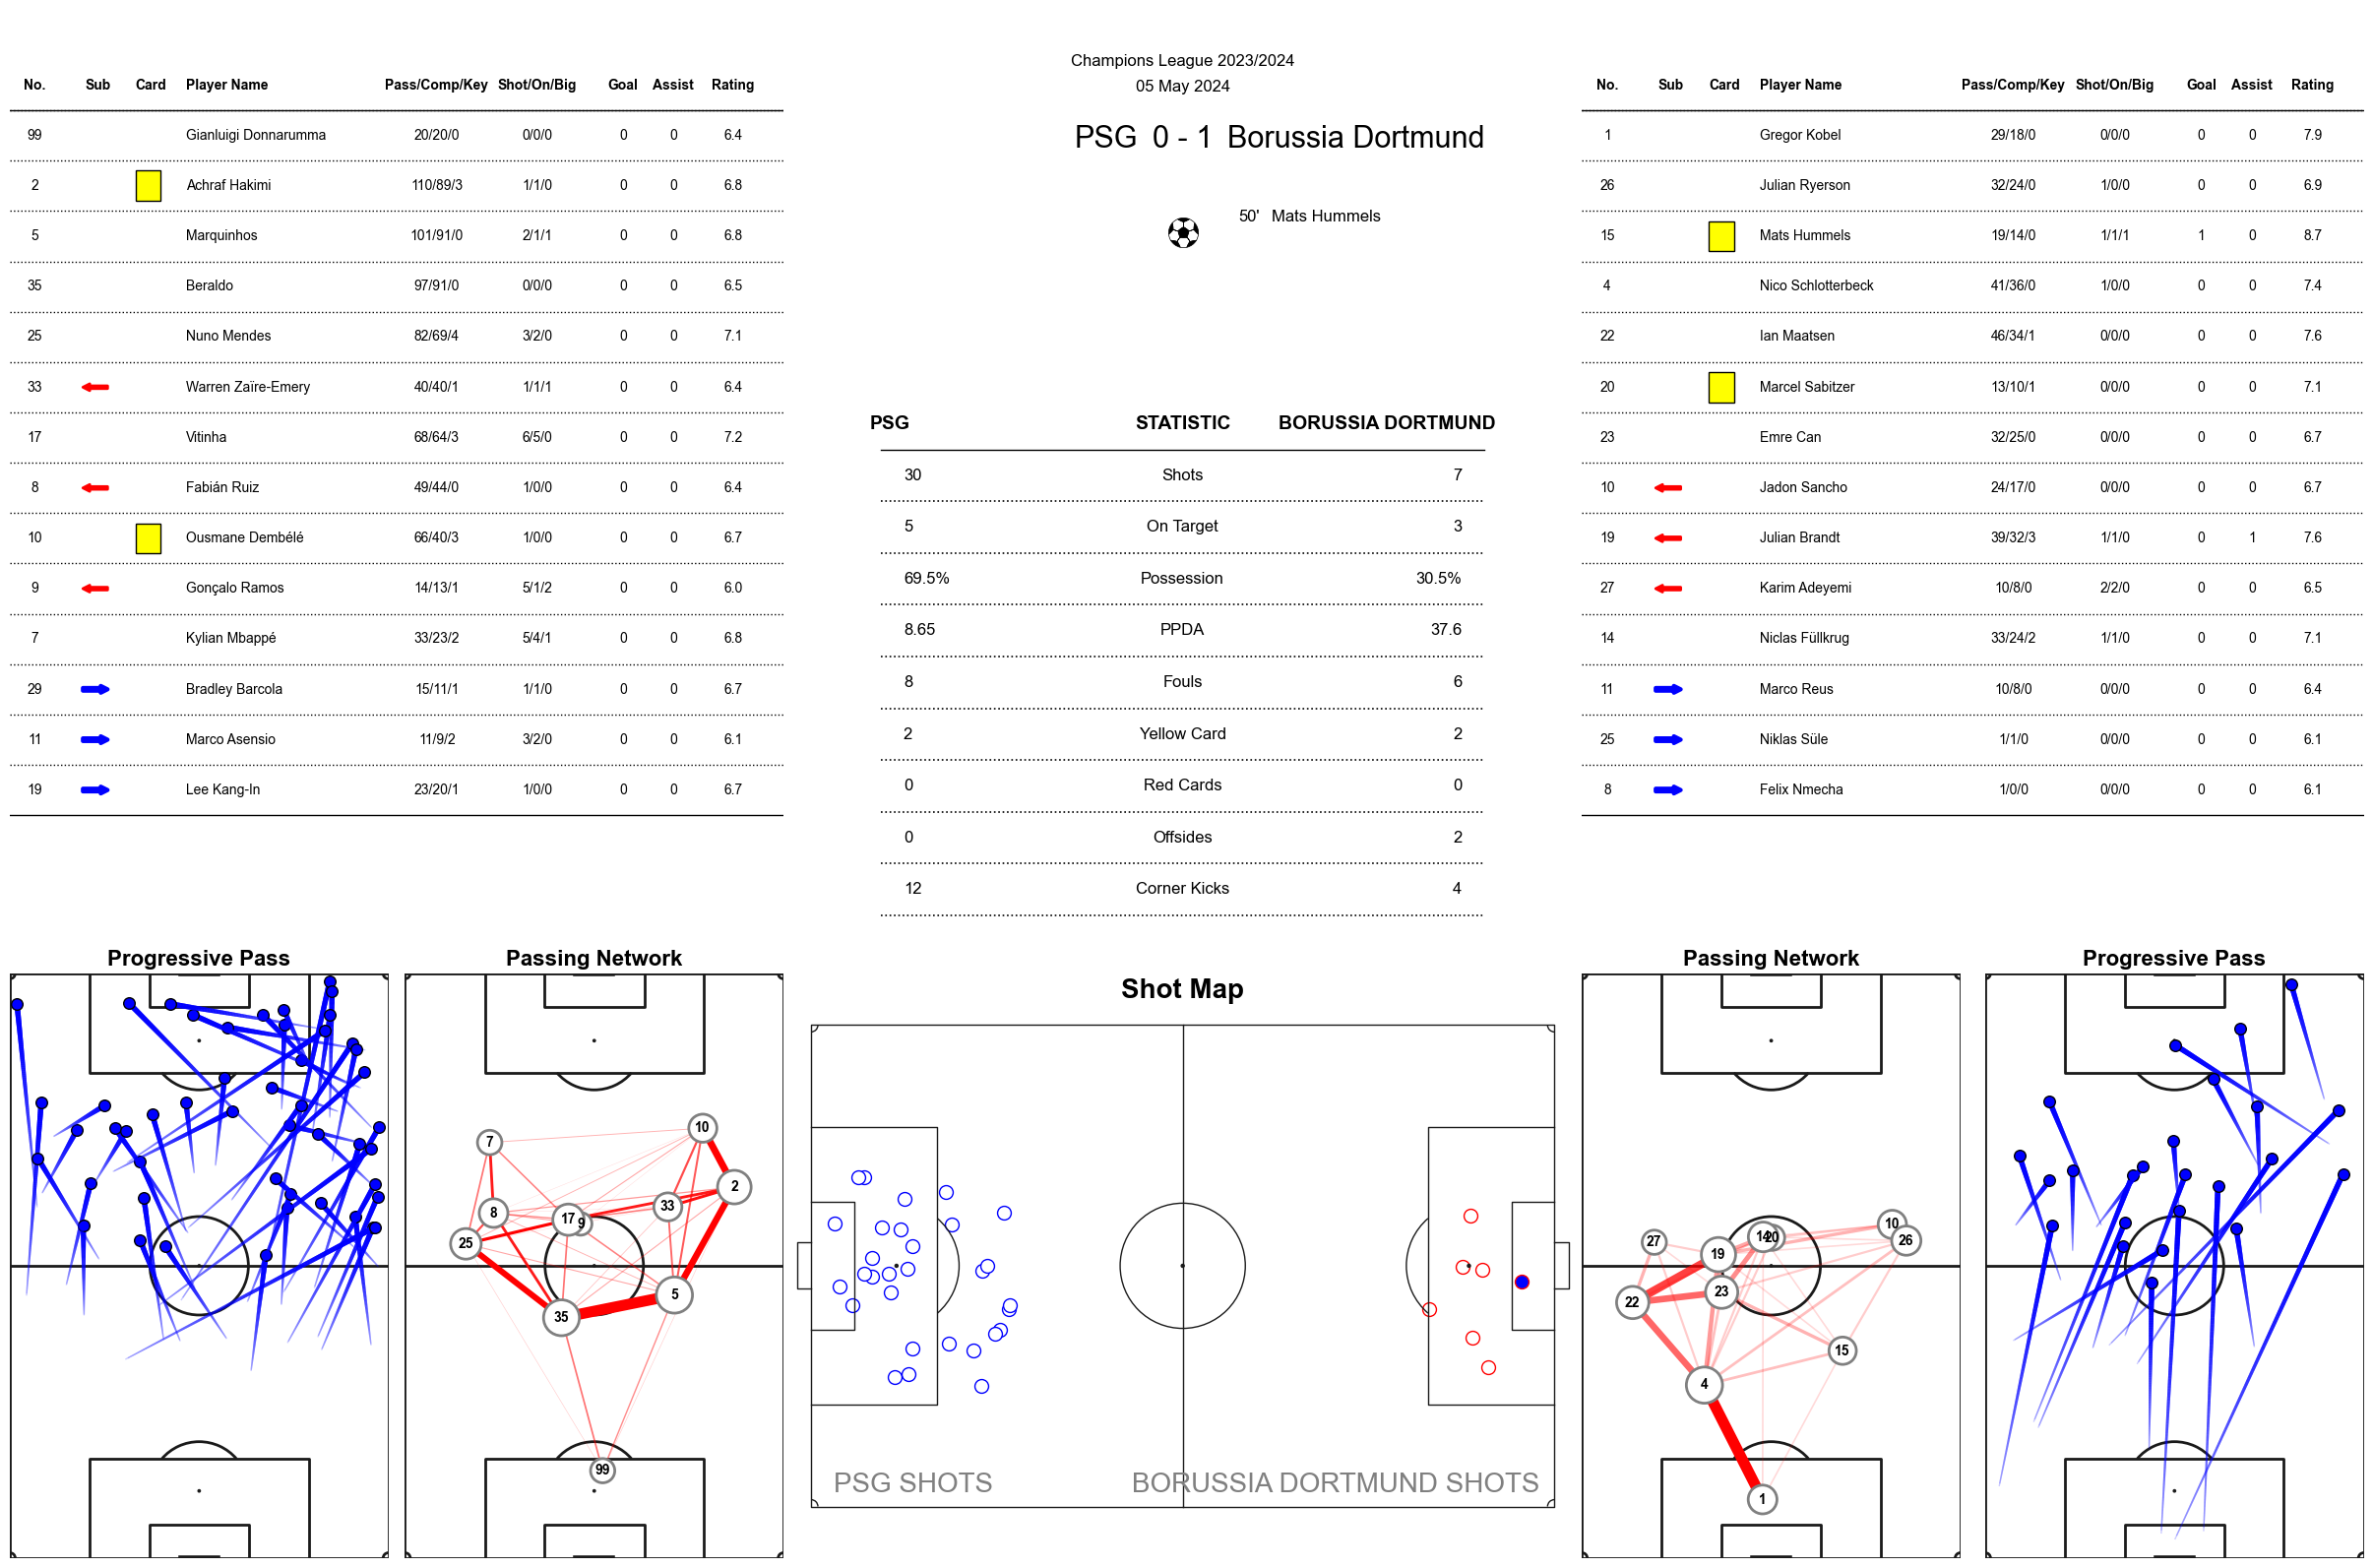

In [24]:
fig = plt.figure(figsize=(24,16), constrained_layout=True)
gs = fig.add_gridspec(nrows=5, ncols=12)

fig.set_facecolor('1')

plt.rcParams["font.family"] = "arial"
plt.rcParams["text.color"] = "0"
#path_eff = [path_effects.Stroke(linewidth=1, foreground='white'),
#            path_effects.Normal()]
#plt.rcParams["path.effects"] = path_eff

Home_Team = match_data['home']['name']
Away_Team = match_data['away']['name']

ax_match_stats = fig.add_subplot(gs[0:3, 4:8])
match_statistic(match_data=match_data, events_data=events_data, ax=ax_match_stats)

ax_player_stats_home = fig.add_subplot(gs[0:3, 0:4])
player_statistic(match_data=match_data, events_data=events_data, venue='home', ax=ax_player_stats_home)

ax_player_stats_away = fig.add_subplot(gs[0:3, 8:12])
player_statistic(match_data=match_data, events_data=events_data, venue='away', ax=ax_player_stats_away)

ax_shotmap = fig.add_subplot(gs[3:6,4:8])
if data_detail == 'complete':
    shotmap(df=understat_df, ax=ax_shotmap)
else:
    whoscored_shotmap(df=events_data, ax=ax_shotmap)
ax_shotmap.set_title('Shot Map', size=20, weight='bold')

ax_home_passing_network = fig.add_subplot(gs[3:6,2:4])
passing_network(ax=ax_home_passing_network, events_data=events_data, venue='home', match_data=match_data, TeamId=Home_Team_ID, Team=Home_Team)
ax_home_passing_network.set_title('Passing Network', size=16, weight='bold')

ax_away_passing_network = fig.add_subplot(gs[3:6,8:10])
passing_network(ax=ax_away_passing_network, events_data=events_data, venue='away', match_data=match_data, TeamId=Away_Team_ID, Team=Away_Team)
ax_away_passing_network.set_title('Passing Network', size=16, weight='bold')

ax_progressive_pass_home = fig.add_subplot(gs[3:6, 0:2])
progressive_pass(ax=ax_progressive_pass_home, events_data=events_data, venue='home')
ax_progressive_pass_home.set_title('Progressive Pass', size=16, weight='bold')

ax_progressive_pass_away = fig.add_subplot(gs[3:6, 10:12])
progressive_pass(ax=ax_progressive_pass_away, events_data=events_data, venue='away')
ax_progressive_pass_away.set_title('Progressive Pass', size=16, weight='bold')

In [ ]:
fig.savefig(f'D:\\Football\\Stats\\Dashboard\\{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

# Understat Data

In [ ]:
df = understat_df

In [ ]:
home_team = df.h_team[0]
away_team = df.a_team[0]

In [ ]:
home_shots = df[df.h_a == 'h'].reset_index(drop=True)
away_shots = df[df.h_a == 'a'].reset_index(drop=True)

In [ ]:
home_score = home_shots[home_shots.result == 'Goal'].count()['result'] + away_shots[away_shots.result == 'OwnGoal'].count()['result']
away_score = away_shots[away_shots.result == 'Goal'].count()['result'] + home_shots[home_shots.result == 'OwnGoal'].count()['result']
home_xG = home_shots.xG.sum()
away_xG = away_shots.xG.sum()
number_home_shots = len(home_shots)
number_away_shots = len(away_shots)
number_home_saved_shots = home_shots[(home_shots.result == 'SavedShot')].count()['result']
number_away_saved_shots = away_shots[(away_shots.result == 'SavedShot')].count()['result']
number_home_on_target = home_shots[(home_shots.result == 'SavedShot') | (home_shots.result == 'Goal')].count()['result']
number_away_on_target = away_shots[(away_shots.result == 'SavedShot') | (away_shots.result == 'Goal')].count()['result']
number_home_blockedshot = home_shots[home_shots.result == 'BlockedShot'].count()['result']
number_away_blockedshot = away_shots[away_shots.result == 'BlockedShot'].count()['result']
number_home_off_target = home_shots[home_shots.result == 'MissedShots'].count()['result']
number_away_off_target = away_shots[away_shots.result == 'MissedShots'].count()['result']
number_home_hitpost = home_shots[home_shots.result == 'ShotOnPost'].count()['result']
number_away_hitpost = away_shots[away_shots.result == 'ShotOnPost'].count()['result']

In [ ]:
number_home_openplay = home_shots[home_shots.situation == 'OpenPlay'].count()['situation']
number_away_openplay = away_shots[away_shots.situation == 'OpenPlay'].count()['situation']
number_home_fromcorner = home_shots[home_shots.situation == 'FromCorner'].count()['situation']
number_away_fromcorner = away_shots[away_shots.situation == 'FromCorner'].count()['situation']
number_home_penalty = home_shots[home_shots.situation == 'Penalty'].count()['situation']
number_away_penalty = away_shots[away_shots.situation == 'Penalty'].count()['situation']
number_home_setpiece = home_shots[home_shots.situation == 'SetPiece'].count()['situation']
number_away_setpiece = away_shots[away_shots.situation == 'SetPiece'].count()['situation']
number_home_directfreekick = home_shots[home_shots.situation == 'DirectFreekick'].count()['situation']
number_away_directfreekick = away_shots[away_shots.situation == 'DirectFreekick'].count()['situation']

## Shot Map

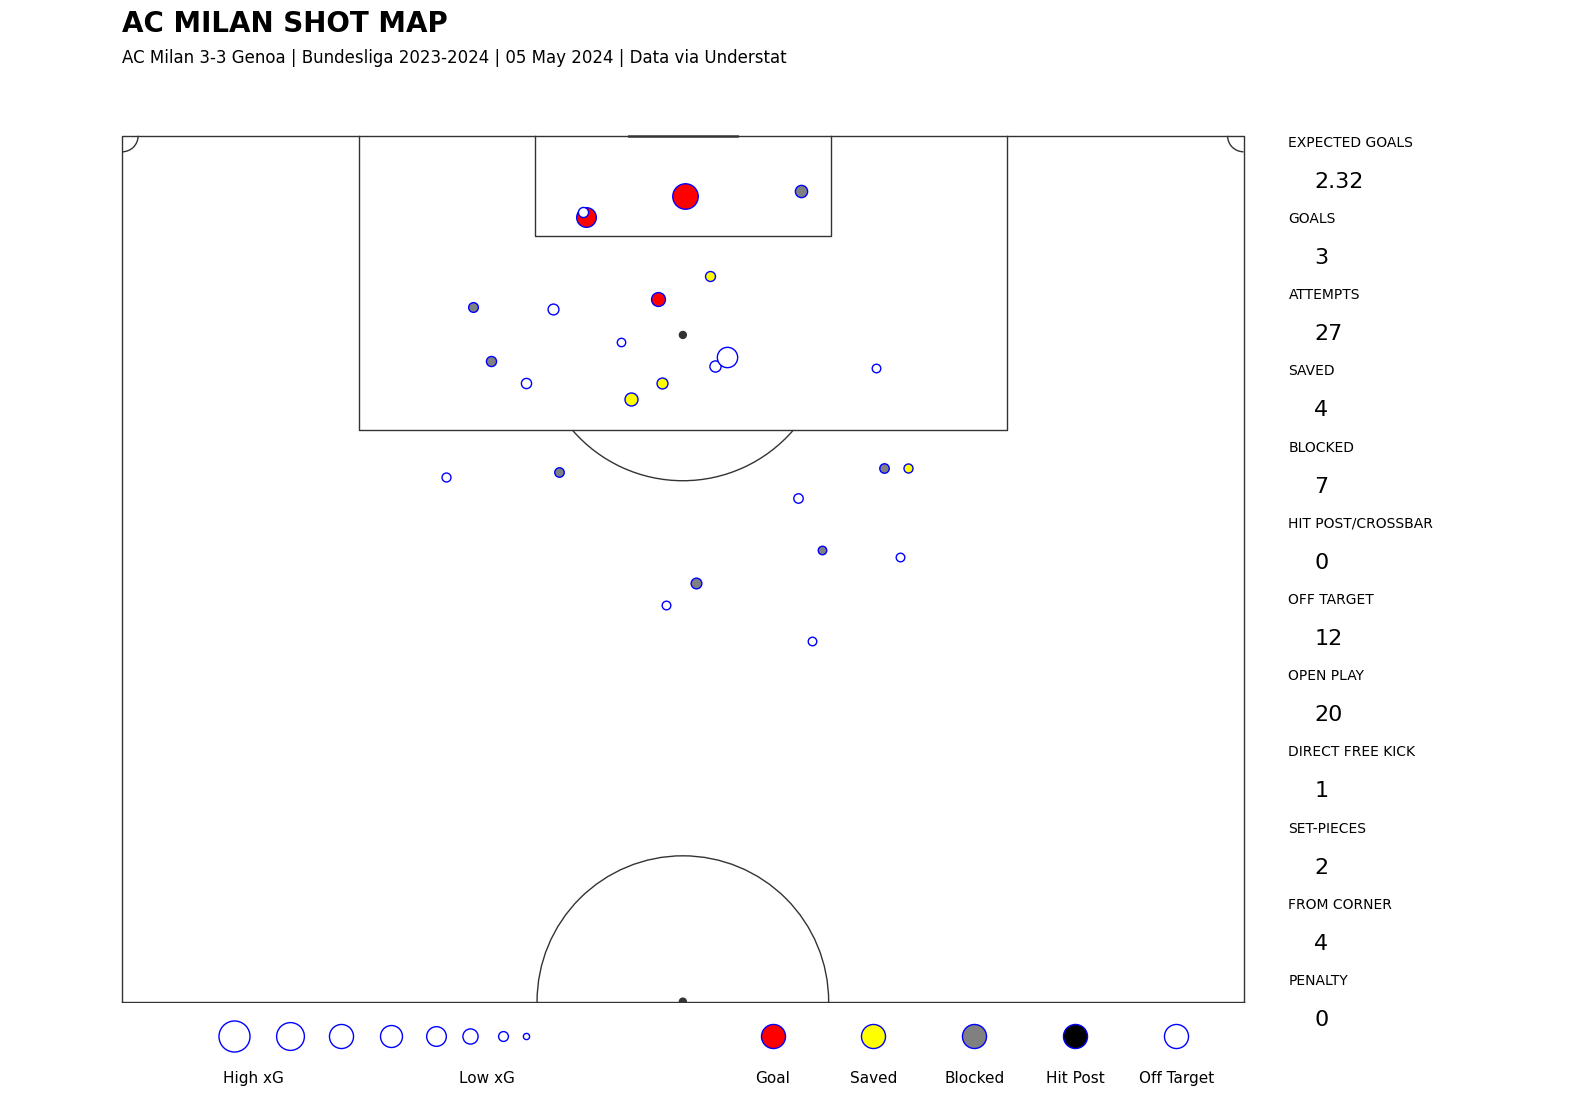

In [ ]:
data = home_shots
pitch = VerticalPitch(
    pitch_type = 'opta',
    half = True,
    goal_type = 'line',
    goal_alpha = 0.8,
    corner_arcs=True,
    line_color = '0.2',
    linewidth = 1,
    pad_top=10, pad_bottom=0.1, pad_left=10, pad_right=30,
)
fig, ax = plt.subplots(constrained_layout=False, tight_layout=True)
fig.set_size_inches(16, 12)
pitch.draw(ax=ax)

cmarkersize = 500

for i in range(len(data)):
    markersize = 30 + home_shots.xG[i] * cmarkersize

    if data.result[i] == 'Goal':
        if markersize < 100:
            markersize = 100
        markercolor = 'red'
    elif data.result[i] == 'SavedShot':
        markercolor = 'yellow'
    elif data.result[i] == 'BlockedShot':
        markercolor = '0.5'
    elif data.result[i] == 'MissedShots':
        markercolor = 'white'
    elif data.result[i] == 'ShotOnPost':
        markercolor = 'black'
    elif data.result[i] == 'OwnGoal':
        markercolor = 'red'
    else:
        markercolor='white'

    scatter = pitch.scatter(
        
        # Coordinates
        data.X[i] * 100,
        data.Y[i] * 100,
        # Size Between 100 and 300
        s = markersize,
        # Type of Marker
        marker = "o",
        # Color Marker
        c =  markercolor,
        # Color Marker Border
        edgecolors = 'blue',

        ax = ax
    )

# Title
plt.text(x=100, y=106, s=f'{home_team.upper()} SHOT MAP', size=20, weight='bold')
plt.text(x=100, y=105, size = 12, ha = 'left', va='top', linespacing=1.4,
    s = f'{home_team} {home_score}-{away_score} {away_team} | {competition} {season} | {match_date} | Data via Understat')

# Stats
y = 100
jarak = 4.4
size = 10
kiri = -4
plt.text(x=kiri, y=y, s='EXPECTED GOALS', size=size, va='top')
plt.text(x=kiri, y=y-1*jarak , s='GOALS', size=size, va='top')
plt.text(x=kiri, y=y-2*jarak, s='ATTEMPTS', size=size, va='top')
plt.text(x=kiri, y=y-3*jarak, s='SAVED', size=size, va='top')
plt.text(x=kiri, y=y-4*jarak, s='BLOCKED', size=size, va='top')
plt.text(x=kiri, y=y-5*jarak, s='HIT POST/CROSSBAR', size=size, va='top')
plt.text(x=kiri, y=y-6*jarak, s='OFF TARGET', size=size, va='top')
plt.text(x=kiri, y=y-7*jarak, s='OPEN PLAY', size=size, va='top')
plt.text(x=kiri, y=y-8*jarak, s='DIRECT FREE KICK', size=size, va='top')
plt.text(x=kiri, y=y-9*jarak, s='SET-PIECES', size=size, va='top')
plt.text(x=kiri, y=y-10*jarak, s='FROM CORNER', size=size, va='top')
plt.text(x=kiri, y=y-11*jarak, s='PENALTY', size=size, va='top')

x=kiri-2.3
y-=3
size=16
plt.text(x=x, y=y, size=size, s=round(home_xG, 2))
plt.text(x=x, y=y-jarak, size=size, s=home_score)
plt.text(x=x, y=y-2*jarak, size=size, s=number_home_shots)
plt.text(x=x, y=y-3*jarak, size=size, s=number_home_saved_shots)
plt.text(x=x, y=y-4*jarak, size=size, s=number_home_blockedshot)
plt.text(x=x, y=y-5*jarak, size=size, s=number_home_hitpost)
plt.text(x=x, y=y-6*jarak, size=size, s=number_home_off_target)
plt.text(x=x, y=y-7*jarak, size=size, s=number_home_openplay)
plt.text(x=x, y=y-8*jarak, size=size, s=number_home_directfreekick)
plt.text(x=x, y=y-9*jarak, size=size, s=number_home_setpiece)
plt.text(x=x, y=y-10*jarak, size=size, s=number_home_fromcorner)
plt.text(x=x, y=y-11*jarak, size=size, s=number_home_penalty)


# Legend
y = 48
x_xg = 85
plt.scatter(x=x_xg-21, y=y, s=20, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-19, y=y, s=50, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-16, y=y, s=120, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-13, y=y, s=200, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-9, y=y, s=250, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-4.5, y=y, s=300, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg, y=y, s=400, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg+5, y=y, s=500, c='white', edgecolors='blue', clip_on=False)
plt.text(x=91, y=y-2.7, s="High xG", size=11)
plt.text(x=70, y=y-2.7, s="Low xG", size=11)

x = 42
add = 9
text_size = 11
plt.scatter(x=x, y=y, s=300, c='red', edgecolors='blue', clip_on=False)
plt.scatter(x=x-add, y=y, s=300, c='yellow', edgecolors='blue', clip_on=False)
plt.scatter(x=x-2*add, y=y, s=300, c='0.5', edgecolors='blue', clip_on=False)
plt.scatter(x=x-3*add, y=y, s=300, c='black', edgecolors='blue', clip_on=False)
plt.scatter(x=x-4*add, y=y, s=300, c='white', edgecolors='blue', clip_on=False)
plt.text(x=x, y=y-2.7, s="Goal", size=text_size, ha='center')
plt.text(x=x-add, y=y-2.7, s="Saved", size=text_size, ha='center')
plt.text(x=x-2*add, y=y-2.7, s="Blocked", size=text_size, ha='center')
plt.text(x=x-3*add, y=y-2.7, s="Hit Post", size=text_size, ha='center')
plt.text(x=x-4*add, y=y-2.7, s="Off Target", size=text_size, ha='center')

fig = plt.gcf()
fig.savefig(f'D:\\Football\\Stats\\Shot Map\\{home_team}_Shot_Map_{home_team}_VS_{away_team}_{match_date}.png', dpi=400)

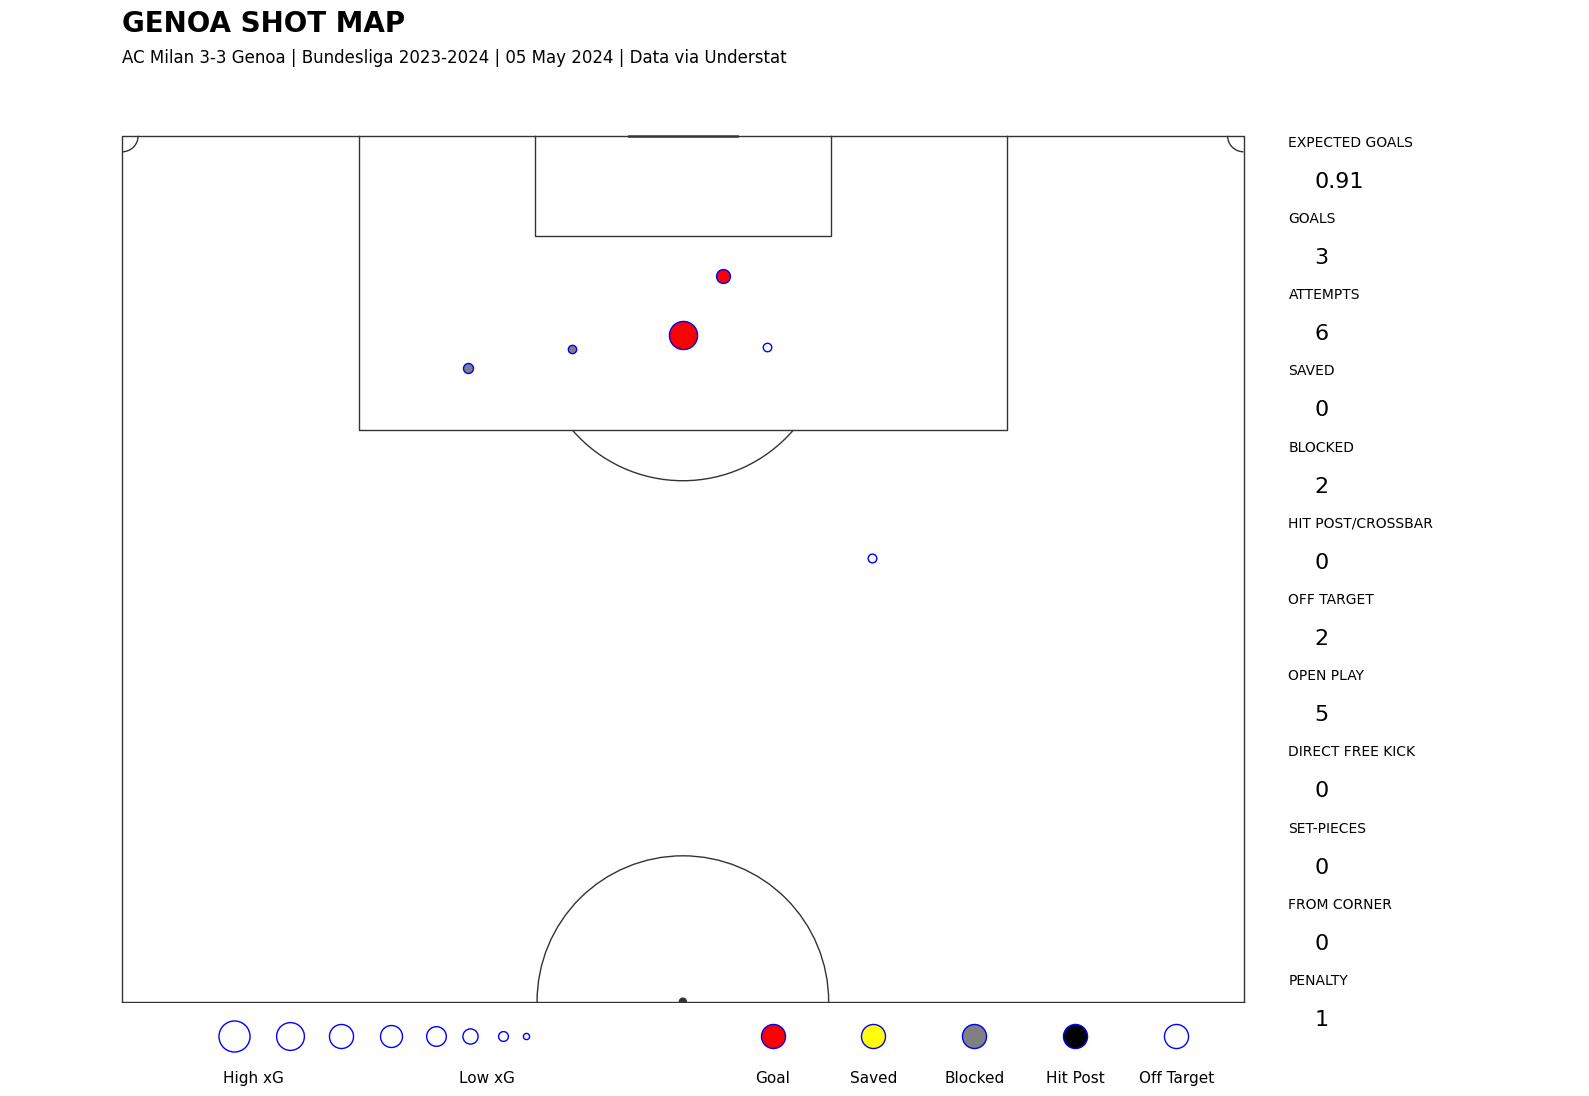

In [ ]:
data = away_shots
pitch = VerticalPitch(
    pitch_type = 'opta',
    half = True,
    goal_type = 'line',
    goal_alpha = 0.8,
    corner_arcs=True,
    line_color = '0.2',
    linewidth = 1,
    pad_top=10, pad_bottom=0.1, pad_left=10, pad_right=30,
)
fig, ax = plt.subplots(constrained_layout=True, tight_layout=True)
fig.set_size_inches(16, 12)
pitch.draw(ax=ax)

cmarkersize = 500

for i in range(len(data)):
    markersize = 30 + away_shots.xG[i] * cmarkersize

    if data.result[i] == 'Goal':
        if markersize < 100:
            markersize = 100
        markercolor = 'red'
    elif data.result[i] == 'SavedShot':
        markercolor = 'yellow'
    elif data.result[i] == 'BlockedShot':
        markercolor = '0.5'
    elif data.result[i] == 'MissedShots':
        markercolor = 'white'
    elif data.result[i] == 'ShotOnPost':
        markercolor = 'black'
    elif data.result[i] == 'OwnGoal':
        markercolor = 'red'
    else:
        markercolor='white'

    scatter = pitch.scatter(
        
        # Coordinates
        data.X[i] * 100,
        data.Y[i] * 100,
        # Size Between 100 and 300
        s = markersize,
        # Type of Marker
        marker = "o",
        # Color Marker
        c =  markercolor,
        # Color Marker Border
        edgecolors = 'blue',

        ax = ax
    )

# Title
plt.text(x=100, y=106, s=f'{away_team.upper()} SHOT MAP', size=20, weight='bold')
plt.text(x=100, y=105, size = 12, ha = 'left', va='top', linespacing=1.4,
    s = f'{home_team} {home_score}-{away_score} {away_team} | {competition} {season} | {match_date} | Data via Understat')

# Stats
y = 100
jarak = 4.4
size = 10
kiri = -4
plt.text(x=kiri, y=y, s='EXPECTED GOALS', size=size, va='top')
plt.text(x=kiri, y=y-1*jarak , s='GOALS', size=size, va='top')
plt.text(x=kiri, y=y-2*jarak, s='ATTEMPTS', size=size, va='top')
plt.text(x=kiri, y=y-3*jarak, s='SAVED', size=size, va='top')
plt.text(x=kiri, y=y-4*jarak, s='BLOCKED', size=size, va='top')
plt.text(x=kiri, y=y-5*jarak, s='HIT POST/CROSSBAR', size=size, va='top')
plt.text(x=kiri, y=y-6*jarak, s='OFF TARGET', size=size, va='top')
plt.text(x=kiri, y=y-7*jarak, s='OPEN PLAY', size=size, va='top')
plt.text(x=kiri, y=y-8*jarak, s='DIRECT FREE KICK', size=size, va='top')
plt.text(x=kiri, y=y-9*jarak, s='SET-PIECES', size=size, va='top')
plt.text(x=kiri, y=y-10*jarak, s='FROM CORNER', size=size, va='top')
plt.text(x=kiri, y=y-11*jarak, s='PENALTY', size=size, va='top')

x=kiri-2.3
y-=3
size=16
plt.text(x=x, y=y, size=size, s=round(away_xG, 2))
plt.text(x=x, y=y-jarak, size=size, s=away_score)
plt.text(x=x, y=y-2*jarak, size=size, s=number_away_shots)
plt.text(x=x, y=y-3*jarak, size=size, s=number_away_saved_shots)
plt.text(x=x, y=y-4*jarak, size=size, s=number_away_blockedshot)
plt.text(x=x, y=y-5*jarak, size=size, s=number_away_hitpost)
plt.text(x=x, y=y-6*jarak, size=size, s=number_away_off_target)
plt.text(x=x, y=y-7*jarak, size=size, s=number_away_openplay)
plt.text(x=x, y=y-8*jarak, size=size, s=number_away_directfreekick)
plt.text(x=x, y=y-9*jarak, size=size, s=number_away_setpiece)
plt.text(x=x, y=y-10*jarak, size=size, s=number_away_fromcorner)
plt.text(x=x, y=y-11*jarak, size=size, s=number_away_penalty)


# Legend
y = 48
x_xg = 85
plt.scatter(x=x_xg-21, y=y, s=20, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-19, y=y, s=50, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-16, y=y, s=120, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-13, y=y, s=200, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-9, y=y, s=250, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg-4.5, y=y, s=300, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg, y=y, s=400, c='white', edgecolors='blue', clip_on=False)
plt.scatter(x=x_xg+5, y=y, s=500, c='white', edgecolors='blue', clip_on=False)
plt.text(x=91, y=y-2.7, s="High xG", size=11)
plt.text(x=70, y=y-2.7, s="Low xG", size=11)

x = 42
add = 9
text_size = 11
plt.scatter(x=x, y=y, s=300, c='red', edgecolors='blue', clip_on=False)
plt.scatter(x=x-add, y=y, s=300, c='yellow', edgecolors='blue', clip_on=False)
plt.scatter(x=x-2*add, y=y, s=300, c='0.5', edgecolors='blue', clip_on=False)
plt.scatter(x=x-3*add, y=y, s=300, c='black', edgecolors='blue', clip_on=False)
plt.scatter(x=x-4*add, y=y, s=300, c='white', edgecolors='blue', clip_on=False)
plt.text(x=x, y=y-2.7, s="Goal", size=text_size, ha='center')
plt.text(x=x-add, y=y-2.7, s="Saved", size=text_size, ha='center')
plt.text(x=x-2*add, y=y-2.7, s="Blocked", size=text_size, ha='center')
plt.text(x=x-3*add, y=y-2.7, s="Hit Post", size=text_size, ha='center')
plt.text(x=x-4*add, y=y-2.7, s="Off Target", size=text_size, ha='center')

fig = plt.gcf()
fig.savefig(f'D:\\Football\\Stats\\Shot Map\\{away_team}_Shot_Map_{home_team}_VS_{away_team}_{match_date}.png', dpi=400)

## xG Match Story

In [ ]:
home_cum_xg = [0]
away_cum_xg = [0]

home_sum = 0
for i in range(len(home_shots)):
    home_sum += home_shots['xG'][i]
    home_cum_xg.append(home_sum)
    home_cum_xg.append(home_sum)

away_sum = 0
for i in range(len(away_shots)):
    away_sum += away_shots['xG'][i]
    away_cum_xg.append(away_sum)
    away_cum_xg.append(away_sum)

In [ ]:
home_minute_shot = []
away_minute_shot = []

for i in range(len(home_shots)):
    home_minute_shot.append(home_shots.minute[i])
    home_minute_shot.append(home_shots.minute[i])

for i in range(len(away_shots)):
    away_minute_shot.append(away_shots.minute[i])
    away_minute_shot.append(away_shots.minute[i])

home_minute_shot.append(df.minute.max())
away_minute_shot.append(df.minute.max())

In [ ]:
home_goal_minute = []
home_goal_cum_xG = []
for i in range(len(home_shots)):
    if home_shots['result'][i] == 'Goal':
        home_goal_minute.append(home_shots.minute[i])
        home_goal_cum_xG.append(home_cum_xg[i*2+1])
    else:
        pass

away_goal_minute = []
away_goal_cum_xG = []
for i in range(len(away_shots)):
    if away_shots['result'][i] == 'Goal':
        away_goal_minute.append(away_shots.minute[i])
        away_goal_cum_xG.append(away_cum_xg[i*2+1])
    else:
        pass

In [ ]:
if max(home_cum_xg) > max(away_cum_xg):
    max_xg = max(home_cum_xg)
else:
    max_xg = max(away_cum_xg)

In [ ]:
home_cum_xg[len(home_cum_xg) - 1]

2.3210496325045815

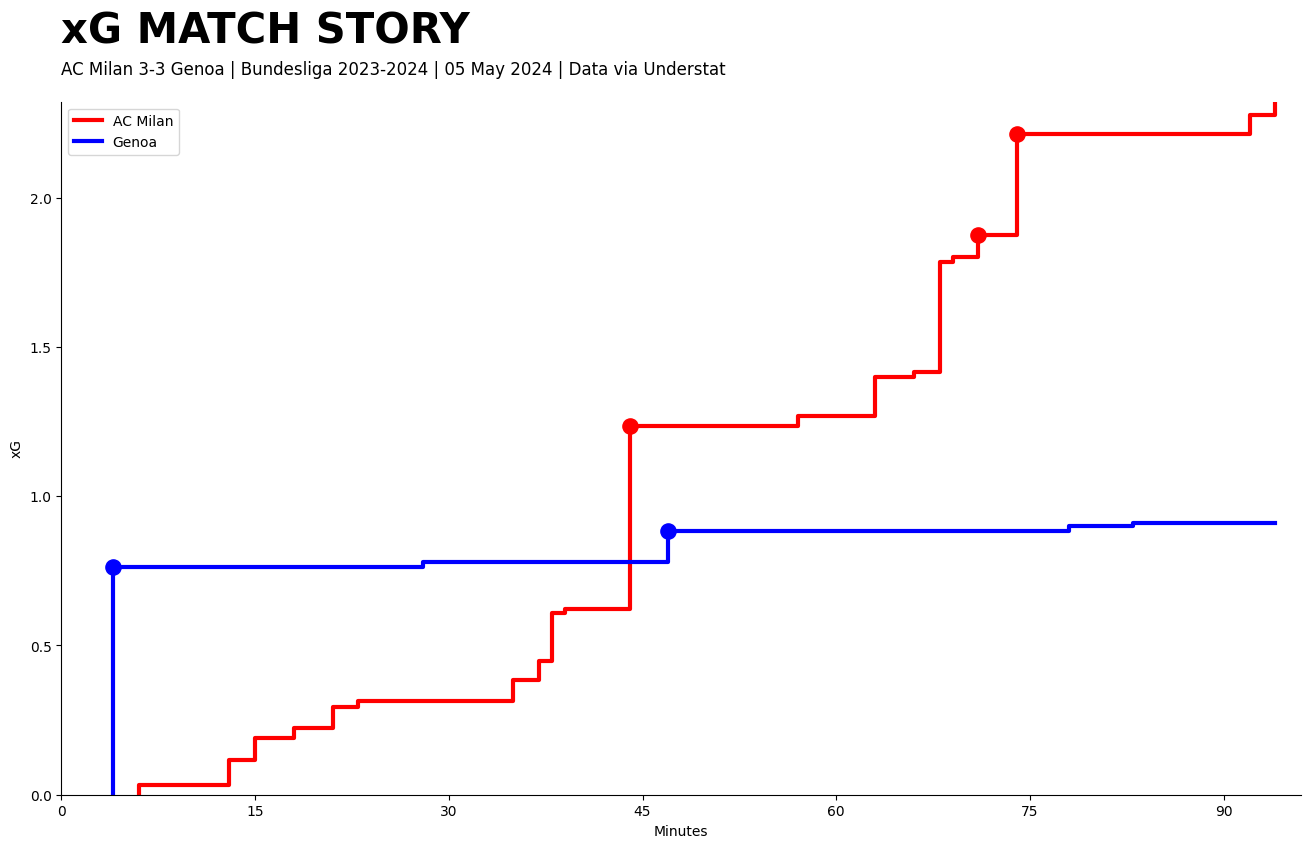

In [ ]:
lw = 3

fig, ax = plt.subplots()

#plt.subplots_adjust()
fig.set_size_inches(16, 9)

ax.plot(home_minute_shot, home_cum_xg, label=home_team, c='red', lw=lw)
ax.plot(away_minute_shot, away_cum_xg, label=away_team, c='blue', lw=lw)

ax.scatter(home_goal_minute, home_goal_cum_xG, c='red', s=120)
ax.scatter(away_goal_minute, away_goal_cum_xG, c='blue', s=120)

ax.spines["top"].set_color("None")
ax.spines["right"].set_color("None")

plt.text(0, max_xg + max_xg/7.5, s = "xG MATCH STORY", va='top', size=30, weight='bold')
plt.text(0, max_xg + max_xg/25, s = f"{home_team} {home_score}-{away_score} {away_team} | {competition} {season} | {match_date} | Data via Understat", size=12)

plt.xlabel('Minutes')
plt.ylabel('xG')

plt.legend(loc=2)

plt.xlim(0, max(df.minute) + 2 if (max(df.minute) + 2 > 90) else 90)
plt.ylim(0, max_xg)

plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.yticks(np.arange(0, max_xg, 0.5))

plt.show()

In [ ]:
fig.savefig(f'D:\\Football\\Stats\\xG Match Story\\{home_team}_VS_{away_team}_xG_Match_Story.png', dpi=400)

In [ ]:
.END

SyntaxError: invalid syntax (1403085297.py, line 1)

# WhoScored Data

In [ ]:
events_data = events_data.drop([0, 1]).reset_index(drop=True)
events_data = events_data[(events_data.period != 'PostGame') & (events_data.period != 'PreMatch') & (events_data.type != 'End')]

In [ ]:
match_data['score'].split()[0]

'0'

In [ ]:
Home_Team = match_data['home']['name']
Away_Team = match_data['away']['name']
Home_Team_ID = match_data['home']['teamId']
Away_Team_ID = match_data['away']['teamId']
Home_Score = int(match_data['score'].split()[0])
Away_Score = int(match_data['score'].split()[2])
Date = match_data['timeStamp'].split(' ')[0].split('-')[2] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[1] + '-' + match_data['timeStamp'].split(' ')[0].split('-')[0]
Competition = match_data['league']
Season = match_data['season']

In [ ]:
print('Home Team =', Home_Team)
print('Away Team =', Away_Team)
print('Home Team ID =', Home_Team_ID)
print('Away Team ID =', Away_Team_ID)
print('Home Score =', Home_Score)
print('Away Score ID =', Away_Score)
print('Date =', Date)
print('Competition =', Competition )
print('Season =', Season )

Home Team = PSG
Away Team = Borussia Dortmund
Home Team ID = 304
Away Team ID = 44
Home Score = 0
Away Score ID = 1
Date = 07-05-2024
Competition = Champions League
Season = 2023/2024


In [ ]:
jerseyNumber = pd.DataFrame({'jerseyNumber': match_data['home']['formations'][0]['jerseyNumbers'] + match_data['away']['formations'][0]['jerseyNumbers'],
                             'playerId': match_data['home']['formations'][0]['playerIds'] + match_data['away']['formations'][0]['playerIds']})

In [ ]:
playerIdNameDictionary = match_data['playerIdNameDictionary']
playerdict_df = pd.Series(playerIdNameDictionary).to_frame('playerName')
playerdict_df.index.name = 'playerId'
playerdict_df.index = playerdict_df.index.astype('int64')
jerseyNumber['playerId'] = jerseyNumber['playerId'].astype(object)
jerseyNumber = jerseyNumber.set_index('playerId')
kit_no = pd.merge(jerseyNumber, playerdict_df, on='playerId')

In [ ]:
events_data = pd.merge(left=events_data, right=jerseyNumber, on='playerId', how='left')

### Home Team

In [ ]:
Team = Home_Team
TeamId = Home_Team_ID
venue = 'home'

In [ ]:
starters_player_ids = []
for i in range(11):
    starters_player_ids.append(match_data[venue]['formations'][0]['playerIds'][i])

In [ ]:
playerIdNameDictionary = match_data['playerIdNameDictionary']

In [ ]:
starters = {}
for player_id in starters_player_ids:
    starters[player_id] = playerIdNameDictionary[str(player_id)]

In [ ]:
starters_player_name = []
for key in starters.keys():
    starters_player_name.append(starters[key])

In [ ]:
# Make df with Successfull Passes until the First Substitution
mask = (events_data.type == 'Pass') & (events_data.teamId == TeamId) & (events_data.outcomeType == 'Successful') & (events_data.throwIn != True)

In [ ]:
team_event = events_data[events_data['teamId'] == TeamId]

In [ ]:
team_event.insert(26, 'passRecipientName', value=team_event['playerName'].shift(-1))
team_event.insert(27, 'passRecipientId', value=team_event['playerId'].shift(-1))

In [ ]:
team_passes = team_event.loc[mask, ['x', 'y', 'endX', 'endY', 'playerName', 'jerseyNumber', 'passRecipientName']]

In [ ]:
team_passes = team_passes.query(f"playerName == {starters_player_name} & passRecipientName == {starters_player_name}")

In [ ]:
scatter_df = pd.DataFrame()

for i, name in enumerate(team_passes["playerName"].unique()):
    passx = team_passes.loc[team_passes["playerName"] == name]["x"].to_numpy()
    recx = team_passes.loc[team_passes["passRecipientName"] == name]["endX"].to_numpy()
    passy = team_passes.loc[team_passes["playerName"] == name]["y"].to_numpy()
    recy = team_passes.loc[team_passes["passRecipientName"] == name]["endY"].to_numpy()
    
    scatter_df.at[i, "player_name"] = name
    scatter_df.at[i, "jerseyNumber"] = events_data[events_data['playerName'] == name].iloc[0]['jerseyNumber']
    
    # Make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    
    # Calculate the Number of Passes
    scatter_df.at[i, "number_of_passes"] = team_passes.loc[team_passes["playerName"] == name].count().iloc[0]

# Adjust the size of Circle by Number of Passes
scatter_df['marker_size'] = (scatter_df['number_of_passes'] / scatter_df['number_of_passes'].max() * 500 + 200)

In [ ]:
# Counting passes between players
team_passes["pair_key"] = team_passes.apply(lambda x: "_".join(sorted([x["playerName"], x["passRecipientName"]])), axis=1)
lines_df = team_passes.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)

# Setting a Treshold of Number Passes
min_pass_count = 2
lines_df = lines_df[lines_df['pass_count'] > min_pass_count]

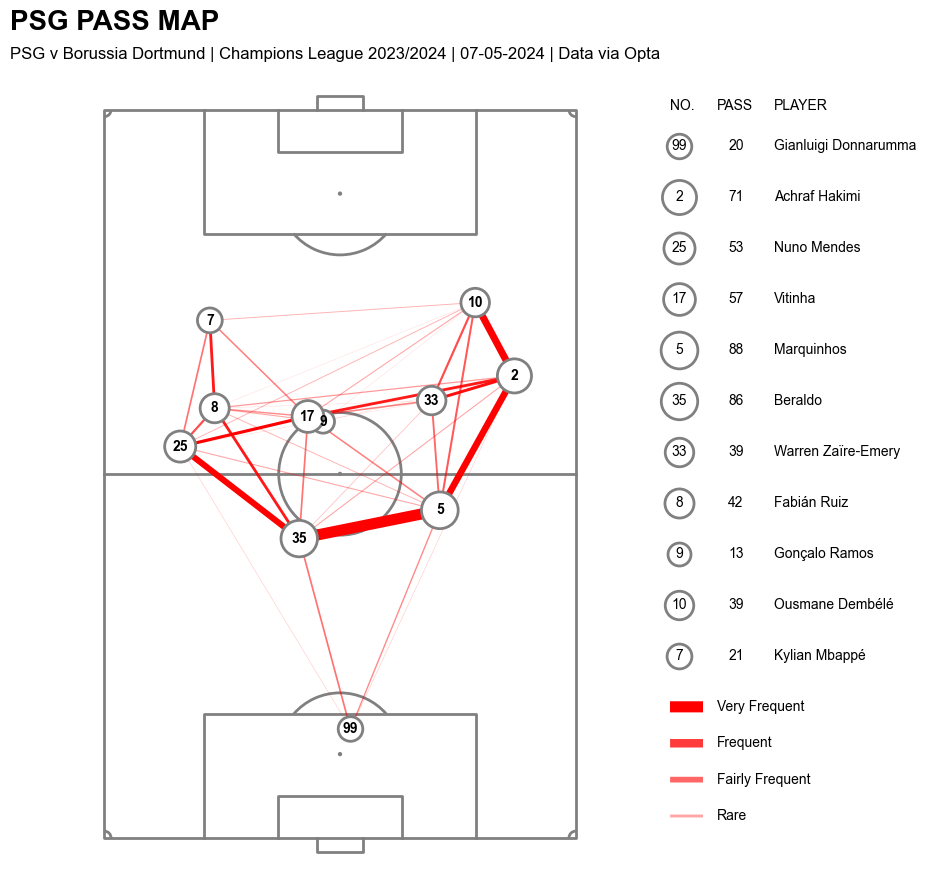

In [ ]:
color = 'white'

pitch = VerticalPitch(line_color='grey', pitch_type='opta', corner_arcs=True, goal_type='box',
                      pad_bottom=10, pad_top=10, pad_left=10, pad_right=70)
fig, ax = pitch.draw(constrained_layout=True, tight_layout=True)
fig.set_size_inches(12, 9)
fig.set_facecolor(color)

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color=color, edgecolors='grey', linewidth=2, alpha=1, ax=ax, zorder = 3)

for i, row in scatter_df.iterrows():
    pitch.annotate(int(row.jerseyNumber), xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=10, ax=ax, zorder = 4)

for i, row in lines_df.iterrows():
        link = row['pass_count']
        alpha = link / 20
        if alpha > 1:
            alpha = 1
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]

        # Take the Average Location of Players to Plot Line between Them 
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]

        # Adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 8)

        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=alpha, lw=line_width, zorder=2, color="red", ax = ax)

# Title
ax.text(120, 111, s=f'{Team.upper()} PASS MAP', size=20, weight='bold')
ax.text(120, 107, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

# Stats
ax.text(-20, 100, s='NO.', ha='left')
ax.text(-42, 100, s='PLAYER', ha='left')
ax.text(-30, 100, s='PASS', ha='left')

# Legend
pitch.lines(18, -20, 18, -27,
           color='red', lw=8, ax=ax)
ax.text(-30, 18, s='Very Frequent', ha='left', va='center')
pitch.lines(13, -20, 13, -27,
           color='red', transparent=True, alpha_start=0.6, alpha_end=0.6, lw=6, ax=ax)
ax.text(-30, 13, s='Frequent', ha='left', va='center')
pitch.lines(8, -20, 8, -27,
           color='red', transparent=True, alpha_start=0.4, alpha_end=0.4, lw=4, ax=ax)
ax.text(-30, 8, s='Fairly Frequent', ha='left', va='center')
pitch.lines(3, -20, 3, -27,
           color='red', transparent=True, alpha_start=0.2, alpha_end=0.2, lw=2, ax=ax)
ax.text(-30, 3, s='Rare', ha='left', va='center')

x, y = -22, 95
for i in range(11):
    player_name = starters_player_name[i]
    player_name_index = scatter_df.index[scatter_df['player_name'] == player_name].tolist()[0]
    plt.scatter(x, y, c=color, s=scatter_df.iloc[player_name_index]['marker_size'], edgecolors='grey', linewidth=2)
    ax.text(x, y, s=int(scatter_df.iloc[player_name_index]['jerseyNumber']), ha='center', va='center')
    ax.text(x-20, y, s=scatter_df.iloc[player_name_index]['player_name'], va='center')
    ax.text(x-12, y, s=int(scatter_df.iloc[player_name_index]['number_of_passes']), ha='center', va='center')
    y -= 7

plt.show()
fig.savefig(f'D:\\Football\\Stats\\Passing Network\\{Team}_Pass_Map_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

#### HeatMaps

d:\Programming\Code\venv\Lib\site-packages\mplsoccer\_pitch_plot.py:170: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  return sns.kdeplot(x=x, y=y, ax=ax, clip=self.kde_clip, **kwargs)


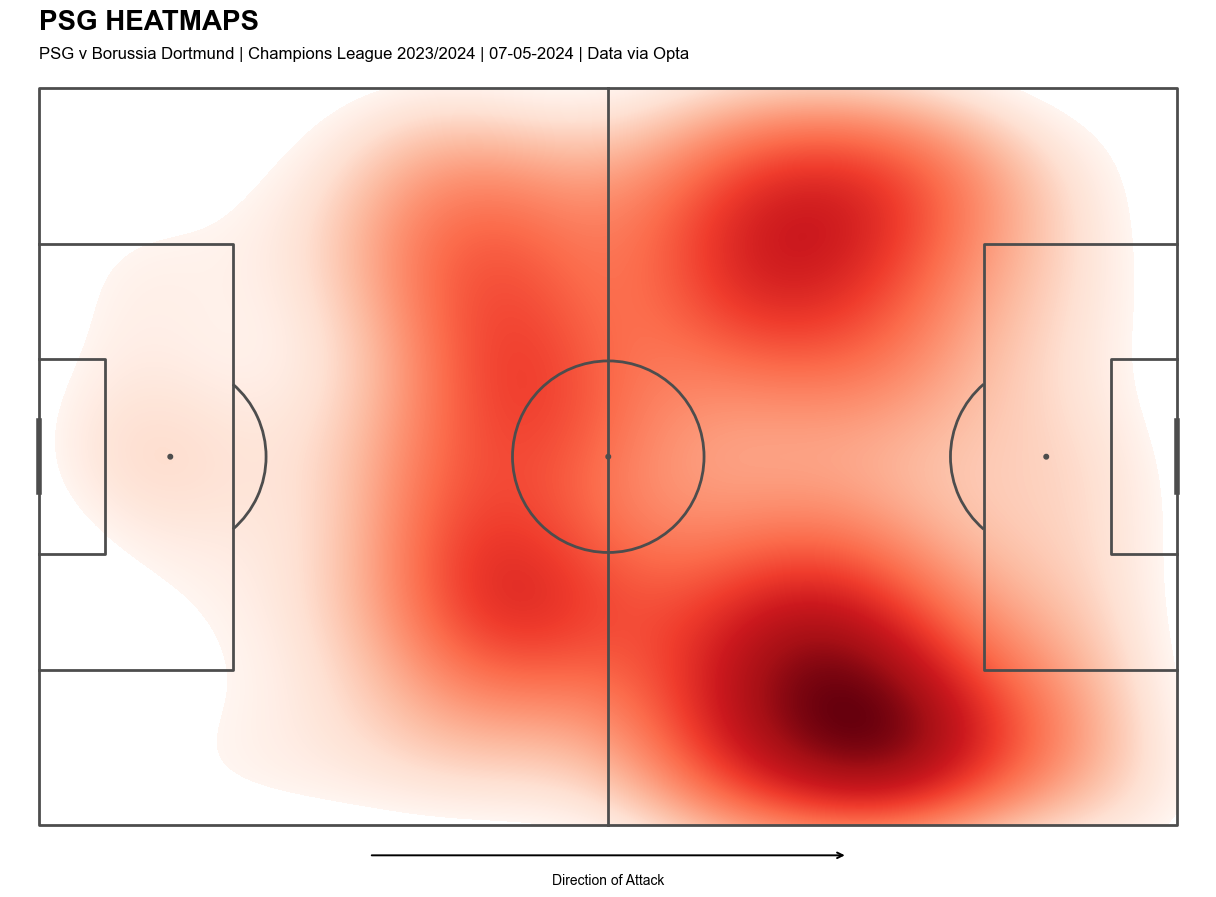

In [ ]:
pitch = Pitch(line_color='0.3', pitch_type='opta', line_zorder=2)
fig, ax = pitch.draw(constrained_layout=True, tight_layout=True)
fig.set_size_inches(16, 9)

customcmap = sns.light_palette("Navy", as_cmap=True)
pitch.kdeplot(
    team_event['x'], team_event['y'], ax=ax,
    cmap='Reds', shade=True, n_levels=10000, zorder=1
)

ax.annotate('', xy=(0.3, -0.001), xycoords='axes fraction', xytext=(0.7, -0.001),
arrowprops=dict(arrowstyle="<-", color='black', lw=1.4))
ax.text(50, -8, s='Direction of Attack', ha='center', size=10)

# Title
ax.text(0, 108, s=f'{Team.upper()} HEATMAPS', size=20, weight='bold')
ax.text(0, 104, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

plt.show()

In [ ]:
fig.savefig(f'D:\\Football\\Stats\\Heatmaps\\{Team}_Heatmaps_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

#### Passes Location

In [ ]:
passes = team_event[team_event.type == 'Pass']

In [ ]:
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

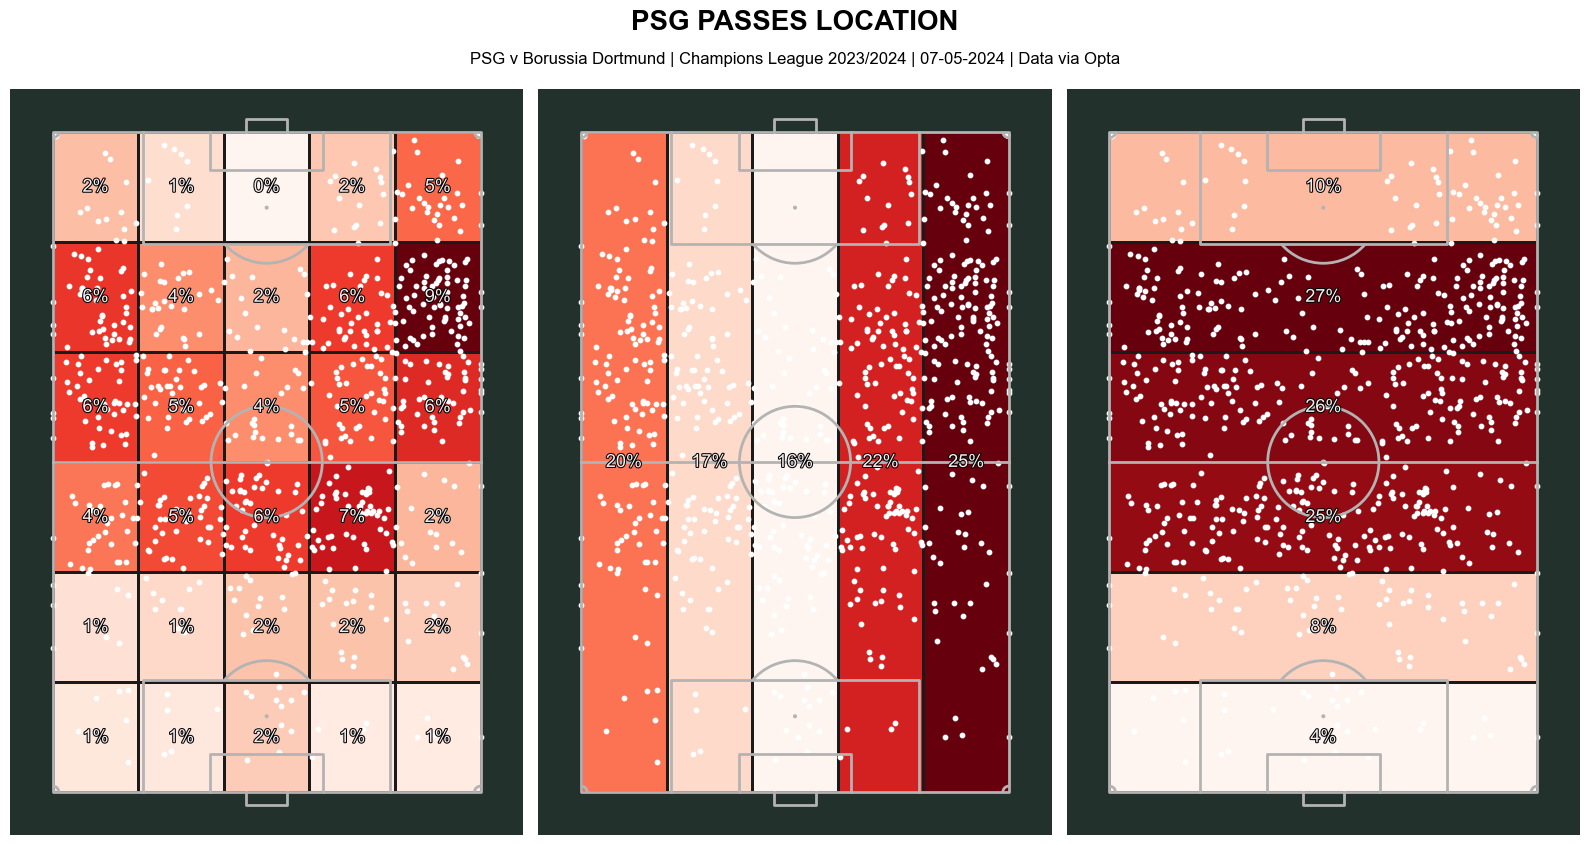

In [ ]:
color = 'white'

pitch = VerticalPitch(line_color='0.7', pitch_type='opta', corner_arcs=True, goal_type='box', line_zorder=2, pitch_color='#22312b',
                      pad_left=10, pad_right=10, pad_top=10, pad_bottom=10)
fig, axs = plt.subplots(1,3, constrained_layout=True, tight_layout=True)
fig.set_size_inches(16, 9)
fig.set_facecolor(color)

bins = [(6, 5), (1, 5), (6, 1)]
for i, bin in enumerate(bins):
    pitch.draw(ax=axs[i])
    bin_statistic = pitch.bin_statistic(passes.x, passes.y, statistic='count', bins=bin)
    pitch.heatmap(bin_statistic, ax=axs[i], cmap='Reds', edgecolors='0.1')
    pitch.scatter(passes.x, passes.y, c='white', s=10, ax=axs[i])
    bin_statistic['statistic'] = bin_statistic['statistic'] / bin_statistic['statistic'].sum()
    pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=13, ax=axs[i], ha='center', va='center', str_format='{:.0%}', path_effects=path_eff)

plt.suptitle(f'{Team.upper()} PASSES LOCATION', size=20, weight='bold', ha='center', x=0.5)
fig.text(0.5, 0.92, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12, ha='center')

plt.show()

In [ ]:
fig.savefig(f'D:\\Football\\Stats\\Passes Location\\{Team}_Passes_Location_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

### Away Team

In [ ]:
Team = Away_Team
TeamId = Away_Team_ID
venue = 'away'

In [ ]:
starters_player_ids = []
for i in range(11):
    starters_player_ids.append(match_data[venue]['formations'][0]['playerIds'][i])

In [ ]:
playerIdNameDictionary = match_data['playerIdNameDictionary']

In [ ]:
starters = {}
for player_id in starters_player_ids:
    starters[player_id] = playerIdNameDictionary[str(player_id)]

In [ ]:
starters_player_name = []
for key in starters.keys():
    starters_player_name.append(starters[key])

In [ ]:
# Make df with Successfull Passes until the First Substitution
mask = (events_data.type == 'Pass') & (events_data.teamId == TeamId) & (events_data.outcomeType == 'Successful') & (events_data.throwIn != True)

In [ ]:
team_event = events_data[events_data['teamId'] == TeamId]

In [ ]:
team_event.insert(26, 'passRecipientName', value=team_event['playerName'].shift(-1))
team_event.insert(27, 'passRecipientId', value=team_event['playerId'].shift(-1))

In [ ]:
team_passes = team_event.loc[mask, ['x', 'y', 'endX', 'endY', 'playerName', 'jerseyNumber', 'passRecipientName']]

In [ ]:
team_passes = team_passes.query(f"playerName == {starters_player_name} & passRecipientName == {starters_player_name}")

In [ ]:
scatter_df = pd.DataFrame()

for i, name in enumerate(team_passes["playerName"].unique()):
    passx = team_passes.loc[team_passes["playerName"] == name]["x"].to_numpy()
    recx = team_passes.loc[team_passes["passRecipientName"] == name]["endX"].to_numpy()
    passy = team_passes.loc[team_passes["playerName"] == name]["y"].to_numpy()
    recy = team_passes.loc[team_passes["passRecipientName"] == name]["endY"].to_numpy()
    
    scatter_df.at[i, "player_name"] = name
    scatter_df.at[i, "jerseyNumber"] = events_data[events_data['playerName'] == name].iloc[0]['jerseyNumber']
    
    # Make sure that x and y location for each circle representing the player is the average of passes and receptions
    scatter_df.at[i, "x"] = np.mean(np.concatenate([passx, recx]))
    scatter_df.at[i, "y"] = np.mean(np.concatenate([passy, recy]))
    
    # Calculate the Number of Passes
    scatter_df.at[i, "number_of_passes"] = team_passes.loc[team_passes["playerName"] == name].count().iloc[0]

# Adjust the size of Circle by Number of Passes
scatter_df['marker_size'] = (scatter_df['number_of_passes'] / scatter_df['number_of_passes'].max() * 500 + 200)

In [ ]:
# Counting passes between players
team_passes["pair_key"] = team_passes.apply(lambda x: "_".join(sorted([x["playerName"], x["passRecipientName"]])), axis=1)
lines_df = team_passes.groupby(["pair_key"]).x.count().reset_index()
lines_df.rename({'x':'pass_count'}, axis='columns', inplace=True)

# Setting a Treshold of Number Passes
min_pass_count = 2
lines_df = lines_df[lines_df['pass_count'] > min_pass_count]

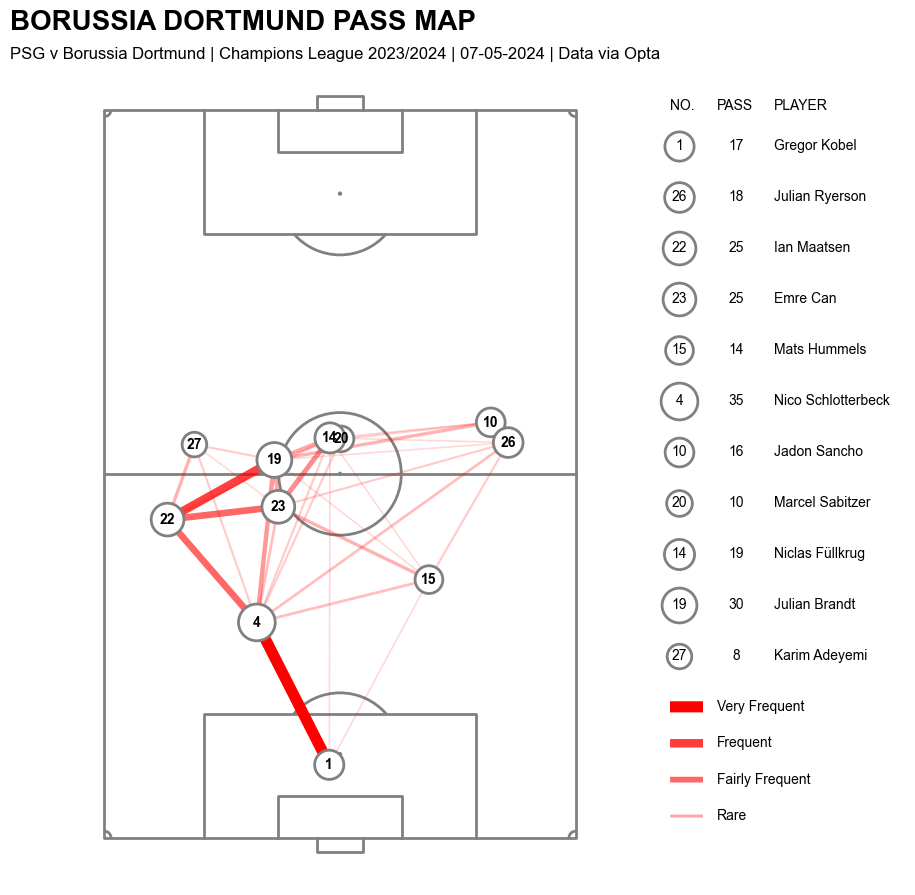

In [ ]:
color = 'white'

pitch = VerticalPitch(line_color='grey', pitch_type='opta', corner_arcs=True, goal_type='box',
                      pad_bottom=10, pad_top=10, pad_left=10, pad_right=70)
fig, ax = pitch.draw(constrained_layout=True, tight_layout=True)
fig.set_size_inches(12, 9)
fig.set_facecolor(color)

pitch.scatter(scatter_df.x, scatter_df.y, s=scatter_df.marker_size, color=color, edgecolors='grey', linewidth=2, alpha=1, ax=ax, zorder = 3)

for i, row in scatter_df.iterrows():
    pitch.annotate(int(row.jerseyNumber), xy=(row.x, row.y), c='black', va='center', ha='center', weight = "bold", size=10, ax=ax, zorder = 4)

for i, row in lines_df.iterrows():
        link = row['pass_count']
        alpha = link / 20
        if alpha > 1:
            alpha = 1
        player1 = row["pair_key"].split("_")[0]
        player2 = row['pair_key'].split("_")[1]

        # Take the Average Location of Players to Plot Line between Them 
        player1_x = scatter_df.loc[scatter_df["player_name"] == player1]['x'].iloc[0]
        player1_y = scatter_df.loc[scatter_df["player_name"] == player1]['y'].iloc[0]
        player2_x = scatter_df.loc[scatter_df["player_name"] == player2]['x'].iloc[0]
        player2_y = scatter_df.loc[scatter_df["player_name"] == player2]['y'].iloc[0]
        num_passes = row["pass_count"]

        # Adjust the line width so that the more passes, the wider the line
        line_width = (num_passes / lines_df['pass_count'].max() * 8)

        #plot lines on the pitch
        pitch.lines(player1_x, player1_y, player2_x, player2_y,
                    alpha=alpha, lw=line_width, zorder=2, color="red", ax = ax)

# Title
ax.text(120, 111, s=f'{Team.upper()} PASS MAP', size=20, weight='bold')
ax.text(120, 107, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

# Stats
ax.text(-20, 100, s='NO.', ha='left')
ax.text(-42, 100, s='PLAYER', ha='left')
ax.text(-30, 100, s='PASS', ha='left')

# Legend
pitch.lines(18, -20, 18, -27,
           color='red', lw=8, ax=ax)
ax.text(-30, 18, s='Very Frequent', ha='left', va='center')
pitch.lines(13, -20, 13, -27,
           color='red', transparent=True, alpha_start=0.6, alpha_end=0.6, lw=6, ax=ax)
ax.text(-30, 13, s='Frequent', ha='left', va='center')
pitch.lines(8, -20, 8, -27,
           color='red', transparent=True, alpha_start=0.4, alpha_end=0.4, lw=4, ax=ax)
ax.text(-30, 8, s='Fairly Frequent', ha='left', va='center')
pitch.lines(3, -20, 3, -27,
           color='red', transparent=True, alpha_start=0.2, alpha_end=0.2, lw=2, ax=ax)
ax.text(-30, 3, s='Rare', ha='left', va='center')

x, y = -22, 95
for i in range(11):
    player_name = starters_player_name[i]
    player_name_index = scatter_df.index[scatter_df['player_name'] == player_name].tolist()[0]
    plt.scatter(x, y, c=color, s=scatter_df.iloc[player_name_index]['marker_size'], edgecolors='grey', linewidth=2)
    ax.text(x, y, s=int(scatter_df.iloc[player_name_index]['jerseyNumber']), ha='center', va='center')
    ax.text(x-20, y, s=scatter_df.iloc[player_name_index]['player_name'], va='center')
    ax.text(x-12, y, s=int(scatter_df.iloc[player_name_index]['number_of_passes']), ha='center', va='center')
    y -= 7

plt.show()
fig.savefig(f'D:\\Football\\Stats\\Passing Network\\{Team}_Pass_Map_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

#### Heatmaps

d:\Programming\Code\venv\Lib\site-packages\mplsoccer\_pitch_plot.py:170: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  return sns.kdeplot(x=x, y=y, ax=ax, clip=self.kde_clip, **kwargs)


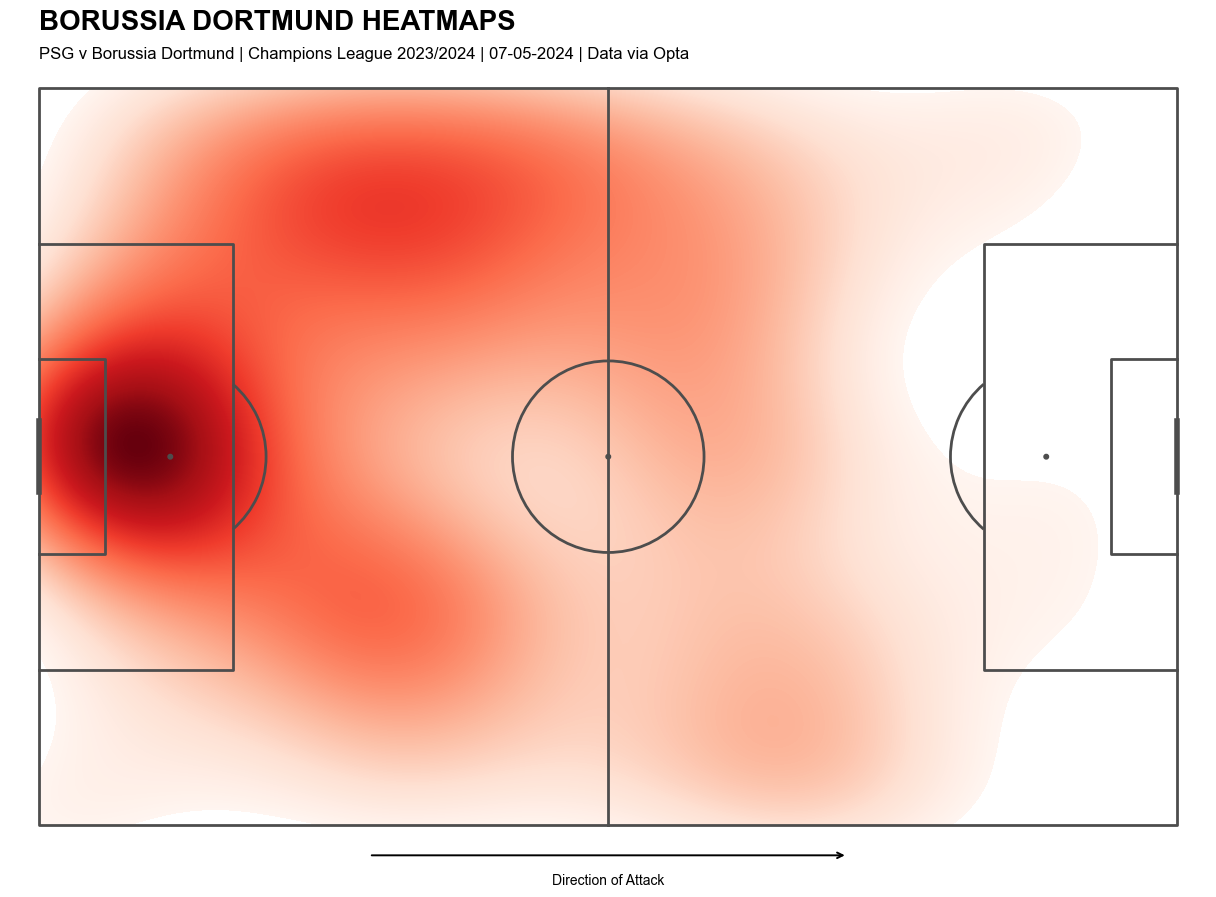

In [ ]:
pitch = Pitch(line_color='0.3', pitch_type='opta', line_zorder=2)
fig, ax = pitch.draw(constrained_layout=False, tight_layout=True)
fig.set_size_inches(16, 9)

pitch.kdeplot(
    team_event['x'], team_event['y'], ax=ax,
    cmap='Reds', shade=True, n_levels=10000, zorder=1
)

ax.annotate('', xy=(0.3, -0.001), xycoords='axes fraction', xytext=(0.7, -0.001),
arrowprops=dict(arrowstyle="<-", color='black', lw=1.4))
ax.text(50, -8, s='Direction of Attack', ha='center', size=10)

# Title
ax.text(0, 108, s=f'{Team.upper()} HEATMAPS', size=20, weight='bold')
ax.text(0, 104, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

plt.show()

In [ ]:
fig.savefig(f'D:\\Football\\Stats\\Heatmaps\\{Team}_Heatmaps_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

#### Passes Location

In [ ]:
passes = team_event[team_event.type == 'Pass']

In [ ]:
path_eff = [path_effects.Stroke(linewidth=1.5, foreground='black'),
            path_effects.Normal()]

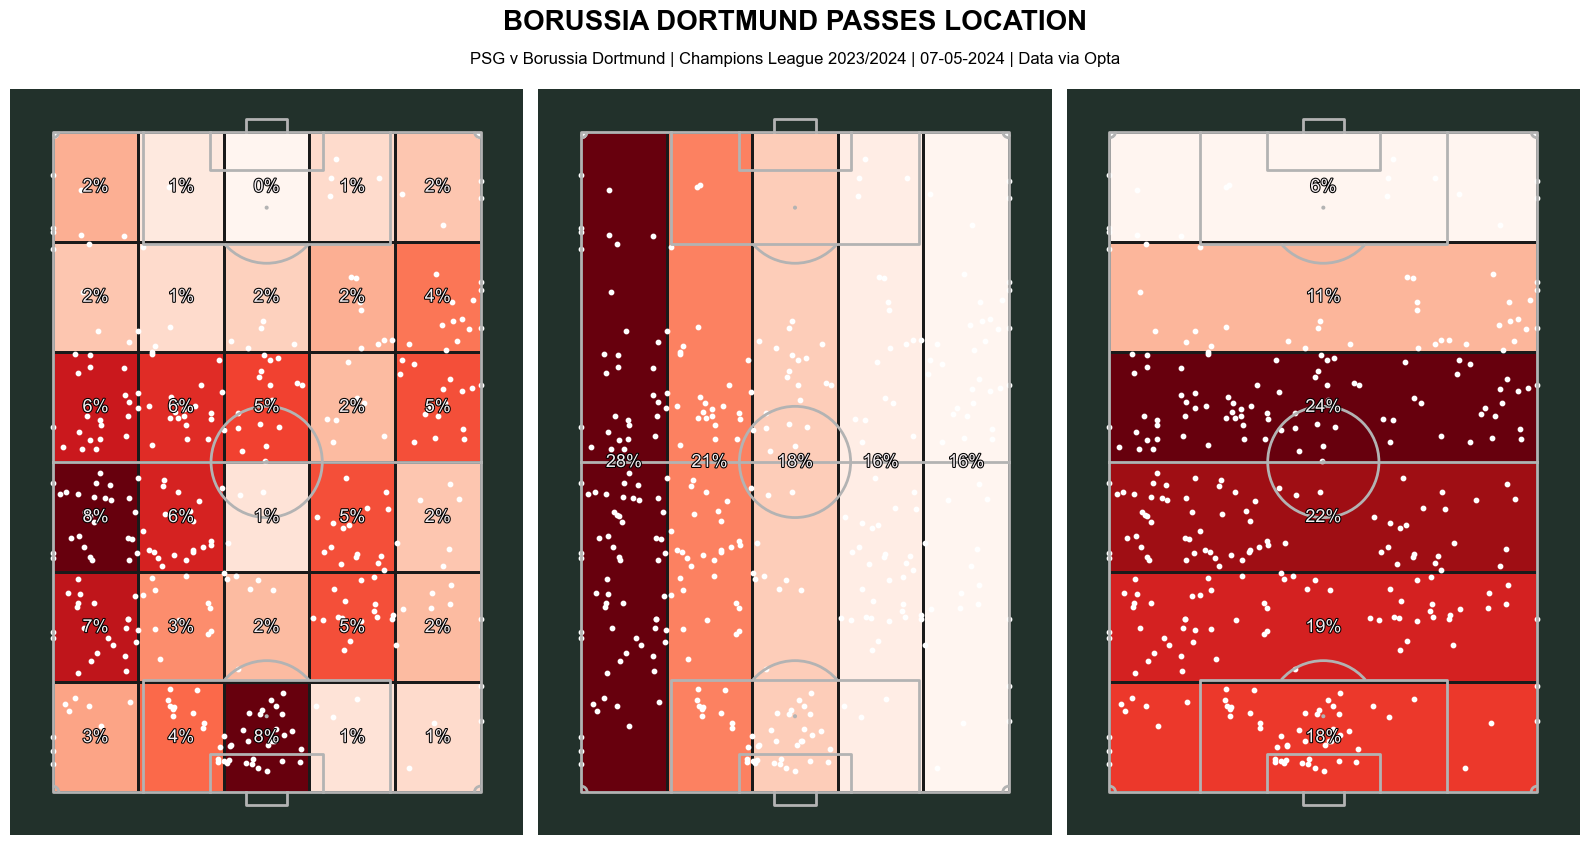

2


In [ ]:
color = 'white'

pitch = VerticalPitch(line_color='0.7', pitch_type='opta', corner_arcs=True, goal_type='box', line_zorder=2, pitch_color='#22312b',
                      pad_left=10, pad_right=10, pad_top=10, pad_bottom=10)
fig, axs = plt.subplots(1,3, constrained_layout=True, tight_layout=True)
fig.set_size_inches(16, 9)
fig.set_facecolor(color)

bins = [(6, 5), (1, 5), (6, 1)]
for i, bin in enumerate(bins):
    pitch.draw(ax=axs[i])
    bin_statistic = pitch.bin_statistic(passes.x, passes.y, statistic='count', bins=bin)
    pitch.heatmap(bin_statistic, ax=axs[i], cmap='Reds', edgecolors='0.1')
    pitch.scatter(passes.x, passes.y, c='white', s=10, ax=axs[i])
    bin_statistic['statistic'] = bin_statistic['statistic'] / bin_statistic['statistic'].sum()
    pitch.label_heatmap(bin_statistic, color='#f4edf0', fontsize=13, ax=axs[i], ha='center', va='center', str_format='{:.0%}', path_effects=path_eff)

plt.suptitle(f'{Team.upper()} PASSES LOCATION', size=20, weight='bold', ha='center', x=0.5)
fig.text(0.5, 0.92, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12, ha='center')

plt.show()
print(i)

In [ ]:
fig.savefig(f'D:\\Football\\Stats\\Passes Location\\{Team}_Passes_Location_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

## Team Stats

## Player Stats

### Home

In [ ]:
playerId = match_data['home']['formations'][0]['playerIds']
playerIdNameDictionary = match_data['playerIdNameDictionary']
home_player = []
for id in playerId:
    home_player.append(playerIdNameDictionary[str(id)])

In [ ]:
team_events = events_data[events_data['h_a'] == 'h']

In [ ]:
Passing = team_events[team_events['type'] == 'Pass'].reset_index(drop=True)
passes_attempted = Passing.groupby('playerName')[['type']].count()
passes_completed = Passing[Passing['outcomeType'] == 'Successful'].groupby('playerName')[['outcomeType']].count()
key_passes = {}
for name in home_player:
    key_passes[name] = 0
    for i in range(len(Passing)): 
        if Passing.iloc[i]['playerName'] == name:
            if Passing.iloc[i]['keyPassLong'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassShort'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassCross'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassCorner'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassThroughball'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassFreekick'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassThrowin'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassOther'] == True:
                key_passes[name] += 1
            else:
                pass
        else:
            pass
key_passes = pd.DataFrame.from_dict(key_passes, orient='index')
key_passes.index.name = 'playerName'
assist = team_events.groupby('playerName')[['assist']].sum()
PASSING = pd.merge(passes_attempted, passes_completed, on='playerName', how='outer')
PASSING = pd.merge(PASSING, key_passes, on='playerName', how='outer')
PASSING = pd.merge(PASSING, assist, on='playerName', how='outer')
PASSING = PASSING.rename(columns={'type': 'Attempted', 'outcomeType': 'Successful', 0: 'Key'})
PASSING = PASSING.reindex(home_player)
PASSING = PASSING.fillna(0)
PASSING = PASSING.astype(int)

In [ ]:
Shooting = team_events[(team_events['type'] == 'Goal') | (team_events['type'] == 'MissedShots') | (team_events['type'] == 'SavedShot') | (team_events['type'] == 'ShotOnPost')].reset_index(drop=True)
attempted = Shooting.groupby('playerName')[['type']].count().rename(columns={'type': 'Attempted'})
#on_target = Shooting.groupby('playerName')['type'].apply(lambda x: (x=='SavedShot').sum()).reset_index(name='On Target')
on_target = Shooting.groupby('playerName')[['shotOnTarget']].sum()
goal = team_events[(team_events['type'] == 'Goal')].groupby('playerName')[['type']].count().rename(columns={'type': 'Goal'})
SHOOTING = pd.merge(pd.merge(attempted, on_target, on='playerName', how='outer'), goal, on='playerName', how='outer')

In [ ]:
clearance = team_events[team_events['type'] == 'Clearance'].groupby('playerName')[['type']].count().rename(columns={'type': 'Clearance'})
interception = team_events[team_events['type'] == 'Interception'].groupby('playerName')[['type']].count().rename(columns={'type': 'Interception'})
tackle = team_events[team_events['type'] == 'Tackle'].groupby('playerName')[['type']].count().rename(columns={'type': 'Tackle'})
tackle_won = team_events[team_events['type'] == 'Tackle'].groupby('playerName')[['tackleWon']].sum()
aerial = team_events[team_events['type'] == 'Aerial'].groupby('playerName')[['type']].count().rename(columns={'type': 'Aerial'})
aerial_won = team_events[team_events['type'] == 'Aerial'].groupby('playerName')[['duelAerialWon']].sum()
DEFENCE = pd.merge(clearance, interception, on='playerName', how='outer')
DEFENCE = pd.merge(DEFENCE, tackle, on='playerName', how='outer')
DEFENCE = pd.merge(DEFENCE, tackle_won, on='playerName', how='outer')
DEFENCE = pd.merge(DEFENCE, aerial, on='playerName', how='outer')
DEFENCE = pd.merge(DEFENCE, aerial_won, on='playerName', how='outer')

In [ ]:
take_on = team_events[team_events['type'] == 'TakeOn'].groupby('playerName')[['type']].count().rename(columns={'type': 'TakeOn'})
dribble_won = team_events.groupby('playerName')[['dribbleWon']].sum()
DRIBBLE = pd.merge(take_on, dribble_won, on='playerName', how='outer')

In [ ]:
player_statistics = pd.merge(pd.merge(PASSING, SHOOTING, on='playerName', how='outer'), pd.merge(DEFENCE, DRIBBLE, on='playerName', how='outer'), on='playerName', how='outer')
player_statistics = player_statistics.reindex(home_player)
player_statistics = player_statistics.fillna(0)
player_statistics = player_statistics.astype(int)
player_statistics = pd.merge(player_statistics, kit_no, on='playerName', how='inner')

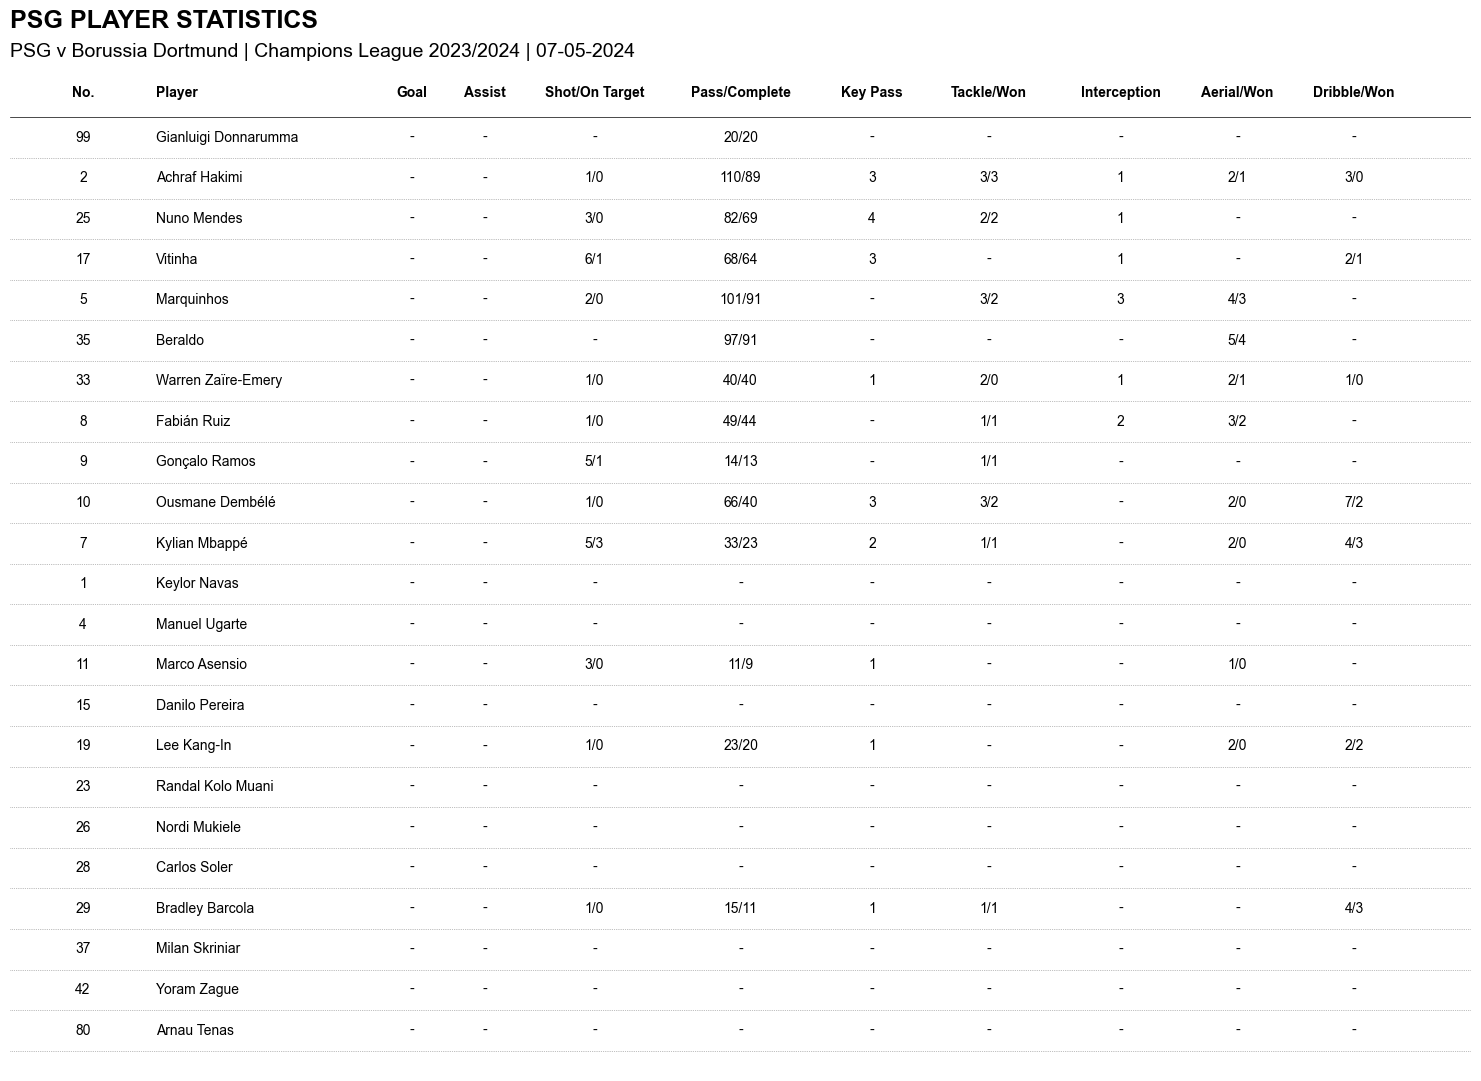

In [ ]:
mpl.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(figsize=(16,12))

# set the number of rows and cols
rows = len(player_statistics)
cols = 9

# set up the axis limits with "spacing" (a bit of padding on each side)
ax.set_ylim(-1, rows + 1.5)
ax.set_xlim(0, cols + 1)

for row in range(rows):
    col_num = 0
    d = player_statistics.iloc[row]

    # Kit No
    ax.text(x=.5, y=rows - row - 1, s=d['jerseyNumber'], va='center', ha='center')
    # player name column
    col_num += 1
    ax.text(x=col_num, y=rows - row - 1, s=d['playerName'], va='center', ha='left')

    # goal
    col_num += 1.75
    ax.text(x=col_num, y=rows - row - 1, s=d['Goal'] if (d['Goal'] > 0) else '-', va='center', ha='center')
    # assist
    col_num += .5
    ax.text(x=col_num, y=rows - row - 1, s=d['assist'] if (d['assist'] > 0) else '-', va='center', ha='center')

    # shot
    col_num += .75
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['Attempted_y']}/{d['shotOnTarget']}' if (d['Attempted_y'] > 0) else '-', va='center', ha='center')

    # passes attempted/successful column
    col_num += 1
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['Attempted_x']}/{d['Successful']}' if (d['Attempted_x'] > 0) else '-', va='center', ha='center')
    # key passes column
    col_num += .9
    ax.text(x=col_num, y=rows - row - 1, s=d['Key'] if (d['Key'] > 0) else '-', va='center', ha='center')
    
    # tackle
    col_num += .8
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['Tackle']}/{d['tackleWon']}' if (d['Tackle'] > 0) else '-', va='center', ha='center')
    # Interception
    col_num += .9
    ax.text(x=col_num, y=rows - row - 1, s=d['Interception'] if (d['Interception'] > 0) else '-', va='center', ha='center')
    # Aerial/duelAerialWon
    col_num += .8
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['Aerial']}/{d['duelAerialWon']}' if (d['Aerial'] > 0) else '-', va='center', ha='center')

    # TakeOn/dribbleWon
    col_num += .8
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['TakeOn']}/{d['dribbleWon']}' if (d['TakeOn'] > 0) else '-', va='center', ha='center')

# Add column headers
# plot them at height y=9.75 to decrease the space to the
# first data row (you'll see why later)
col_num = 0
col_num += 1
ax.text(col_num, rows, 'Player', weight='bold', ha='left')
col_num += 1.75
ax.text(col_num, rows, 'Goal', weight='bold', ha='center')
col_num += .5
ax.text(col_num, rows, 'Assist', weight='bold', ha='center')
col_num += .75
ax.text(x=col_num, y=rows, s='Shot/On Target', ha='center', weight='bold')
col_num += 1
ax.text(x=col_num, y=rows, s='Pass/Complete', ha='center', weight='bold')
col_num += .9
ax.text(col_num, rows, 'Key Pass', weight='bold', ha='center')
col_num += .8
ax.text(x=col_num, y=rows, s='Tackle/Won', ha='center', weight='bold')
col_num += .9
ax.text(col_num, rows, 'Interception', weight='bold', ha='center')
col_num += .8
ax.text(x=col_num, y=rows, s='Aerial/Won', ha='center', weight='bold')
col_num += .8
ax.text(x=col_num, y=rows, s='Dribble/Won', ha='center', weight='bold')

ax.text(x=0.5, y=rows, s='No.', weight='bold', ha='center' )

# Next up: formatting!
# let's add some gridlines
for row in range(rows):
    ax.plot([0, cols + 1], [row -.5, row - .5], ls=':', lw='.5', c='grey')

# let's add a main header divider
# remember that we plotted the header row slightly closer to the first data row
ax.plot([0, cols + 1], [rows - 0.5, rows - 0.5], lw='.5', c='black')

# highlight the column we are sorting by
# I will use a rectangle patch for this
# this can be a bit fiddly but given our coordinate space we can easily automate this!
# set the starting position (left bottom corner), then set a width and height
# the trick is to set the alpha (transparency) to a low number!
rect = patches.Rectangle((1.65, -.5), .65, y, lw=1, ec='none', fc='grey', alpha=.2, zorder=-1)
#ax.add_patch(rect)

# now the magic piece, hide the axis!
ax.axis('off')

# We can also add a title to our table
ax.set_title(f'{Home_Team.upper()} PLAYER STATISTICS', loc='left', fontsize=18, weight='bold')
ax.text(x=0, y=rows+1, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date}', fontsize=14)

plt.tight_layout(pad=5)
plt.show()
fig.savefig(f'D:\\Football\\Stats\\Player Statistics\\{Home_Team}_Player_Statistics_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

### Away

In [ ]:
playerId = match_data['away']['formations'][0]['playerIds']
playerIdNameDictionary = match_data['playerIdNameDictionary']
home_player = []
for id in playerId:
    home_player.append(playerIdNameDictionary[str(id)])

In [ ]:
team_events = events_data[events_data['h_a'] == 'a']

In [ ]:
Passing = team_events[team_events['type'] == 'Pass'].reset_index(drop=True)
passes_attempted = Passing.groupby('playerName')[['type']].count()
passes_completed = Passing[Passing['outcomeType'] == 'Successful'].groupby('playerName')[['outcomeType']].count()
key_passes = {}
for name in home_player:
    key_passes[name] = 0
    for i in range(len(Passing)): 
        if Passing.iloc[i]['playerName'] == name:
            if Passing.iloc[i]['keyPassLong'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassShort'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassCross'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassCorner'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassThroughball'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassFreekick'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassThrowin'] == True:
                key_passes[name] += 1
            elif Passing.iloc[i]['keyPassOther'] == True:
                key_passes[name] += 1
            else:
                pass
        else:
            pass
key_passes = pd.DataFrame.from_dict(key_passes, orient='index')
key_passes.index.name = 'playerName'
assist = team_events.groupby('playerName')[['assist']].sum()
PASSING = pd.merge(passes_attempted, passes_completed, on='playerName', how='outer')
PASSING = pd.merge(PASSING, key_passes, on='playerName', how='outer')
PASSING = pd.merge(PASSING, assist, on='playerName', how='outer')
PASSING = PASSING.rename(columns={'type': 'Attempted', 'outcomeType': 'Successful', 0: 'Key'})
PASSING = PASSING.reindex(home_player)
PASSING = PASSING.fillna(0)
PASSING = PASSING.astype(int)

In [ ]:
Shooting = team_events[(team_events['type'] == 'Goal') | (team_events['type'] == 'MissedShots') | (team_events['type'] == 'SavedShot') | (team_events['type'] == 'ShotOnPost')].reset_index(drop=True)
attempted = Shooting.groupby('playerName')[['type']].count().rename(columns={'type': 'Attempted'})
#on_target = Shooting.groupby('playerName')['type'].apply(lambda x: (x=='SavedShot').sum()).reset_index(name='On Target')
on_target = Shooting.groupby('playerName')[['shotOnTarget']].sum()
goal = team_events[(team_events['type'] == 'Goal')].groupby('playerName')[['type']].count().rename(columns={'type': 'Goal'})
SHOOTING = pd.merge(pd.merge(attempted, on_target, on='playerName', how='outer'), goal, on='playerName', how='outer')

In [ ]:
clearance = team_events[team_events['type'] == 'Clearance'].groupby('playerName')[['type']].count().rename(columns={'type': 'Clearance'})
interception = team_events[team_events['type'] == 'Interception'].groupby('playerName')[['type']].count().rename(columns={'type': 'Interception'})
tackle = team_events[team_events['type'] == 'Tackle'].groupby('playerName')[['type']].count().rename(columns={'type': 'Tackle'})
tackle_won = team_events[team_events['type'] == 'Tackle'].groupby('playerName')[['tackleWon']].sum()
aerial = team_events[team_events['type'] == 'Aerial'].groupby('playerName')[['type']].count().rename(columns={'type': 'Aerial'})
aerial_won = team_events[team_events['type'] == 'Aerial'].groupby('playerName')[['duelAerialWon']].sum()
DEFENCE = pd.merge(clearance, interception, on='playerName', how='outer')
DEFENCE = pd.merge(DEFENCE, tackle, on='playerName', how='outer')
DEFENCE = pd.merge(DEFENCE, tackle_won, on='playerName', how='outer')
DEFENCE = pd.merge(DEFENCE, aerial, on='playerName', how='outer')
DEFENCE = pd.merge(DEFENCE, aerial_won, on='playerName', how='outer')

In [ ]:
take_on = team_events[team_events['type'] == 'TakeOn'].groupby('playerName')[['type']].count().rename(columns={'type': 'TakeOn'})
dribble_won = team_events.groupby('playerName')[['dribbleWon']].sum()
DRIBBLE = pd.merge(take_on, dribble_won, on='playerName', how='outer')

In [ ]:
player_statistics = pd.merge(pd.merge(PASSING, SHOOTING, on='playerName', how='outer'), pd.merge(DEFENCE, DRIBBLE, on='playerName', how='outer'), on='playerName', how='outer')
player_statistics = player_statistics.reindex(home_player)
player_statistics = player_statistics.fillna(0)
player_statistics = player_statistics.astype(int)
player_statistics = pd.merge(player_statistics, kit_no, on='playerName', how='inner')

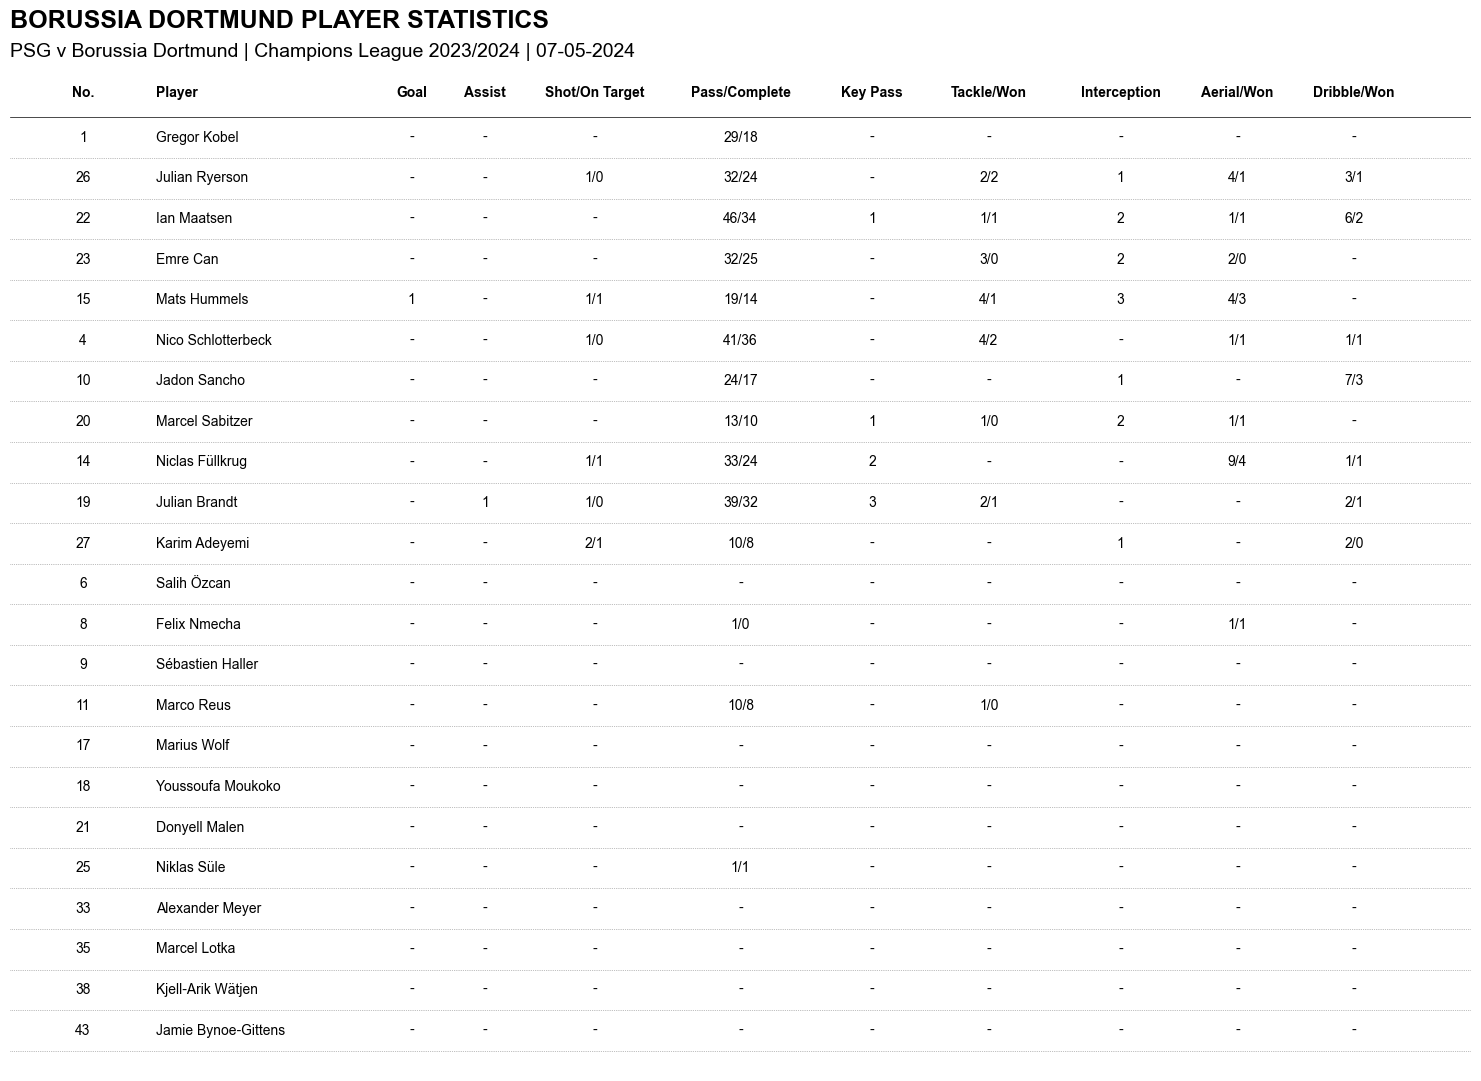

In [ ]:
mpl.rcParams['figure.dpi'] = 100

fig, ax = plt.subplots(figsize=(16,12))

# set the number of rows and cols
rows = len(player_statistics)
cols = 9

# set up the axis limits with "spacing" (a bit of padding on each side)
ax.set_ylim(-1, rows + 1.5)
ax.set_xlim(0, cols + 1)

for row in range(rows):
    col_num = 0
    d = player_statistics.iloc[row]

    # Kit No
    ax.text(x=.5, y=rows - row - 1, s=d['jerseyNumber'], va='center', ha='center')
    # player name column
    col_num += 1
    ax.text(x=col_num, y=rows - row - 1, s=d['playerName'], va='center', ha='left')

    # goal
    col_num += 1.75
    ax.text(x=col_num, y=rows - row - 1, s=d['Goal'] if (d['Goal'] > 0) else '-', va='center', ha='center')
    # assist
    col_num += .5
    ax.text(x=col_num, y=rows - row - 1, s=d['assist'] if (d['assist'] > 0) else '-', va='center', ha='center')

    # shot
    col_num += .75
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['Attempted_y']}/{d['shotOnTarget']}' if (d['Attempted_y'] > 0) else '-', va='center', ha='center')

    # passes attempted/successful column
    col_num += 1
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['Attempted_x']}/{d['Successful']}' if (d['Attempted_x'] > 0) else '-', va='center', ha='center')
    # key passes column
    col_num += .9
    ax.text(x=col_num, y=rows - row - 1, s=d['Key'] if (d['Key'] > 0) else '-', va='center', ha='center')
    
    # tackle
    col_num += .8
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['Tackle']}/{d['tackleWon']}' if (d['Tackle'] > 0) else '-', va='center', ha='center')
    # Interception
    col_num += .9
    ax.text(x=col_num, y=rows - row - 1, s=d['Interception'] if (d['Interception'] > 0) else '-', va='center', ha='center')
    # Aerial/duelAerialWon
    col_num += .8
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['Aerial']}/{d['duelAerialWon']}' if (d['Aerial'] > 0) else '-', va='center', ha='center')

    # TakeOn/dribbleWon
    col_num += .8
    ax.text(x=col_num, y=rows - row - 1, s=f'{d['TakeOn']}/{d['dribbleWon']}' if (d['TakeOn'] > 0) else '-', va='center', ha='center')

# Add column headers
# plot them at height y=9.75 to decrease the space to the
# first data row (you'll see why later)
col_num = 0
col_num += 1
ax.text(col_num, rows, 'Player', weight='bold', ha='left')
col_num += 1.75
ax.text(col_num, rows, 'Goal', weight='bold', ha='center')
col_num += .5
ax.text(col_num, rows, 'Assist', weight='bold', ha='center')
col_num += .75
ax.text(x=col_num, y=rows, s='Shot/On Target', ha='center', weight='bold')
col_num += 1
ax.text(x=col_num, y=rows, s='Pass/Complete', ha='center', weight='bold')
col_num += .9
ax.text(col_num, rows, 'Key Pass', weight='bold', ha='center')
col_num += .8
ax.text(x=col_num, y=rows, s='Tackle/Won', ha='center', weight='bold')
col_num += .9
ax.text(col_num, rows, 'Interception', weight='bold', ha='center')
col_num += .8
ax.text(x=col_num, y=rows, s='Aerial/Won', ha='center', weight='bold')
col_num += .8
ax.text(x=col_num, y=rows, s='Dribble/Won', ha='center', weight='bold')

ax.text(x=0.5, y=rows, s='No.', weight='bold', ha='center' )

# Next up: formatting!
# let's add some gridlines
for row in range(rows):
    ax.plot([0, cols + 1], [row -.5, row - .5], ls=':', lw='.5', c='grey')

# let's add a main header divider
# remember that we plotted the header row slightly closer to the first data row
ax.plot([0, cols + 1], [rows - 0.5, rows - 0.5], lw='.5', c='black')

# highlight the column we are sorting by
# I will use a rectangle patch for this
# this can be a bit fiddly but given our coordinate space we can easily automate this!
# set the starting position (left bottom corner), then set a width and height
# the trick is to set the alpha (transparency) to a low number!
rect = patches.Rectangle((1.65, -.5), .65, y, lw=1, ec='none', fc='grey', alpha=.2, zorder=-1)
#ax.add_patch(rect)

# now the magic piece, hide the axis!
ax.axis('off')

# We can also add a title to our table
ax.set_title(f'{Away_Team.upper()} PLAYER STATISTICS', loc='left', fontsize=18, weight='bold')
ax.text(x=0, y=rows+1, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date}', fontsize=14)

plt.tight_layout(pad=5)
plt.show()
fig.savefig(f'D:\\Football\\Stats\\Player Statistics\\{Away_Team}_Player_Statistics_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

## Passes into Final Third

### Home

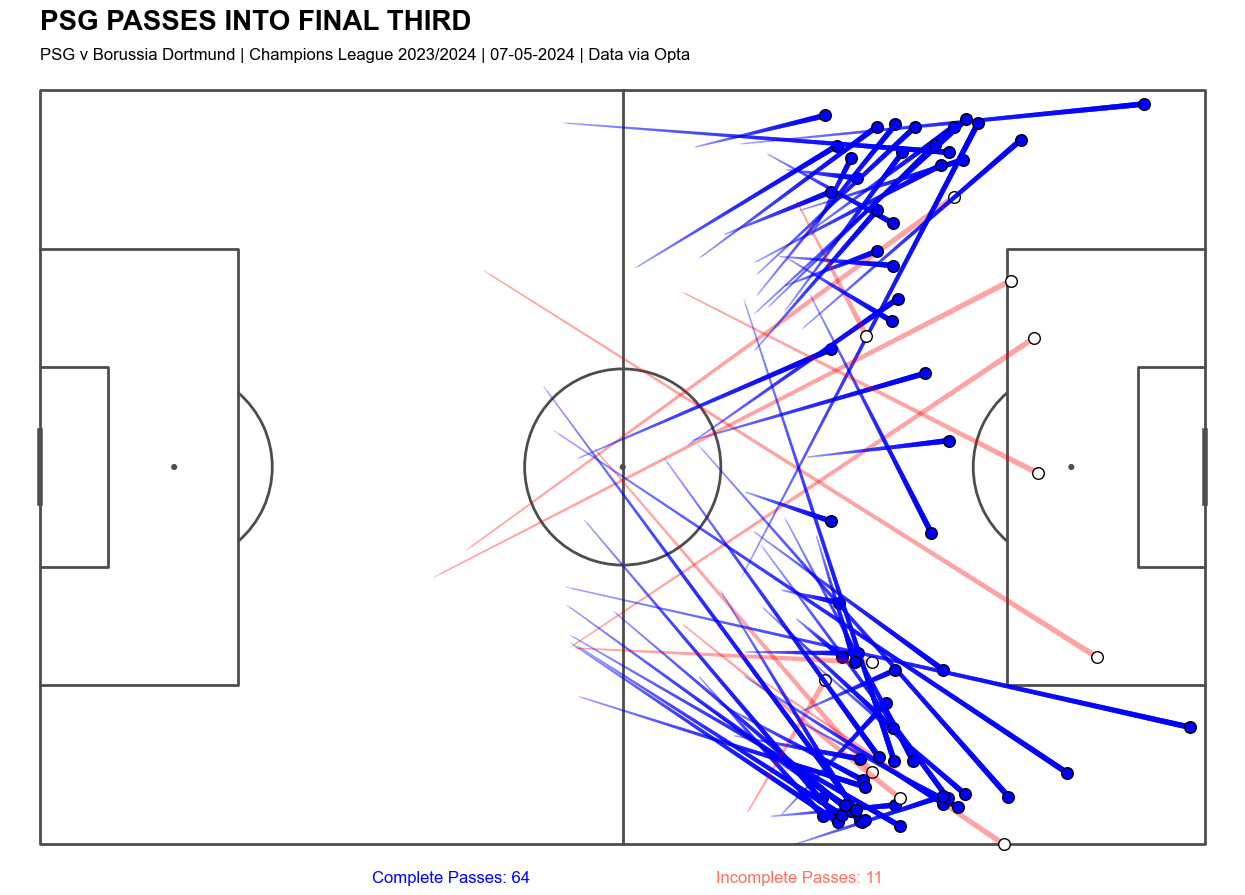

In [ ]:
df = events_data[(events_data.x < 100*2/3) & (events_data.endX > 100*2/3) & (events_data.type == 'Pass')].reset_index(drop=True)
df = df[df.h_a == 'h'].reset_index(drop=True)
pitch = Pitch(line_color='0.3', pitch_type='opta', line_zorder=2)
fig, ax = pitch.draw(constrained_layout=False, tight_layout=True)
fig.set_size_inches(14, 9)

for i in range(len(df)):

    if df.outcomeType[i] == 'Successful':
        color = 'blue'
        mk = 'blue'
        pitch.lines(df.x[i], df.y[i], df.endX[i], df.endY[i],
            color=color, lw=4, transparent=True, comet=True,
            alpha_start=0.2, alpha_end=1, ax=ax)
    else:
        color = 'red'
        mk = 'white'
        pitch.lines(df.x[i], df.y[i], df.endX[i], df.endY[i],
            color=color, lw=4, transparent=True, comet=True,
            alpha_start=0.2, alpha_end=0.2, ax=ax)    
    
    pitch.scatter(df.endX[i], df.endY[i], s=70, marker='o', edgecolors='black',
                c=mk, zorder=2, ax=ax)

# Title
ax.text(0, 108, s=f'{Home_Team.upper()} PASSES INTO FINAL THIRD', size=20, weight='bold')
ax.text(0, 104, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

# Legend
ax.text(42, -5, s=f'Complete Passes: {len(df[df.outcomeType == 'Successful'])}', color='blue', size=12, ha='right')
ax.text(58, -5, s=f'Incomplete Passes: {len(df[df.outcomeType == 'Unsuccessful'])}', color='#FF6F5F', size=12, ha='left')

plt.show()

### Away

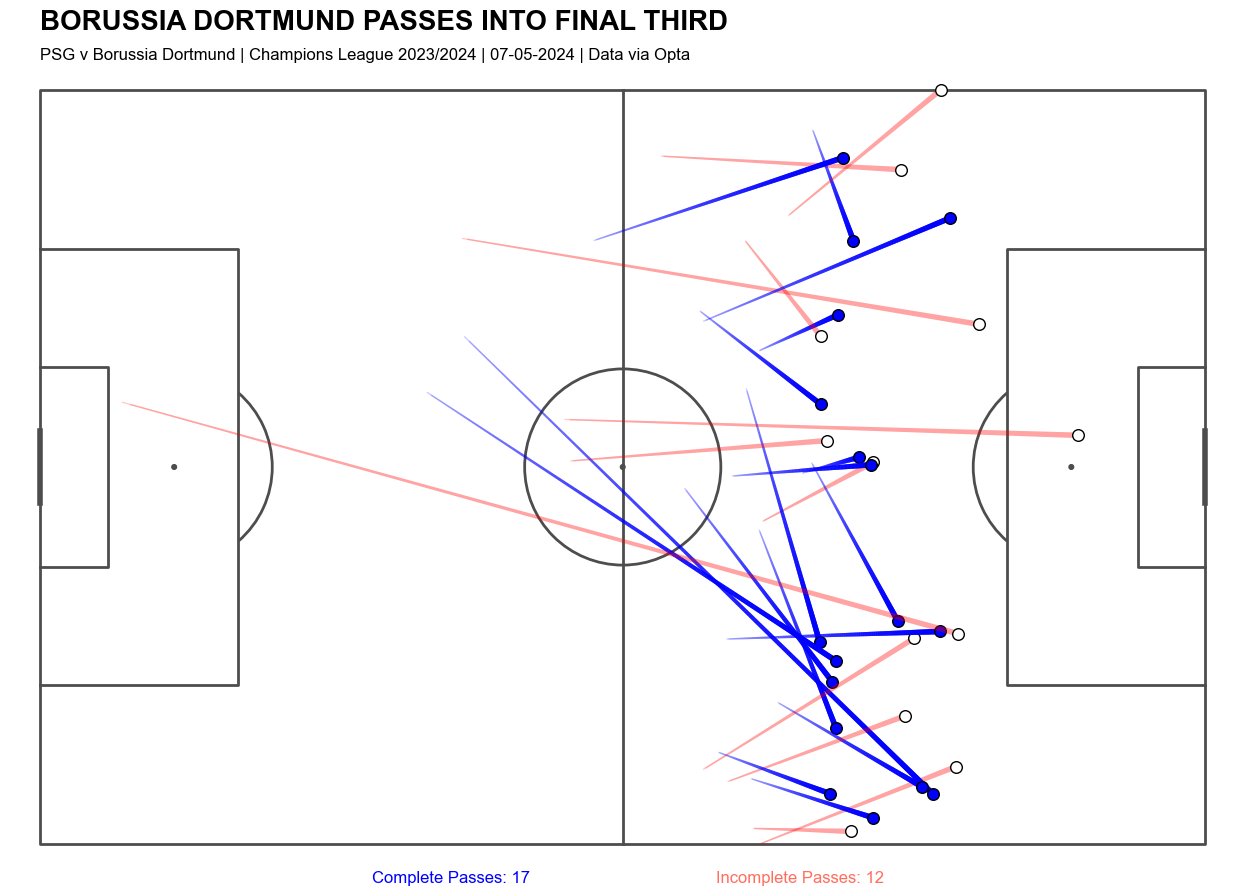

In [ ]:
df = events_data[(events_data.x < 100*2/3) & (events_data.endX > 100*2/3) & (events_data.type == 'Pass')].reset_index(drop=True)
df = df[df.h_a == 'a'].reset_index(drop=True)
pitch = Pitch(line_color='0.3', pitch_type='opta', line_zorder=2)
fig, ax = pitch.draw(constrained_layout=False, tight_layout=True)
fig.set_size_inches(14, 9)

for i in range(len(df)):

    if df.outcomeType[i] == 'Successful':
        color = 'blue'
        mk = 'blue'
        pitch.lines(df.x[i], df.y[i], df.endX[i], df.endY[i],
            color=color, lw=4, transparent=True, comet=True,
            alpha_start=0.2, alpha_end=1, ax=ax)
    else:
        color = 'red'
        mk = 'white'
        pitch.lines(df.x[i], df.y[i], df.endX[i], df.endY[i],
            color=color, lw=4, transparent=True, comet=True,
            alpha_start=0.2, alpha_end=0.2, ax=ax)    
    
    pitch.scatter(df.endX[i], df.endY[i], s=70, marker='o', edgecolors='black',
                c=mk, zorder=2, ax=ax)

# Title
ax.text(0, 108, s=f'{Away_Team.upper()} PASSES INTO FINAL THIRD', size=20, weight='bold')
ax.text(0, 104, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

# Legend
ax.text(42, -5, s=f'Complete Passes: {len(df[df.outcomeType == 'Successful'])}', color='blue', size=12, ha='right')
ax.text(58, -5, s=f'Incomplete Passes: {len(df[df.outcomeType == 'Unsuccessful'])}', color='#FF6F5F', size=12, ha='left')

plt.show()

## Passes to The Box

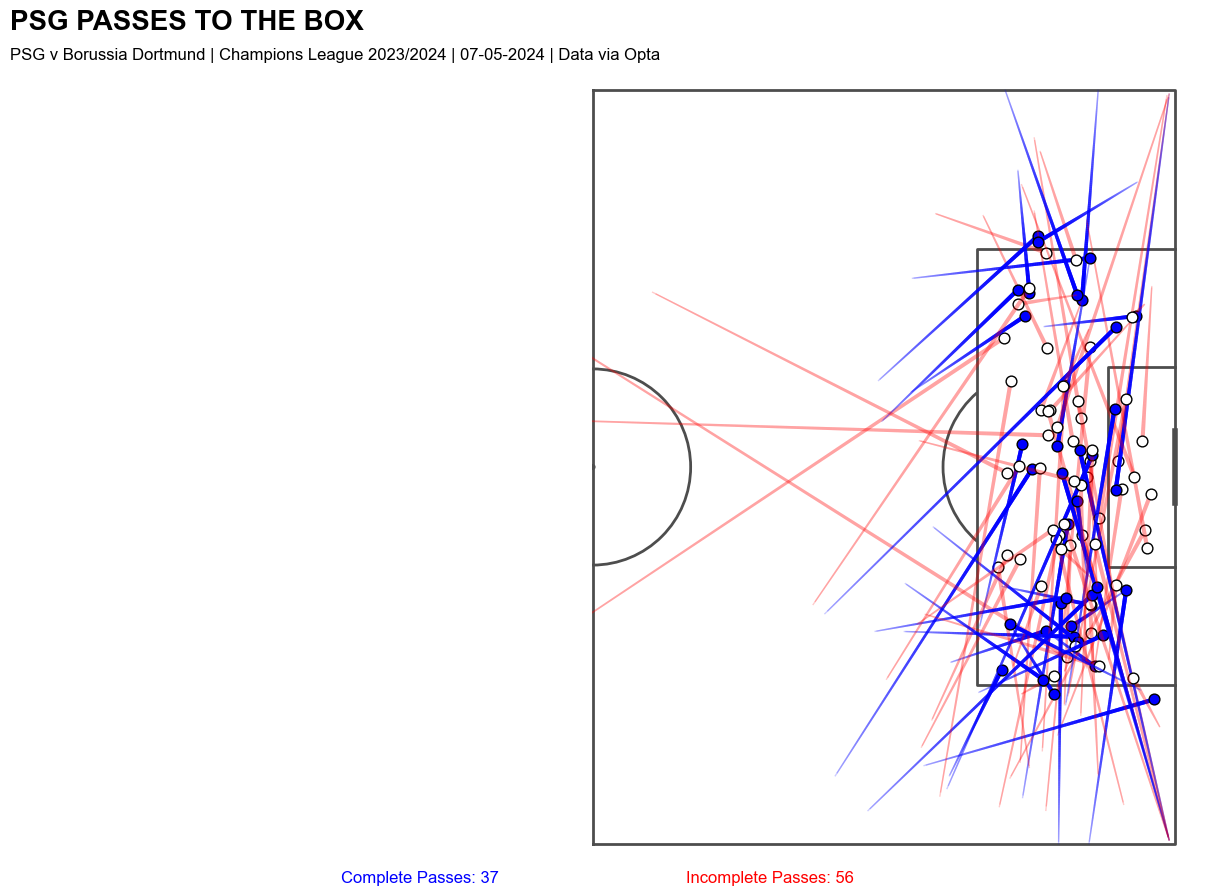

In [ ]:
df = events_data[(events_data.endX > 84) & (events_data.endY > 19) & (events_data.endY < 81) & (events_data.type == 'Pass')].reset_index(drop=True)
df
pitch = Pitch(line_color='0.3', pitch_type='opta', line_zorder=2, half=True, pad_left=0.1)
fig, ax = pitch.draw(constrained_layout=True, tight_layout=True)
fig.set_size_inches(14, 9)

for i in range(len(df)):

    if df.outcomeType[i] == 'Successful':
        color = 'blue'
        alpha_end = 1
        mk = color
    else:
        color = 'red'
        alpha_end = 0.2
        mk = 'white'

    pitch.lines(df.x[i], df.y[i], df.endX[i], df.endY[i],
            color=color, lw=3, transparent=True, comet=True,
            alpha_start=0.2, alpha_end=alpha_end, ax=ax)
    
    pitch.scatter(df.endX[i], df.endY[i], s=60, marker='o', edgecolors='black',
                c=mk, zorder=2, ax=ax)

# Title
ax.text(0, 108, s=f'{Home_Team.upper()} PASSES TO THE BOX', size=20, weight='bold')
ax.text(0, 104, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

# Legend
ax.text(42, -5, s=f'Complete Passes: {len(df[df.outcomeType == 'Successful'])}', color='blue', size=12, ha='right')
ax.text(58, -5, s=f'Incomplete Passes: {len(df[df.outcomeType == 'Unsuccessful'])}', color='red', size=12, ha='left')

plt.show()

## Passes in Final Third

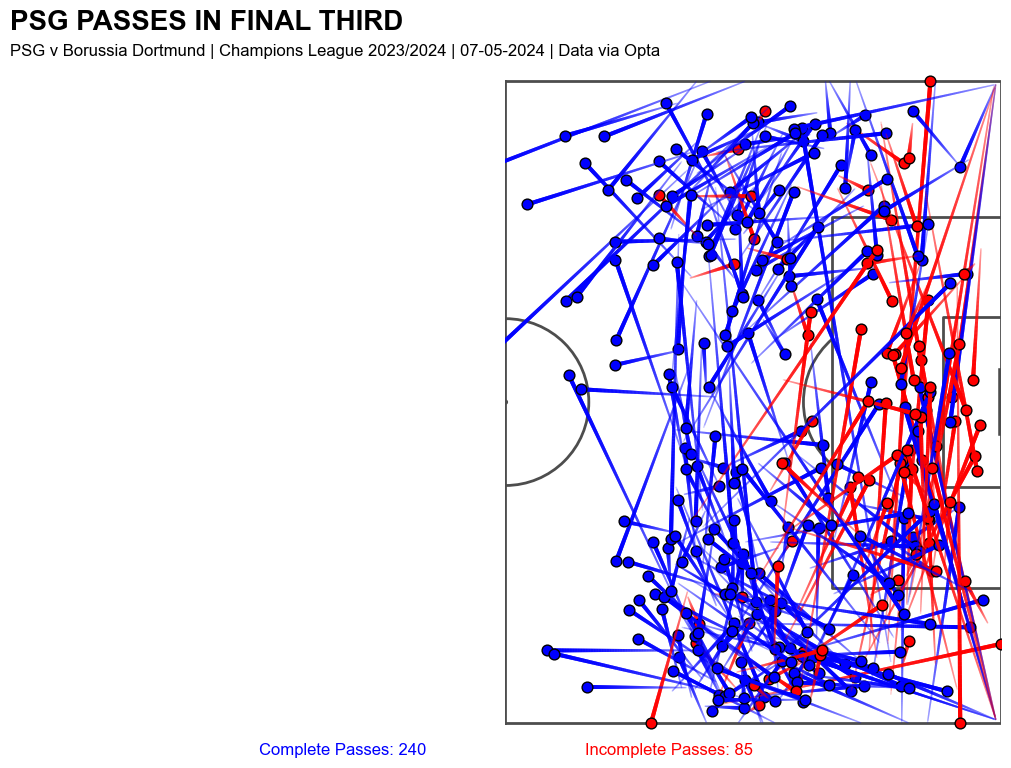

In [ ]:
df = events_data[(events_data.x > 100*2/3) & (events_data.type == 'Pass')].reset_index(drop=True)
pitch = Pitch(line_color='0.3', pitch_type='opta', line_zorder=2, half=True, pad_left=0.1, pad_right=0.1)
fig, ax = pitch.draw(constrained_layout=False, tight_layout=False)
fig.set_size_inches(14, 9)

for i in range(len(df)):

    if df.outcomeType[i] == 'Successful':
        color = 'blue'
    else:
        color = 'red'

    pitch.lines(df.x[i], df.y[i], df.endX[i], df.endY[i],
            color=color, lw=3, transparent=True, comet=True,
            alpha_start=0.2, alpha_end=1, ax=ax)
    
    pitch.scatter(df.endX[i], df.endY[i], s=60, marker='o', edgecolors='black',
                c=color, zorder=2, ax=ax)

# Title
ax.text(0, 108, s=f'{Home_Team.upper()} PASSES IN FINAL THIRD', size=20, weight='bold')
ax.text(0, 104, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

# Legend
ax.text(42, -5, s=f'Complete Passes: {len(df[df.outcomeType == 'Successful'])}', color='blue', size=12, ha='right')
ax.text(58, -5, s=f'Incomplete Passes: {len(df[df.outcomeType == 'Unsuccessful'])}', color='red', size=12, ha='left')

plt.show()

## Progressive Passes

In [ ]:
df = events_data[events_data.type == 'Pass'].reset_index(drop=True)
df['X'] = df.x
df['Y'] = df.y
df['ENDX'] = df.endX
df['ENDY'] = df.endY
df['xmetre'] = df.x * 1.05
df['ymetre'] = df.y * 0.68
df['endXmetre'] = df.endX * 1.05
df['endYmetre'] = df.endY * 0.68
df['beginning'] = np.sqrt(np.square(100 - df.x) + np.square(50 - df.y))
df['end'] = np.sqrt(np.square(100 - df.endX) + np.square(50 - df.endY))
df['beginningmetre'] = np.sqrt(np.square(105 - df.xmetre) + np.square(34 - df.ymetre))
df['endmetre'] = np.sqrt(np.square(105 - df.endXmetre) + np.square(34 - df.endYmetre))
df['progressive'] = df.beginning - df.end
df['progressivemetre'] = df.beginningmetre - df.endmetre
df['check'] = [(df.end[x]) / (df.beginning[x]) for x in range(len(df))]
df['checkmetre'] = [(df.endmetre[x]) / (df.beginningmetre[x]) for x in range(len(df))]
df['checkprogressive'] = [(df.end[x]) / (df.beginning[x]) < .75 for x in range(len(df))]
df['test'] = [((df.beginning[x] - df.end[x]) * (df.beginningmetre[x] - df.endmetre[x])) < 0 for x in range(len(df))]

In [ ]:
own_half = df[(df.x < 50) & (df.endX < 50) & (df.progressivemetre > 30)]
different_halves = df[(df.x < 50) & (df.endX > 50) & (df.progressivemetre > 15)]
opponent_half = df[(df.x > 50) & (df.endX > 50) & (df.progressivemetre > 10)]

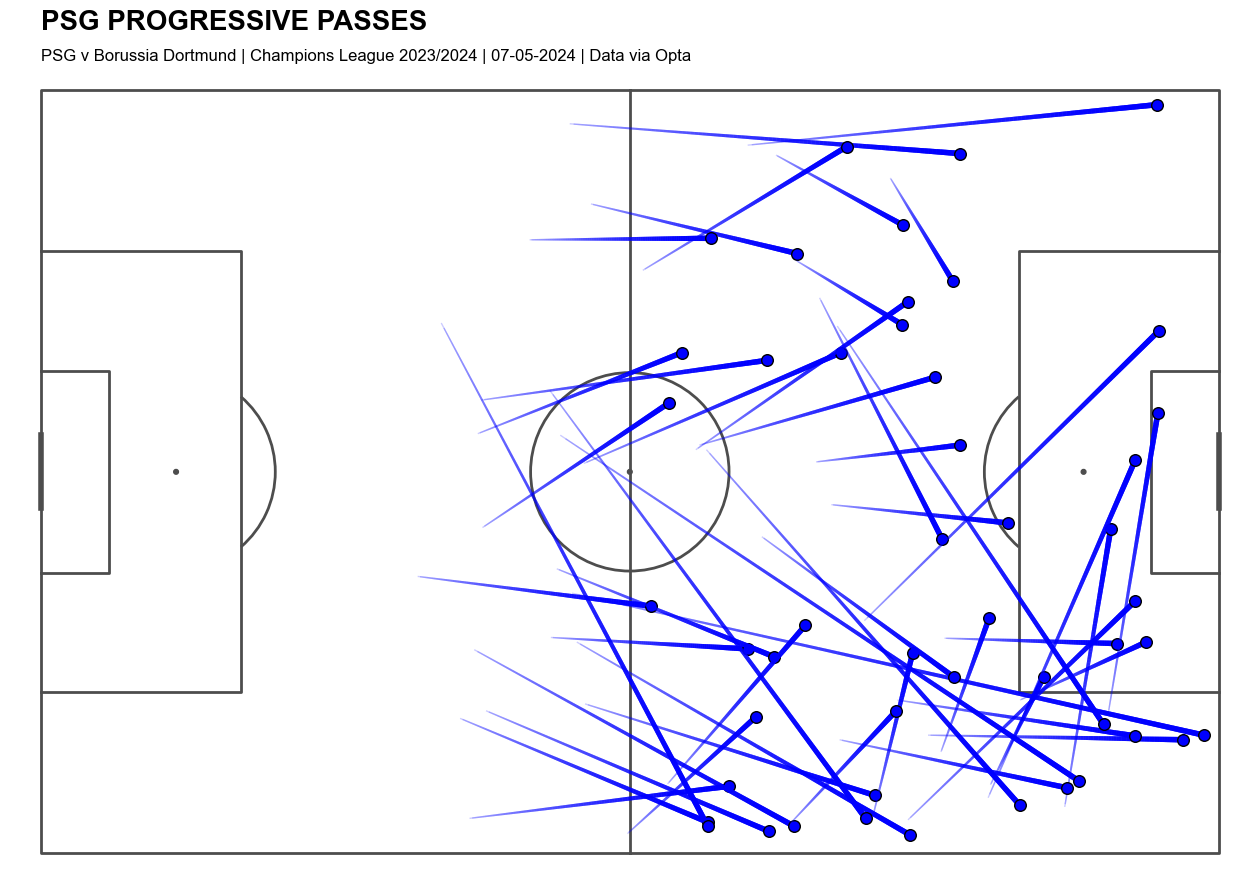

In [ ]:
df = pd.concat([own_half, different_halves, opponent_half]).reset_index(drop=True)
df = df[df.h_a == 'h']
df = df[(df.outcomeType == 'Successful') & (df.passCorner == False) & (df.throwIn == False)].reset_index(drop=True)
pitch = Pitch(line_color='0.3', pitch_type='opta', line_zorder=2)
fig, ax = pitch.draw(constrained_layout=False, tight_layout=True)
fig.set_size_inches(14, 9)

for i in range(len(df)):

    if df.outcomeType[i] == 'Successful':
        color = 'blue'
    else:
        color = 'red'

    pitch.lines(df.x[i], df.y[i], df.endX[i], df.endY[i],
            color=color, lw=4, transparent=True, comet=True,
            alpha_start=0.2, alpha_end=1, ax=ax)
    
    pitch.scatter(df.endX[i], df.endY[i], s=70, marker='o', edgecolors='black',
                c=color, zorder=2, ax=ax)

# Title
ax.text(0, 108, s=f'{Home_Team.upper()} PROGRESSIVE PASSES', size=20, weight='bold')
ax.text(0, 104, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

plt.show()

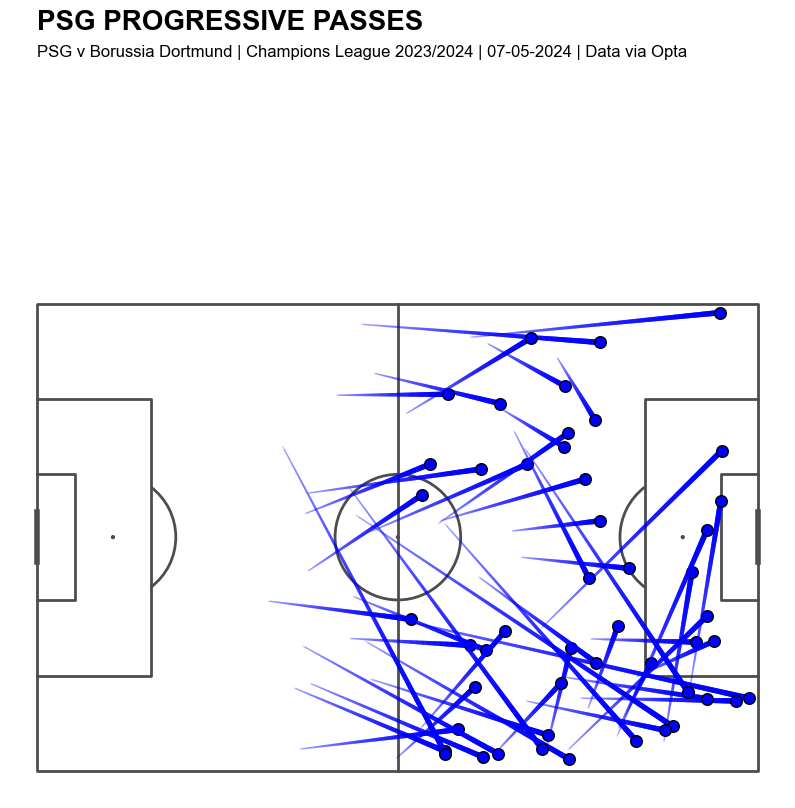

In [ ]:
df = pd.concat([own_half, different_halves, opponent_half]).reset_index(drop=True)
df = df[df.h_a == 'h']
df = df[(df.outcomeType == 'Successful') & (df.passCorner == False) & (df.throwIn == False)].reset_index(drop=True)
pitch = Pitch(pitch_type='uefa', line_color='0.3', line_zorder=2)
fig, ax = pitch.draw(constrained_layout=False, tight_layout=True)
fig.set_size_inches(14, 9)

for i in range(len(df)):

    if df.outcomeType[i] == 'Successful':
        color = 'blue'
    else:
        color = 'red'

    pitch.lines(df.xmetre[i], df.ymetre[i], df.endXmetre[i], df.endYmetre[i],
            color=color, lw=4, transparent=True, comet=True,
            alpha_start=0.2, alpha_end=1, ax=ax)
    
    pitch.scatter(df.endXmetre[i], df.endYmetre[i], s=70, marker='o', edgecolors='black',
                c=color, zorder=2, ax=ax)

# Title
ax.text(0, 108, s=f'{Home_Team.upper()} PROGRESSIVE PASSES', size=20, weight='bold')
ax.text(0, 104, s=f'{Home_Team} v {Away_Team} | {Competition} {Season} | {Date} | Data via Opta', size=12)

plt.show()

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

## Shot Map

### Home

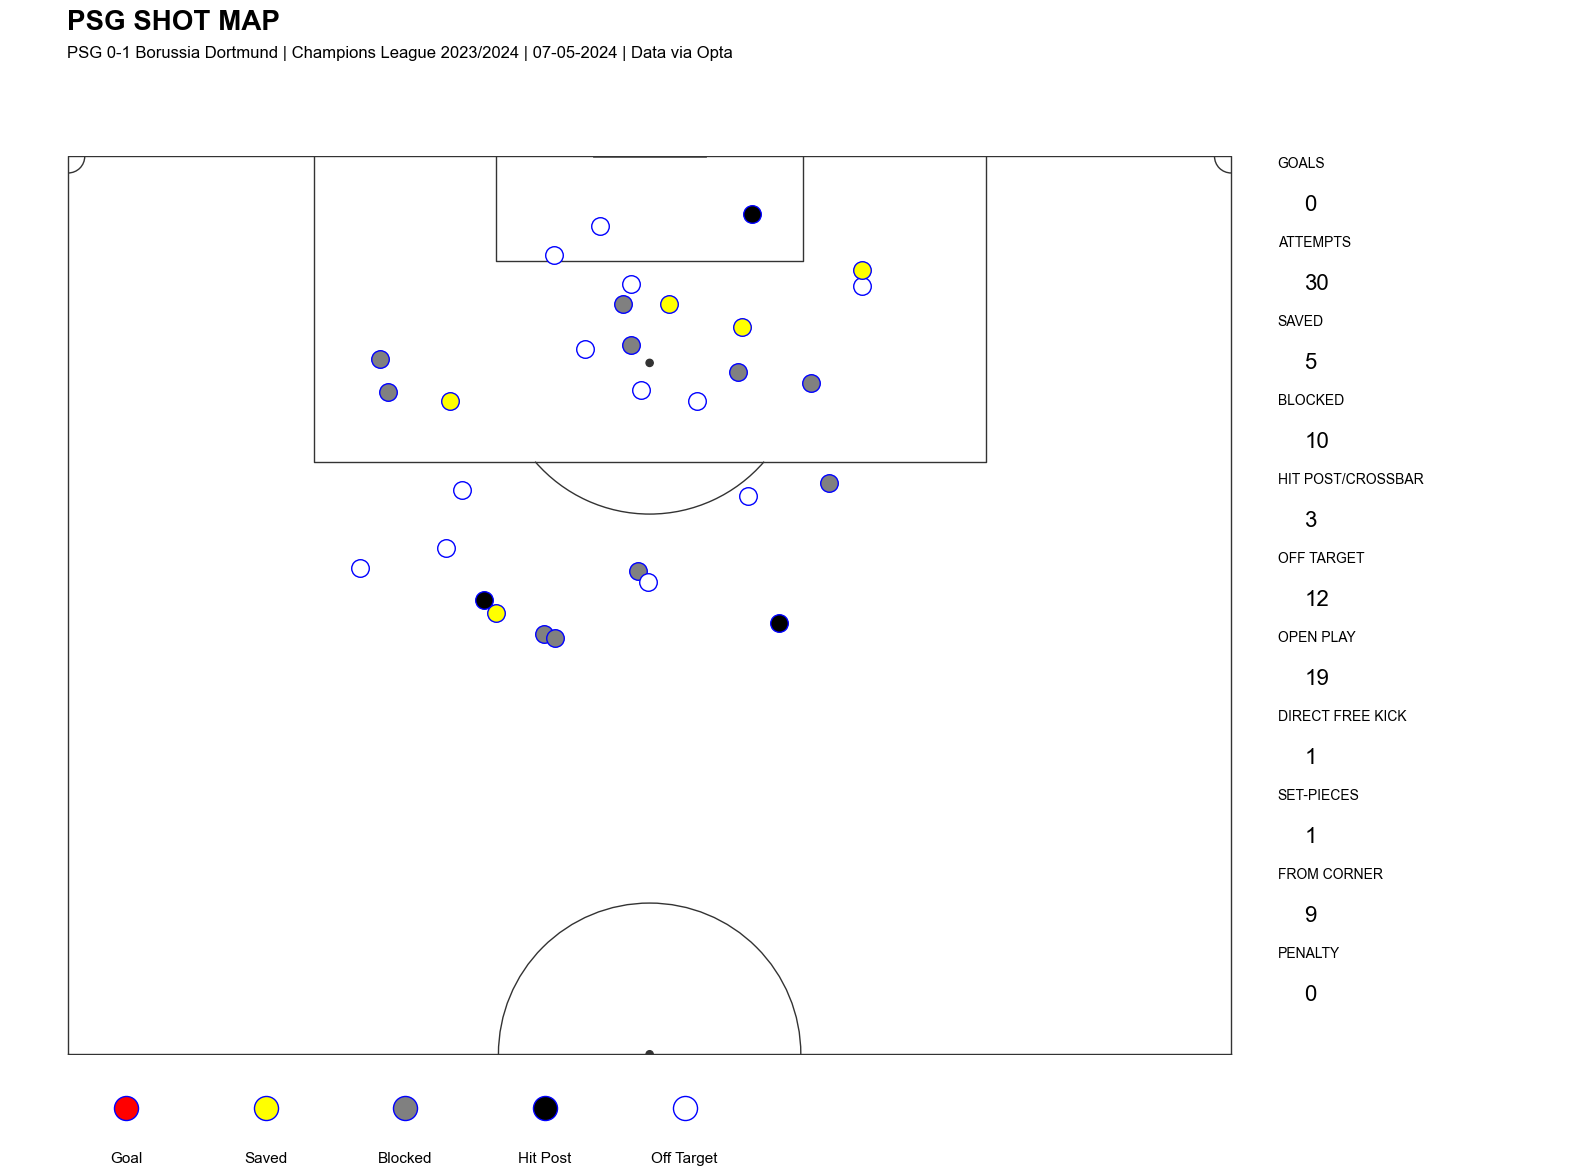

In [ ]:
data = events_data[(events_data.h_a == 'h') & ((events_data.type == 'Goal') | (events_data.type == 'SavedShot') | (events_data.type == 'ShotOnPost') | (events_data.type == 'MissedShots'))].reset_index(drop=True)
pitch = VerticalPitch(
    pitch_type = 'opta',
    half = True,
    goal_type = 'line',
    goal_alpha = 0.8,
    corner_arcs=True,
    line_color = '0.2',
    linewidth = 1,
    pad_top=0, pad_bottom=0.1, pad_left=5, pad_right=30,
)
fig, ax = plt.subplots(constrained_layout=True, tight_layout=True)
fig.set_size_inches(16, 12)
pitch.draw(ax=ax)

markersize = 160

for i in range(len(data)):
    if data.type[i] == 'Goal':
        markercolor = 'red'
    elif data.type[i] == 'SavedShot':
        if data.shotBlocked[i] == True:
            markercolor = '0.5'
        else:
            markercolor = 'yellow'
    elif data.type[i] == 'MissedShots':
        markercolor = 'white'
    elif data.type[i] == 'ShotOnPost':
        markercolor = 'black'
    elif data.type[i] == 'OwnGoal':
        markercolor = 'red'
    else:
        markercolor='white'

    scatter = pitch.scatter(
        
        # Coordinates
        data.x[i],
        data.y[i],
        # Size Between 100 and 300
        s = markersize,
        # Type of Marker
        marker = "o",
        # Color Marker
        c =  markercolor,
        # Color Marker Border
        edgecolors = 'blue',

        ax = ax
    )

# Title
plt.suptitle(f'{Home_Team.upper()} SHOT MAP', x=0.045, size=20, weight='bold', ha='left')
fig.text(x=0.045, y=0.95, size = 12, ha = 'left', va='top', linespacing=1.4,
    s = f'{Home_Team} {Home_Score}-{Away_Score} {Away_Team} | {Competition} {Season} | {Date} | Data via Opta')

# Stats
y = 104.4
jarak = 4.4
size = 10
kiri = -4
plt.text(x=kiri, y=y-1*jarak , s='GOALS', size=size, va='top')
plt.text(x=kiri, y=y-2*jarak, s='ATTEMPTS', size=size, va='top')
plt.text(x=kiri, y=y-3*jarak, s='SAVED', size=size, va='top')
plt.text(x=kiri, y=y-4*jarak, s='BLOCKED', size=size, va='top')
plt.text(x=kiri, y=y-5*jarak, s='HIT POST/CROSSBAR', size=size, va='top')
plt.text(x=kiri, y=y-6*jarak, s='OFF TARGET', size=size, va='top')
plt.text(x=kiri, y=y-7*jarak, s='OPEN PLAY', size=size, va='top')
plt.text(x=kiri, y=y-8*jarak, s='DIRECT FREE KICK', size=size, va='top')
plt.text(x=kiri, y=y-9*jarak, s='SET-PIECES', size=size, va='top')
plt.text(x=kiri, y=y-10*jarak, s='FROM CORNER', size=size, va='top')
plt.text(x=kiri, y=y-11*jarak, s='PENALTY', size=size, va='top')

x=kiri-2.3
y-=3
size=16
plt.text(x=x, y=y-jarak, size=size, s=Home_Score)
plt.text(x=x, y=y-2*jarak, size=size, s=len(data))
plt.text(x=x, y=y-3*jarak, size=size, s=len(data[(data.type == 'SavedShot') & (data.shotBlocked == False)]))
plt.text(x=x, y=y-4*jarak, size=size, s=len(data[(data.type == 'SavedShot') & (data.shotBlocked == True)]))
plt.text(x=x, y=y-5*jarak, size=size, s=len(data[data.type == 'ShotOnPost']))
plt.text(x=x, y=y-6*jarak, size=size, s=len(data[data.type == 'MissedShots']))
plt.text(x=x, y=y-7*jarak, size=size, s=len(data[data.situation == 'OpenPlay']))
plt.text(x=x, y=y-8*jarak, size=size, s=len(data[data.situation == 'DirectFreekick']))
plt.text(x=x, y=y-9*jarak, size=size, s=len(data[data.situation == 'SetPiece']))
plt.text(x=x, y=y-10*jarak, size=size, s=len(data[data.situation == 'FromCorner']))
plt.text(x=x, y=y-11*jarak, size=size, s=len(data[data.situation == 'Penalty']))


# Legend
y = 47
x = 95
add = 12
text_size = 11
plt.scatter(x=x, y=y, s=300, c='red', edgecolors='blue', clip_on=False)
plt.scatter(x=x-add, y=y, s=300, c='yellow', edgecolors='blue', clip_on=False)
plt.scatter(x=x-2*add, y=y, s=300, c='0.5', edgecolors='blue', clip_on=False)
plt.scatter(x=x-3*add, y=y, s=300, c='black', edgecolors='blue', clip_on=False)
plt.scatter(x=x-4*add, y=y, s=300, c='white', edgecolors='blue', clip_on=False)
plt.text(x=x, y=y-3, s="Goal", size=text_size, ha='center')
plt.text(x=x-add, y=y-3, s="Saved", size=text_size, ha='center')
plt.text(x=x-2*add, y=y-3, s="Blocked", size=text_size, ha='center')
plt.text(x=x-3*add, y=y-3, s="Hit Post", size=text_size, ha='center')
plt.text(x=x-4*add, y=y-3, s="Off Target", size=text_size, ha='center')

fig = plt.gcf()
fig.savefig(f'D:\\Football\\Stats\\Shot Map\\{Home_Team}_Shot_Map_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

### Away

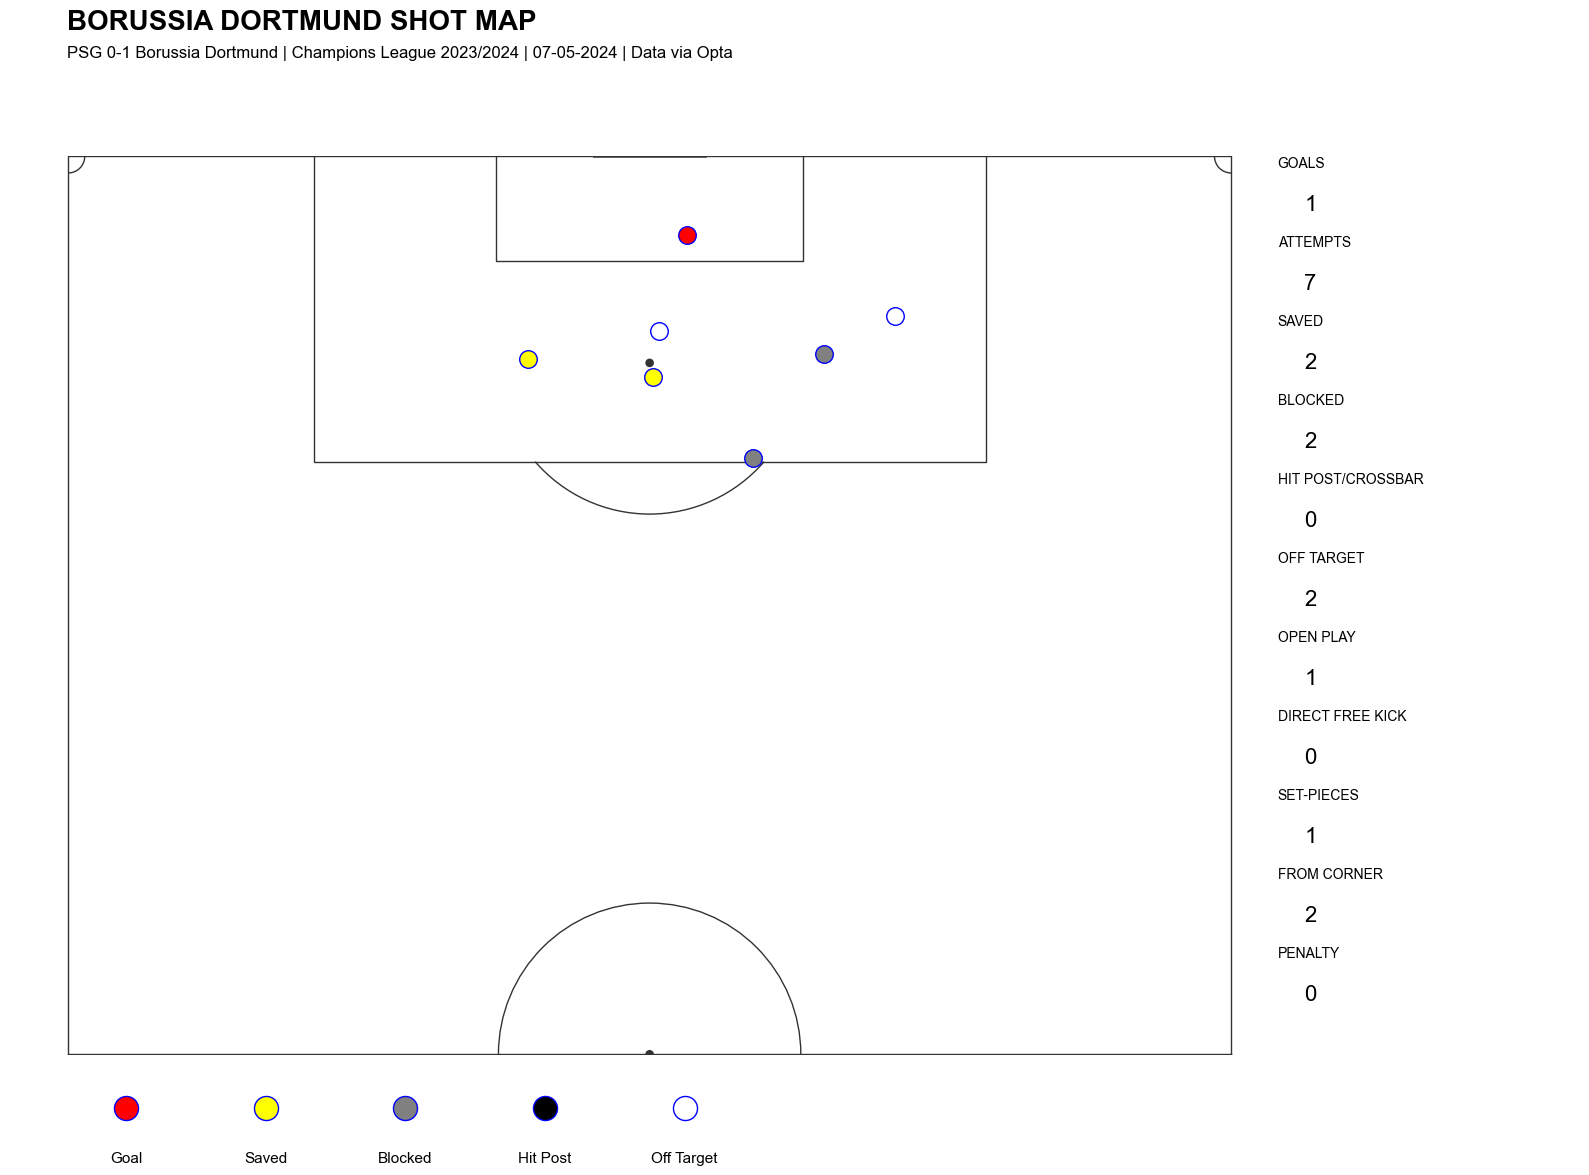

In [ ]:
data = events_data[(events_data.h_a == 'a') & ((events_data.type == 'Goal') | (events_data.type == 'SavedShot') | (events_data.type == 'ShotOnPost') | (events_data.type == 'MissedShots'))].reset_index(drop=True)
pitch = VerticalPitch(
    pitch_type = 'opta',
    half = True,
    goal_type = 'line',
    goal_alpha = 0.8,
    corner_arcs=True,
    line_color = '0.2',
    linewidth = 1,
    pad_top=0, pad_bottom=0.1, pad_left=5, pad_right=30,
)
fig, ax = plt.subplots(constrained_layout=True, tight_layout=True)
fig.set_size_inches(16, 12)
pitch.draw(ax=ax)

markersize = 160

for i in range(len(data)):
    if data.type[i] == 'Goal':
        markercolor = 'red'
    elif data.type[i] == 'SavedShot':
        if data.shotBlocked[i] == True:
            markercolor = '0.5'
        else:
            markercolor = 'yellow'
    elif data.type[i] == 'MissedShots':
        markercolor = 'white'
    elif data.type[i] == 'ShotOnPost':
        markercolor = 'black'
    elif data.type[i] == 'OwnGoal':
        markercolor = 'red'
    else:
        markercolor='white'

    scatter = pitch.scatter(
        
        # Coordinates
        data.x[i],
        data.y[i],
        # Size Between 100 and 300
        s = markersize,
        # Type of Marker
        marker = "o",
        # Color Marker
        c =  markercolor,
        # Color Marker Border
        edgecolors = 'blue',

        ax = ax
    )

# Title
plt.suptitle(f'{Away_Team.upper()} SHOT MAP', x=0.045, size=20, weight='bold', ha='left')
fig.text(x=0.045, y=0.95, size = 12, ha = 'left', va='top', linespacing=1.4,
    s = f'{Home_Team} {Home_Score}-{Away_Score} {Away_Team} | {Competition} {Season} | {Date} | Data via Opta')

# Stats
y = 104.4
jarak = 4.4
size = 10
kiri = -4
plt.text(x=kiri, y=y-1*jarak , s='GOALS', size=size, va='top')
plt.text(x=kiri, y=y-2*jarak, s='ATTEMPTS', size=size, va='top')
plt.text(x=kiri, y=y-3*jarak, s='SAVED', size=size, va='top')
plt.text(x=kiri, y=y-4*jarak, s='BLOCKED', size=size, va='top')
plt.text(x=kiri, y=y-5*jarak, s='HIT POST/CROSSBAR', size=size, va='top')
plt.text(x=kiri, y=y-6*jarak, s='OFF TARGET', size=size, va='top')
plt.text(x=kiri, y=y-7*jarak, s='OPEN PLAY', size=size, va='top')
plt.text(x=kiri, y=y-8*jarak, s='DIRECT FREE KICK', size=size, va='top')
plt.text(x=kiri, y=y-9*jarak, s='SET-PIECES', size=size, va='top')
plt.text(x=kiri, y=y-10*jarak, s='FROM CORNER', size=size, va='top')
plt.text(x=kiri, y=y-11*jarak, s='PENALTY', size=size, va='top')

x=kiri-2.3
y-=3
size=16
plt.text(x=x, y=y-jarak, size=size, s=Away_Score)
plt.text(x=x, y=y-2*jarak, size=size, s=len(data))
plt.text(x=x, y=y-3*jarak, size=size, s=len(data[(data.type == 'SavedShot') & (data.shotBlocked == False)]))
plt.text(x=x, y=y-4*jarak, size=size, s=len(data[(data.type == 'SavedShot') & (data.shotBlocked == True)]))
plt.text(x=x, y=y-5*jarak, size=size, s=len(data[data.type == 'ShotOnPost']))
plt.text(x=x, y=y-6*jarak, size=size, s=len(data[data.type == 'MissedShots']))
plt.text(x=x, y=y-7*jarak, size=size, s=len(data[data.situation == 'OpenPlay']))
plt.text(x=x, y=y-8*jarak, size=size, s=len(data[data.situation == 'DirectFreekick']))
plt.text(x=x, y=y-9*jarak, size=size, s=len(data[data.situation == 'SetPiece']))
plt.text(x=x, y=y-10*jarak, size=size, s=len(data[data.situation == 'FromCorner']))
plt.text(x=x, y=y-11*jarak, size=size, s=len(data[data.situation == 'Penalty']))


# Legend
y = 47
x = 95
add = 12
text_size = 11
plt.scatter(x=x, y=y, s=300, c='red', edgecolors='blue', clip_on=False)
plt.scatter(x=x-add, y=y, s=300, c='yellow', edgecolors='blue', clip_on=False)
plt.scatter(x=x-2*add, y=y, s=300, c='0.5', edgecolors='blue', clip_on=False)
plt.scatter(x=x-3*add, y=y, s=300, c='black', edgecolors='blue', clip_on=False)
plt.scatter(x=x-4*add, y=y, s=300, c='white', edgecolors='blue', clip_on=False)
plt.text(x=x, y=y-3, s="Goal", size=text_size, ha='center')
plt.text(x=x-add, y=y-3, s="Saved", size=text_size, ha='center')
plt.text(x=x-2*add, y=y-3, s="Blocked", size=text_size, ha='center')
plt.text(x=x-3*add, y=y-3, s="Hit Post", size=text_size, ha='center')
plt.text(x=x-4*add, y=y-3, s="Off Target", size=text_size, ha='center')

fig = plt.gcf()
fig.savefig(f'D:\\Football\\Stats\\Shot Map\\{Away_Team}_Shot_Map_{Home_Team}_VS_{Away_Team}_{Date}.png', dpi=400)

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

# Posting

In [ ]:
Hashtag1 = "CRYMAN"
Hashtag2 = Home_Team.replace(" ", "") + Away_Team.replace(" ", "")
Hashtag3 = Home_Team.replace(" ", "")
Hashtag4 = Away_Team.replace(" ", "")
Hashtag5 = Competition.replace(" ", "")

In [ ]:
print(Hashtag1)
print(Hashtag2)
print(Hashtag3)
print(Hashtag4)
print(Hashtag5)

CRYMAN
CrystalPalaceManUtd
CrystalPalace
ManchesterUnited
PremierLeague


In [ ]:
all_keys = open(r'D:\Football\My_Code\statsflood.json')
all_keys = json.load(all_keys)

In [ ]:
API_Key = all_keys['API_Key']
API_Key_Secret = all_keys['API_Key_Secret']
Access_Token = all_keys['Access_Token']
Access_Token_Secret = all_keys['Access_Token_Secret']

In [ ]:
client = tweepy.Client(
    consumer_key=API_Key,
    consumer_secret=API_Key_Secret,
    access_token=Access_Token,
    access_token_secret=Access_Token_Secret
)

In [ ]:
client_v1 = tweepy.OAuth1UserHandler(API_Key, API_Key_Secret)
client_v1.set_access_token(Access_Token, Access_Token_Secret)
client_v1 = tweepy.API(client_v1)

## Player Statistic

In [ ]:
media1_path = f"D:\Football\Stats\Player Statistics\{Home_Team}_Player_Statistics_{Home_Team}_VS_{Away_Team}_{Date}.png"
media2_path = f"D:\Football\Stats\Player Statistics\{Away_Team}_Player_Statistics_{Home_Team}_VS_{Away_Team}_{Date}.png"

<string>:1: SyntaxWarning: invalid escape sequence '\{'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<string>:1: SyntaxWarning: invalid escape sequence '\{'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\F'
C:\Users\hamry\AppData\Local\Temp\ipykernel_2948\3671675175.py:1: SyntaxWarning: invalid escape sequence '\{'
  media1_path = f"D:\Football\Stats\Player Statistics\{Home_Team}_Player_Statistics_{Home_Team}_VS_{Away_Team}_{Date}.png"
C:\Users\hamry\AppData\Local\Temp\ipykernel_2948\3671675175.py:1: SyntaxWarning: invalid escape sequence '\F'
  media1_path = f"D:\Football\Sta

In [ ]:
media1 = client_v1.simple_upload(filename=media1_path)
media2 = client_v1.simple_upload(filename=media2_path)

In [ ]:
media1_id = media1.media_id
media2_id = media2.media_id

In [ ]:
client.create_tweet(media_ids=[media1_id, media2_id], text=f"Player Statistics / Statistik Pemain {Home_Team} {Home_Score}-{Away_Score} {Away_Team} | {Competition} {Season} | {Date}\n\n#{Hashtag1} #{Hashtag2} #{Hashtag3} #{Hashtag4}")

Response(data={'edit_history_tweet_ids': ['1787589303662706975'], 'id': '1787589303662706975', 'text': 'Player Statistics / Statistik Pemain Crystal Palace 4-0 Man Utd | Premier League 2023/2024 | 06-05-2024\n\n#CRYMAN #CrystalPalaceManUtd #CrystalPalace #ManchesterUnited https://t.co/xCbfSKrgQI'}, includes={}, errors=[], meta={})

## Pass Map

In [ ]:
media1_path = f"D:\Football\Stats\Passing Network\{Home_Team}_Pass_Map_{Home_Team}_VS_{Away_Team}_{Date}.png"
media2_path = f"D:\Football\Stats\Passing Network\{Away_Team}_Pass_Map_{Home_Team}_VS_{Away_Team}_{Date}.png"

<string>:1: SyntaxWarning: invalid escape sequence '\{'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\F'
<string>:1: SyntaxWarning: invalid escape sequence '\{'
<string>:2: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\{'
<>:1: SyntaxWarning: invalid escape sequence '\F'
<>:2: SyntaxWarning: invalid escape sequence '\{'
<>:2: SyntaxWarning: invalid escape sequence '\F'
C:\Users\hamry\AppData\Local\Temp\ipykernel_2948\1574091956.py:1: SyntaxWarning: invalid escape sequence '\{'
  media1_path = f"D:\Football\Stats\Passing Network\{Home_Team}_Pass_Map_{Home_Team}_VS_{Away_Team}_{Date}.png"
C:\Users\hamry\AppData\Local\Temp\ipykernel_2948\1574091956.py:1: SyntaxWarning: invalid escape sequence '\F'
  media1_path = f"D:\Football\Stats\Passing 

In [ ]:
media1 = client_v1.simple_upload(filename=media1_path)
media2 = client_v1.simple_upload(filename=media2_path)

In [ ]:
media1_id = media1.media_id
media2_id = media2.media_id

In [ ]:
client.create_tweet(media_ids=[media1_id, media2_id], text=f"Passing Network / Pass Map {Home_Team} {Home_Score}-{Away_Score} {Away_Team} | {Competition} {Season} | {Date}\n\n#{Hashtag1} #{Hashtag2} #{Hashtag3} #{Hashtag4}")

Response(data={'edit_history_tweet_ids': ['1787589346792767727'], 'id': '1787589346792767727', 'text': 'Passing Network / Pass Map Crystal Palace 4-0 Man Utd | Premier League 2023/2024 | 06-05-2024\n\n#CRYMAN #CrystalPalaceManUtd #CrystalPalace #ManchesterUnited https://t.co/EC2Tcbr1DN'}, includes={}, errors=[], meta={})

## Passes Location

In [ ]:
media1_path = f"D:\\Football\\Stats\\Passes Location\\{Home_Team}_Passes_Location_{Home_Team}_VS_{Away_Team}_{Date}.png"
media2_path = f"D:\\Football\\Stats\\Passes Location\\{Home_Team}_Passes_Location_{Home_Team}_VS_{Away_Team}_{Date}.png"

In [ ]:
media1 = client_v1.simple_upload(filename=media1_path)
media2 = client_v1.simple_upload(filename=media2_path)

In [ ]:
media1_id = media1.media_id
media2_id = media2.media_id

In [ ]:
post = client.create_tweet(media_ids=[media1_id, media2_id], text=f"Passes Location {Home_Team} {Home_Score}-{Away_Score} {Away_Team} | {Competition} {Season} | {Date}\n\n#{Hashtag1} #{Hashtag2} #{Hashtag3} #{Hashtag4}")

## Heatmaps of Action

In [ ]:
media1_path = f"D:\\Football\\Stats\\Heatmaps\\{Home_Team}_Heatmaps_{Home_Team}_VS_{Away_Team}_{Date}.png"
media2_path = f"D:\\Football\\Stats\\Heatmaps\\{Home_Team}_Heatmaps_{Home_Team}_VS_{Away_Team}_{Date}.png"

In [ ]:
media1 = client_v1.simple_upload(filename=media1_path)
media2 = client_v1.simple_upload(filename=media2_path)

In [ ]:
media1_id = media1.media_id
media2_id = media2.media_id

In [ ]:
post = client.create_tweet(media_ids=[media1_id, media2_id], text=f"Heatmaps of Action {Home_Team} {Home_Score}-{Away_Score} {Away_Team} | {Competition} {Season} | {Date}\n\n#{Hashtag1} #{Hashtag2} #{Hashtag3} #{Hashtag4}")

In [ ]:
post.data['id']

'1787589432000073936'

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

## Shotmap

In [ ]:
media1_path = f"D:\\Football\\Stats\\Shot Map\\{Home_Team}_Shot_Map_{Home_Team}_VS_{Away_Team}_{Date}.png"
media2_path = f"D:\\Football\\Stats\\Shot Map\\{Away_Team}_Shot_Map_{Home_Team}_VS_{Away_Team}_{Date}.png"

In [ ]:
media1 = client_v1.simple_upload(filename=media1_path)
media2 = client_v1.simple_upload(filename=media2_path)

In [ ]:
media1_id = media1.media_id
media2_id = media2.media_id

In [ ]:
post = client.create_tweet(media_ids=[media1_id, media2_id], text=f"Shot Map {Home_Team} {Home_Score}-{Away_Score} {Away_Team} | {Competition} {Season} | {Date}\n\n#{Hashtag1} #{Hashtag2} #{Hashtag3} #{Hashtag4}")

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

## Shotmap and xG Match Story

In [ ]:
media1_path = f"D:\\Football\\Stats\\Shot Map\\{home_team}_Shot_Map_{home_team}_VS_{away_team}_{match_date}.png"
media2_path = f"D:\\Football\\Stats\\Shot Map\\{away_team}_Shot_Map_{home_team}_VS_{away_team}_{match_date}.png"
media3_path = f"D:\\Football\\Stats\\xG Match Story\\{home_team}_VS_{away_team}_xG_Match_Story.png"

In [ ]:
media1 = client_v1.simple_upload(filename=media1_path)
media2 = client_v1.simple_upload(filename=media2_path)
media3 = client_v1.simple_upload(filename=media3_path)

In [ ]:
media1_id = media1.media_id
media2_id = media2.media_id
media3_id = media3.media_id

In [ ]:
client.create_tweet(media_ids=[media1_id, media2_id, media3_id], text=f"Shot Map and xG Match Story {Home_Team} {Home_Score}-{Away_Score} {Away_Team} | {Competition} {Season} | {Date}\n\n#{Hashtag1} #{Hashtag2} #{Hashtag3} #{Hashtag4}")

Response(data={'edit_history_tweet_ids': ['1787198270454071533'], 'id': '1787198270454071533', 'text': 'Shot Map and xG Match Story AC Milan 3-3 Genoa | Serie A 2023/2024 | 05-05-2024\n\n#MILGEN #MilanGenoa #Milan #Genoa https://t.co/DmqB3hkMjP'}, includes={}, errors=[], meta={})

In [ ]:
.

SyntaxError: invalid syntax (1933637684.py, line 1)

# Join FBREF

In [ ]:
file_name = 'Shots_Data_Roma_VS_Milan'
fbref_data_url = rf'D:\Football\Data\FBREF\{file_name}.csv'
shots_fbref_data = pd.read_csv(fbref_data_url)
shots_fbref_data = shots_fbref_data.drop(columns='Unnamed: 0')

In [ ]:
for i in range(len(shots_fbref_data)):
    if '+' in shots_fbref_data['Minute'][i]:
        shots_fbref_data['Minute'][i] = int(shots_fbref_data['Minute'][i].split('+')[0]) + int(shots_fbref_data['Minute'][i].split('+')[1])
    else:
        shots_fbref_data['Minute'][i] = int(shots_fbref_data['Minute'][i])

C:\Users\hamry\AppData\Local\Temp\ipykernel_19188\1947440667.py:5: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  shots_fbref_data['Minute'][i] = int(shots_fbref_data['Minute'][i])
C:\Users\hamry\AppData\Local\Temp\ipykernel_19188\1947440667.

In [ ]:
shots_whoscored_data = events_data[(events_data['type'] == 'MissedShots') | (events_data['type'] == 'SavedShot') | (events_data['type'] == 'Goal') | (events_data['type'] == 'ShotOnPost')].reset_index(drop=True)

In [ ]:
if len(shots_fbref_data) == len(shots_whoscored_data):
    shots_whoscored_data['xG'] = shots_fbref_data['xG']
    shots_whoscored_data['PSxG'] = shots_fbref_data['PSxG']
else:
    raise ValueError

### Shot Map

In [ ]:
df = shots_whoscored_data

In [ ]:
home_team = Home_Team
away_team = Away_Team

In [ ]:
home_shots = df[df.h_a == 'h'].reset_index(drop=True)
away_shots = df[df.h_a == 'a'].reset_index(drop=True)

In [ ]:
home_score = home_shots[home_shots.type == 'Goal'].count()['type'] + away_shots[away_shots.type == 'OwnGoal'].count()['type']
away_score = away_shots[away_shots.type == 'Goal'].count()['type'] + home_shots[home_shots.type == 'OwnGoal'].count()['type']
home_xG = home_shots.xG.sum()
away_xG = away_shots.xG.sum()
number_home_shots = home_shots[home_shots.shotsTotal == True].count()['type']
number_away_shots = away_shots[away_shots.shotsTotal == True].count()['type']
number_home_on_target = home_shots[home_shots.shotOnTarget == True].count()['type']
number_away_on_target = away_shots[away_shots.shotOnTarget == True].count()['type']
number_home_blockedshot = home_shots[home_shots.shotBlocked == True].count()['type']
number_away_blockedshot = away_shots[away_shots.shotBlocked == True].count()['type']
number_home_off_target = home_shots[home_shots.shotOffTarget == True].count()['type']
number_away_off_target = away_shots[away_shots.shotOffTarget == True].count()['type']
number_home_on_post = home_shots[home_shots.shotOnPost == True].count()['type']
number_away_on_post = away_shots[away_shots.shotOnPost == True].count()['type']

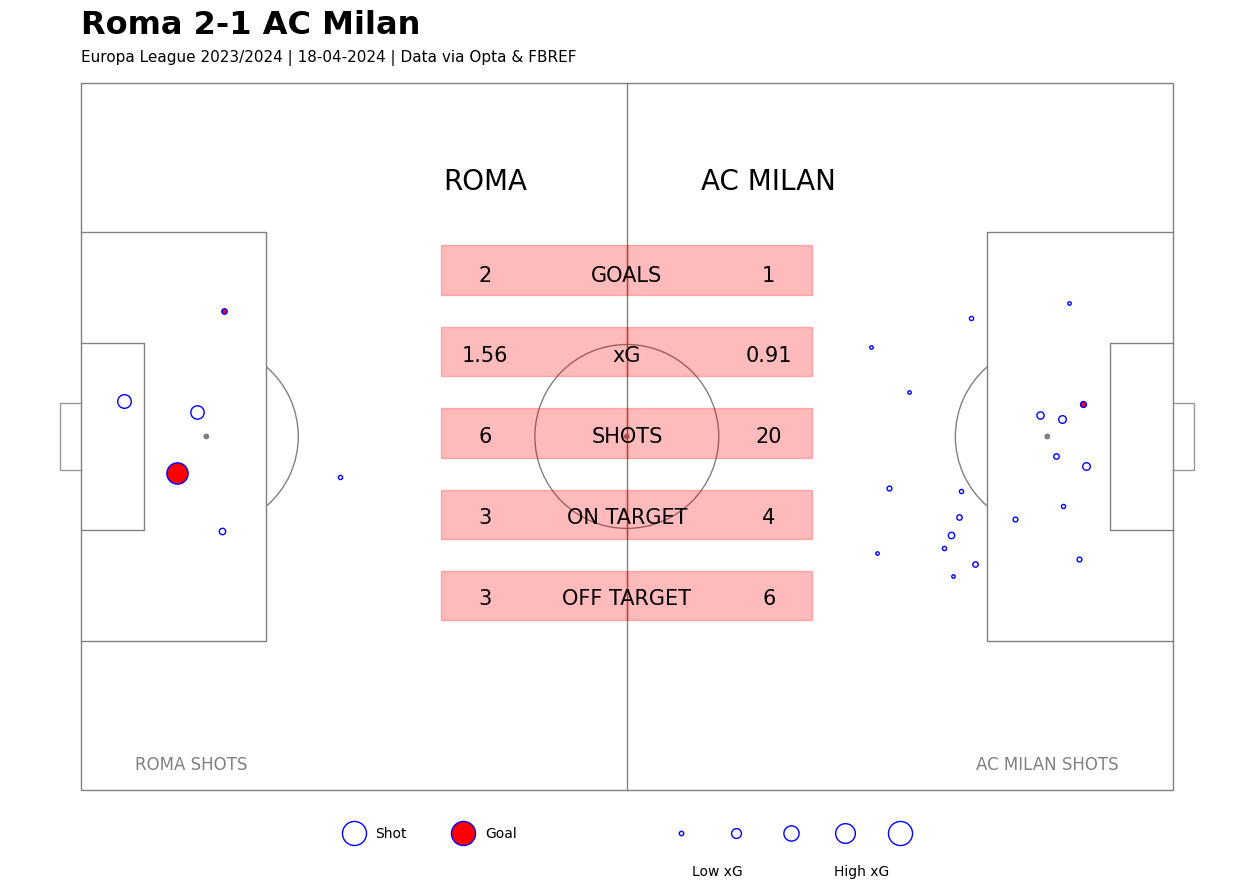

In [ ]:
pitch = Pitch(
    pitch_type = 'opta',
    half = False,
    goal_type = 'box',
    goal_alpha = 0.8,
    line_color = '0.5',
    linewidth = 1,
    pad_top=10, pad_bottom=10, pad_left=10, pad_right=10,
)
fig, ax = pitch.draw(constrained_layout=True, tight_layout=True)
fig.set_size_inches(16, 9)


for i in range(len(df)):
    scatter = pitch.scatter(
        
        # Coordinates
        (100 - df.x[i]) if (df.h_a[i] == 'h') else df.x[i],
        (100 - df.y[i]) if (df.h_a[i] == 'h') else df.y[i],
        # Size Between 100 and 1000
        s = (df.xG[i] * 300),
        # Type of Marker
        marker = "o",
        # Color Marker
        c = 'red' if (df.type[i] == 'Goal' or df.type[i] == 'OwnGoal') else 'white',
        # Color Marker Border
        edgecolors = 'blue',

        ax = ax
    )


# Stats
text = ax.text(
    x = 50, y = 50,
    s = 'GOALS'
        '\nxG'
        '\nSHOTS'
        '\nON TARGET'
        '\nOFF TARGET',
    size = 15,
    color='black',
    va='center', ha='center',
    linespacing = 4.8
)

# Home Stats
ax.text(
    x = 37, y = 50,
    s = f'{home_score}'
        f'\n{round(home_xG, 2)}'
        f'\n{number_home_shots}'
        f'\n{number_home_on_target}'
        f'\n{number_home_off_target}',
    size = 15,
    color='black',
    va='center', ha='center',
    linespacing = 4.8
)

# Away Stats
ax.text(
    x = 63, y = 50,
    s = f'{away_score}'
        f'\n{round(away_xG, 2)}'
        f'\n{number_away_shots}'
        f'\n{number_away_on_target}'
        f'\n{number_away_off_target}',
    size = 15,
    color='black',
    va='center', ha='center',
    linespacing = 4.8
)

# Home Team
ax.text(
    x = 37, y = 85,
    s = f'{home_team.upper()}',
    size = 20, ha = 'center'
)

# Away Team
ax.text(
    x = 63, y = 85,
    s = f'{away_team.upper()}',
    size = 20, ha = 'center'
)

# Home Shots
ax.text(
    x = 5, y = 3,
    s = f'{home_team.upper()} SHOTS',
    size = 12,
    c = '0.5',
    ha='left'
)

# Away Shots
ax.text(
    x = 95, y = 3,
    s = f'{away_team.upper()} SHOTS',
    size = 12,
    c = '0.5',
    ha = 'right'
)

# Box
patch = ax.add_patch(Rectangle((50,70), 17, 7, color='#FF000044'))
patch = ax.add_patch(Rectangle((50,70), -17, 7, color='#FF000044'))
patch = ax.add_patch(Rectangle((50,58.5), 17, 7, color='#FF000044'))
patch = ax.add_patch(Rectangle((50,58.5), -17, 7, color='#FF000044'))
patch = ax.add_patch(Rectangle((50,47), 17, 7, color='#FF000044'))
patch = ax.add_patch(Rectangle((50,47), -17, 7, color='#FF000044'))
patch = ax.add_patch(Rectangle((50,35.5), 17, 7, color='#FF000044'))
patch = ax.add_patch(Rectangle((50,35.5), -17, 7, color='#FF000044'))
patch = ax.add_patch(Rectangle((50,24), 17, 7, color='#FF000044'))
patch = ax.add_patch(Rectangle((50,24), -17, 7, color='#FF000044'))

# Legend
xG_Legend = plt.scatter(25,-6, s=300, c='white', edgecolors='blue')
xG_Legend = plt.scatter(35,-6, s=300, c='red', edgecolors='blue')
xG_Legend = plt.scatter(55, -6, s=10, c='white', edgecolors='blue')
xG_Legend = plt.scatter(60, -6, s=50, c='white', edgecolors='blue')
xG_Legend = plt.scatter(65, -6, s=120, c='white', edgecolors='blue')
xG_Legend = plt.scatter(70, -6, s=200, c='white', edgecolors='blue')
xG_Legend = plt.scatter(75, -6, s=300, c='white', edgecolors='blue')
ax.text(x=27, y=-6.1, s='Shot', va='center')
ax.text(x=37, y=-6.1, s='Goal', va='center')
ax.text(x=56, y=-12, s='Low xG')
ax.text(x=69, y=-12, s='High xG')

# Title
ax.text(
    x = 0, y = 107,
    s = f'{home_team} {home_score}-{away_score} {away_team}',
    size = 23, ha = 'left', weight='bold'
)
ax.text(
    x = 0, y = 103,
    s = f'{Competition} {Season} | {Date} | Data via Opta & FBREF',
    size = 11, ha = 'left'
)

plt.show()

In [ ]:
fig.savefig(f'D:\\Football\\Stats\\Shot Map\\{home_team}_VS_{away_team}_Shot_Map.png', dpi=400)

### xG Match Story

In [ ]:
home_cum_xg = [0]
away_cum_xg = [0]

home_sum = 0
for i in range(len(home_shots)):
    home_sum += home_shots['xG'][i]
    home_cum_xg.append(home_sum)
    home_cum_xg.append(home_sum)

away_sum = 0
for i in range(len(away_shots)):
    away_sum += away_shots['xG'][i]
    away_cum_xg.append(away_sum)
    away_cum_xg.append(away_sum)

In [ ]:
home_minute_shot = []
away_minute_shot = []

for i in range(len(home_shots)):
    home_minute_shot.append(home_shots.minute[i])
    home_minute_shot.append(home_shots.minute[i])

for i in range(len(away_shots)):
    away_minute_shot.append(away_shots.minute[i])
    away_minute_shot.append(away_shots.minute[i])

home_minute_shot.append(df.minute.max())
away_minute_shot.append(df.minute.max())

In [ ]:
away_shots.type.unique()

array(['MissedShots', 'SavedShot', 'Goal'], dtype=object)

In [ ]:
home_shots.sample(3)

id  eventId  minute  second  teamId h_a     x     y  expandedMinute      period         type outcomeType                                         qualifiers                               satisfiedEventsTypes  isTouch  matchId            startDate            startTime  score ftScore htScore etScore venueName  maxMinute  playerId        playerName  endX  endY  relatedEventId  relatedPlayerId  goalMouthZ  goalMouthY  isShot  isGoal  blockedX  blockedY cardType shotBodyType situation  shotSixYardBox  shotPenaltyArea  shotOboxTotal  shotOpenPlay  shotCounter  shotSetPiece  shotDirectCorner  shotOffTarget  shotOnPost  shotOnTarget  shotsTotal  shotBlocked  shotRightFoot  shotLeftFoot  shotHead  shotObp  goalSixYardBox  goalPenaltyArea  goalObox  goalOpenPlay  goalCounter  goalSetPiece  penaltyScored  goalOwn  goalNormal  goalRightFoot  goalLeftFoot  goalHead  goalObp  shortPassInaccurate  shortPassAccurate  passCorner  passCornerAccurate  passCornerInaccurate  passFreekick  \
4  2674493631      507      64    49.0      84   h  89.4  46.6              72  SecondHalf  MissedShots  Successful  [{'type': 'MissLeft'}, {'type': 'BlockedX', 'v...  [touches, shotOffTarget, shotOffTargetInsideBo...     True  1809766  2024-04-18T00:00:00  2024-04-18T20:00:00  2 : 1   2 : 1   2 : 0          Olimpico         96  317506.0     Tammy Abraham   NaN   NaN           506.0          70087.0        38.9        61.8    True   False      90.6      49.5    False    RightFoot  OpenPlay           False             True          False          True        False         False             False           True       False         False        True        False           True         False     False    False           False            False     False         False        False         False          False    False       False          False         False     False    False                False              False       False               False                 False         False   
5  2674493633      508      64    50.0      84   h  96.0  45.0              72  SecondHalf  MissedShots  Successful  [{'type': 'GoalMouthY', 'value': '52.4'}, {'ty...  [touches, shotOffTarget, shotOffTargetInsideBo...     True  1809766  2024-04-18T00:00:00  2024-04-18T20:00:00  2 : 1   2 : 1   2 : 0          Olimpico         96  317506.0     Tammy Abraham   NaN   NaN             NaN              NaN        93.1        52.4    True   False       NaN       NaN    False    RightFoot  OpenPlay            True            False          False          True        False         False             False           True       False         False        True        False           True         False     False    False           False            False     False         False        False         False          False    False       False          False         False     False    False                False              False       False               False                 False         False   
1  2674472095      106      11    16.0      84   h  91.2  55.2              11   FirstHalf         Goal  Successful  [{'type': 'HighRight'}, {'type': 'BigChance'},...  [touches, goalNormal, shotOnTarget, shotsTotal...     True  1809766  2024-04-18T00:00:00  2024-04-18T20:00:00  2 : 1   2 : 1   2 : 0          Olimpico         96  244804.0  Gianluca Mancini   NaN   NaN             NaN              NaN        22.2        46.1    True    True       NaN       NaN    False     LeftFoot  OpenPlay           False             True          False          True        False         False             False          False       False          True        True        False          False          True     False    False           False             True     False          True        False         False          False    False        True          False          True     False    False                False              False       False               False                 False         False   

   passBack  passForward  pass

In [ ]:
home_goal_minute = []
home_goal_cum_xG = []
for i in range(len(home_shots)):
    if home_shots['type'][i] == 'Goal':
        home_goal_minute.append(home_shots.minute[i])
        home_goal_cum_xG.append(home_cum_xg[i*2+1])
    else:
        pass

away_goal_minute = []
away_goal_cum_xG = []
for i in range(len(away_shots)):
    if away_shots['type'][i] == 'Goal':
        away_goal_minute.append(away_shots.minute[i])
        away_goal_cum_xG.append(away_cum_xg[i*2+1])
    else:
        pass

In [ ]:
if max(home_cum_xg) > max(away_cum_xg):
    max_xg = max(home_cum_xg)
else:
    max_xg = max(away_cum_xg)

In [ ]:
home_cum_xg[len(home_cum_xg) - 1]

1.5600000000000003

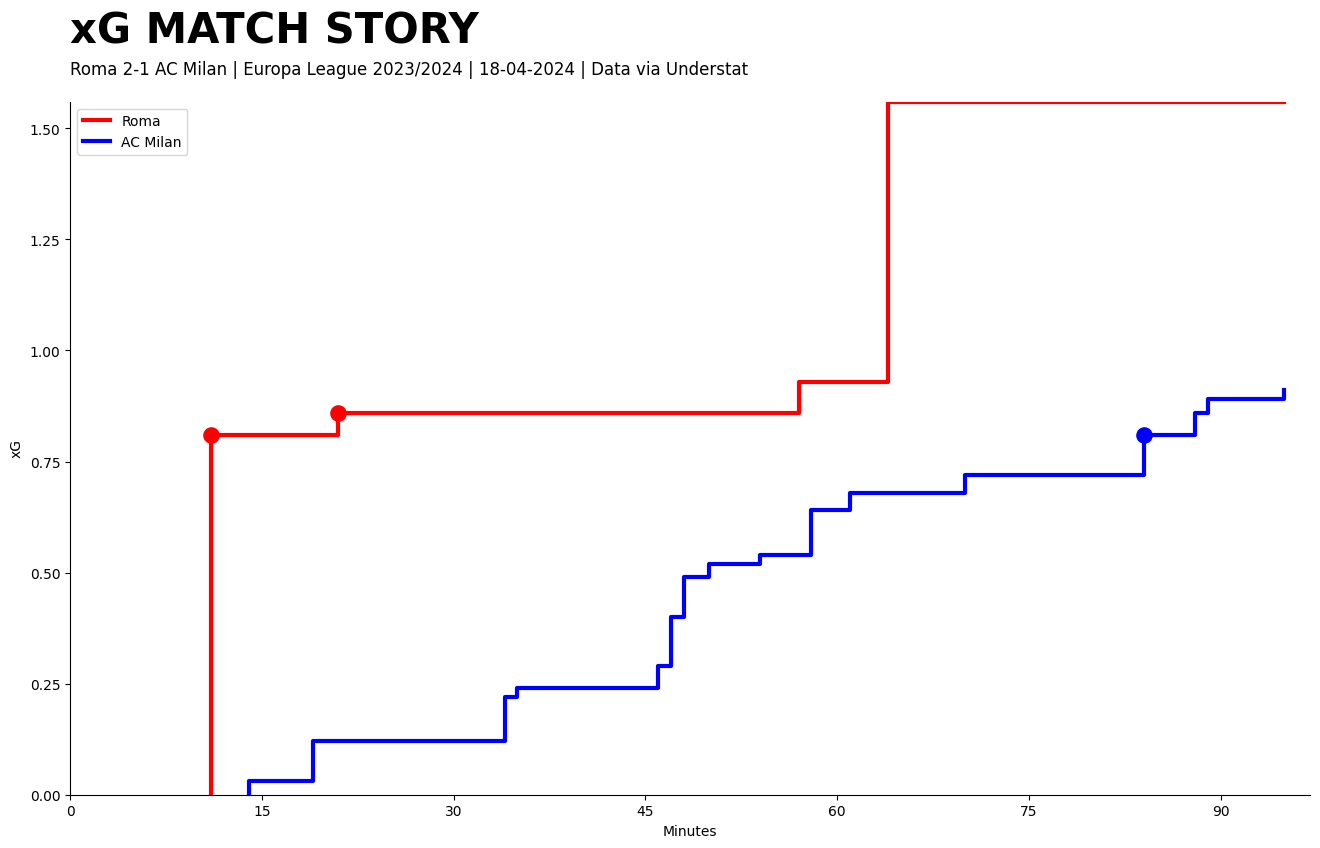

In [ ]:
lw = 3

fig, ax = plt.subplots()

#plt.subplots_adjust()
fig.set_size_inches(16, 9)

ax.plot(home_minute_shot, home_cum_xg, label=home_team, c='red', lw=lw)
ax.plot(away_minute_shot, away_cum_xg, label=away_team, c='blue', lw=lw)

ax.scatter(home_goal_minute, home_goal_cum_xG, c='red', s=120)
ax.scatter(away_goal_minute, away_goal_cum_xG, c='blue', s=120)

ax.spines["top"].set_color("None")
ax.spines["right"].set_color("None")

plt.text(0, max_xg + max_xg/7.5, s = "xG MATCH STORY", va='top', size=30, weight='bold')
plt.text(0, max_xg + max_xg/25, s = f"{home_team} {home_score}-{away_score} {away_team} | {Competition} {Season} | {Date} | Data via Understat", size=12)

plt.xlabel('Minutes')
plt.ylabel('xG')

plt.legend(loc=2)

plt.xlim(0, max(df.minute) + 2 if (max(df.minute) + 2 > 90) else 90)
plt.ylim(0, max_xg)

plt.xticks([0, 15, 30, 45, 60, 75, 90])
plt.yticks(np.arange(0, max_xg, 0.25))

plt.show()

In [ ]:
fig.savefig(f'D:\\Football\\Stats\\xG Match Story\\{home_team}_VS_{away_team}_xG_Match_Story.png', dpi=400)

In [ ]:
.END

SyntaxError: invalid syntax (1403085297.py, line 1)